------

### Requirements
```python
# numpy==1.23.4
# matplotlib
torch
# scikit-image
# odl==0.7.0
# dival
# wget # for downloading the test data
pillow # Image utils
```

In [1]:
# !pip install pillow
# !pip install torch
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm
# !pip install wandb

In [2]:
import os

# NOTE: Importing torch the first time will always take a long time!
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.data import Dataset

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import datetime

from PIL import Image

# Optional
from tqdm import tqdm # progress bar

import wandb # Optional, for logging

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold

In [3]:
!which python
print(f"Torch version: {torch.__version__}")
print(f"Path: {os.getcwd()}")

/mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv-2/bin/python


Torch version: 2.3.0+cu121
Path: /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/scripts/dyn_img_static


In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# DISABLING_TESTS = False
DISABLING_TESTS = True   # Disable tests for less output

### Use GPU

In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"Using {torch.backends.mps.get_device_name(0)} with MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

torch.set_default_device(DEVICE)

Using NVIDIA GeForce RTX 4090


------

### Import the image and transform the data

#### Download the data

In [7]:
# # REMEMBER TO COMMENT THIS OUT IF THE DATA HAS BEEN DOWNLOADED!
# !wget https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2
# !unzip "a26784fe-cf33-48c2-b61f-94b299dbc0f2" -d .

In [8]:
DATA_PATH = "./SIDD_Small_sRGB_Only/Data"

#### Take a single image

In [9]:
def get_npy_file(sample_path: str, scale_factor: float) -> np.ndarray:			
    scale_factor_str = str(scale_factor).replace('.','_')
    xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
    xf = torch.tensor(xf, dtype=torch.float)
    xf = xf.unsqueeze(0) / 255
    return xf

In [10]:
# CODE TO GET AN IMAGE FROM LOCAL FILE SYSTEM
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
def load_images(ids: list, take_npy_files: bool) -> list:
    data_path = DATA_PATH
    k = 0

    images = []

    for folder in os.listdir(data_path):
        img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
        if img_id not in ids:
            continue
        k += 1
        print(f'loading image id {img_id}, {k}/{len(ids)}')

        files_path = os.path.join(data_path, folder)

        # if take_npy_files:
        #     xf = get_npy_file(files_path, scale_factor)
        #     images.append(xf)
        #     continue

        # Use only the ground truth images
        file = "GT_SRGB_010.PNG"  # GT = Ground Truth

        image = Image.open(os.path.join(files_path, file))
        assert image.mode == 'RGB', f"Image mode is not RGB: {image.mode}" # For now, expect RGB images
        # width, height = image.size
        # Width and height are NOT always the same
        # assert (width, height) == (5328, 3000), f"Image size is not 5328x3000: {image.size}" # For now, expect 5328x3000 images

        images.append(image)

    return images

In [11]:
def test_load_images():
    if DISABLING_TESTS: return
    for img in load_images(["0065"], False):
        print(img.size)
        plt.imshow(img)

test_load_images()

------

#### Convert image to grayscale

In [12]:
# CODE TO CONVERT AN IMAGE TO GRAYSCALE
def convert_to_grayscale(image: Image) -> Image:
    return image.convert('L')

In [13]:
def test_convert_to_grayscale():
    if DISABLING_TESTS: return
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_convert_to_grayscale()

#### Resize image

(Optional) Rescale the image

Make the image a bit smaller

Example:

Original 5328 x 3000

Recaled 0.5 to 2664 x 1500

In [14]:
def resize_image(image, scale_factor):
    Nx_,Ny_ = int(np.floor(scale_factor * image.width )), int(np.floor(scale_factor * image.height ))
    image = image.resize( (Nx_, Ny_) )
    return image

In [15]:
def test_resize_image():
    if DISABLING_TESTS: return
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        img = resize_image(img, 0.05) # Extreme size reduction for demonstration
        print(img.size)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_resize_image()

#### Convert to numpy array

In [16]:
def convert_to_numpy(image):
    image_data = np.asarray(image)
    return image_data

In [17]:
def test_convert_to_numpy():
    if DISABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        print(f"Before conversion: {type(img)}")
        image_data = convert_to_numpy(img)
        print(f"After conversion: {type(image_data)}")
        # plt.imshow still works with numpy array
        plt.imshow(image_data, cmap='gray')

test_convert_to_numpy()

#### Convert to tensor

For efficient computation on GPU

In [18]:
def convert_to_tensor(image_data):
    xf = []
    xf.append(image_data)
    xf = np.stack(xf, axis=-1)
    xf = torch.tensor(xf, dtype=torch.float)
    xf = xf.unsqueeze(0) / 255
    return xf

In [19]:
def test_convert_to_tensor():
    if DISABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        image_data = convert_to_numpy(img)
        image_data = convert_to_tensor(image_data)
        print(image_data.size())
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')

test_convert_to_tensor()

#### Add synthetic noise

artificial Gaussian noise

Noise can occur in reality.

It is difficult to obtain a pair of clean and noisy images of one exact same scene.

For training, it is common to add synthetic noise to an image that is considered clean and then try to reconstruct it.

There are many types of noise and different ways to add noise. We can add salt-and-pepper noise. (?)We can add more noise in some parts and less in others. We can use a combination of noise-adding strategies to build more robust models.

For our purpose, we will focus on Gaussian noise. This is sufficient for most cases. 

(?) We will add noise with the same probability for each pixel (not using the strategies of focusing on certain regions)

In [20]:
# CODE TO ADD NOISE HERE
def get_variable_noise(sigma_min, sigma_max):
    return sigma_min + torch.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: torch.tensor, sigma) -> torch.tensor:
    std = torch.std(xf)
    mu = torch.mean(xf)

    x_centred = (xf  - mu) / std

    x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)

    xnoise = std * x_centred + mu

    return xnoise

In [21]:
def test_add_noise():
    if DISABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.05)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data)
        constant_noise_img = add_noise(image_data, sigma=0.1)
        variable_noise_img = add_noise(image_data, get_variable_noise(
            sigma_min=0.1, sigma_max=0.2))
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();
        plt.imshow(constant_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();
        plt.imshow(variable_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()
        
test_add_noise()

------

### Calculate PSNR

PSNR is a common metrics for noisy image.

Compare before and after adding synthetic noise

In [22]:
def PSNR(original, compressed): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0): # MSE is zero means no noise is present in the signal. 
                  # Therefore PSNR have no importance. 
        return 100
    # max_pixel = 255.0
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse)) 
    return psnr

In [23]:
def test_PSNR():
    if DISABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.5)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data)

        print(f"PSNR of original image: {PSNR(image_data, image_data)} dB")
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        noisy_img = add_noise(image_data, sigma=0.5)
        print(f"PSNR of constant noise image: {PSNR(image_data, noisy_img):.2f} dB")
        plt.imshow(noisy_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

test_PSNR()

------

### Reconstruct an image with PDHG

#### Calculate the gradient

The gradient is a Laplacian ?

There are $x$ gradient and $y$ gradient

In [24]:
# Code taken from ...

class GradOperators(torch.nn.Module):
    @staticmethod
    def diff_kernel(ndim, mode):
        if mode == "doublecentral":
            kern = torch.tensor((-1, 0, 1))
        elif mode == "central":
            kern = torch.tensor((-1, 0, 1)) / 2
        elif mode == "forward":
            kern = torch.tensor((0, -1, 1))
        elif mode == "backward":
            kern = torch.tensor((-1, 1, 0))
        else:
            raise ValueError(f"mode should be one of (central, forward, backward, doublecentral), not {mode}")
        kernel = torch.zeros(ndim, 1, *(ndim * (3,)))
        for i in range(ndim):
            idx = tuple([i, 0, *(i * (1,)), slice(None), *((ndim - i - 1) * (1,))])
            kernel[idx] = kern
        return kernel

    def __init__(self, dim:int=2, mode:str="doublecentral", padmode:str = "circular"):
        """
        An Operator for finite Differences / Gradients
        Implements the forward as apply_G and the adjoint as apply_GH.
        
        Args:
            dim (int, optional): Dimension. Defaults to 2.
            mode (str, optional): one of doublecentral, central, forward or backward. Defaults to "doublecentral".
            padmode (str, optional): one of constant, replicate, circular or refelct. Defaults to "circular".
        """
        super().__init__()
        self.register_buffer("kernel", self.diff_kernel(dim, mode), persistent=False)
        self._dim = dim
        self._conv = (torch.nn.functional.conv1d, torch.nn.functional.conv2d, torch.nn.functional.conv3d)[dim - 1]
        self._convT = (torch.nn.functional.conv_transpose1d, torch.nn.functional.conv_transpose2d, torch.nn.functional.conv_transpose3d)[dim - 1]
        self._pad = partial(torch.nn.functional.pad, pad=2 * dim * (1,), mode=padmode)
        if mode == 'central':
            self._norm = (self.dim) ** (1 / 2)
        else:
            self._norm = (self.dim * 4) ** (1 / 2)

    @property
    def dim(self):
        return self._dim
    
    def apply_G(self, x):
        """
        Forward
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim], self.dim, *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[0 : -self.dim], self.dim, *x.shape[-self.dim :])
        return y

    def apply_GH(self, x):
        """
        Adjoint
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, self.dim, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._convT(xp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim - 1], *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[: -self.dim - 1], *x.shape[-self.dim :])
        return y
    
    def apply_GHG(self, x):
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        tmp = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        tmp = self._pad(tmp)
        y = self._convT(tmp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape)
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape)
        return y

    def forward(self, x, direction=1):
        if direction>0:
            return self.apply_G(x)
        elif direction<0:
            return self.apply_GH(x)
        else:
            return self.apply_GHG(x)

    @property
    def normGHG(self):
        return self._norm

#### Helper function for PDHG: Clip act

In [25]:
# Code taken from ...

class ClipAct(nn.Module):
    def forward(self, x, threshold):
        return clipact(x, threshold)


def clipact(x, threshold):
    is_complex = x.is_complex()
    if is_complex:
        x = torch.view_as_real(x)
        threshold = threshold.unsqueeze(-1)
    x = torch.clamp(x, -threshold, threshold)
    if is_complex:
        x = torch.view_as_complex(x)
    return x

#### Only PDHG

For some reason, running PDHG with T large (many iterations in PDGH) will make GPU memory full?

In [26]:
# Code taken from ...

def reconstruct_with_PDHG(x, lambda_reg, T):
    # NOTE: mb is the number of patches
    dim = 3
    if dim == 2:
        mb, Nx, Ny = x.shape
    elif dim == 3:
        mb, _, Nx, Ny, Nt = x.shape

    device = x.device

    # starting values
    xbar = x.clone()
    x0 = x.clone()
    xnoisy = x.clone()

    # dual variable
    p = x.clone()
    q = torch.zeros(mb, dim, Nx, Ny, Nt, dtype=x.dtype).to(device)

    # operator norms
    op_norm_AHA = torch.sqrt(torch.tensor(1.0))
    op_norm_GHG = torch.sqrt(torch.tensor(12.0))
    # operator norm of K = [A, \nabla]
    # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
    # see page 3083
    L = torch.sqrt(op_norm_AHA**2 + op_norm_GHG**2)

    tau = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L
    sigma = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L

    # theta should be in \in [0,1]
    theta = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1

    # sigma, tau, theta
    sigma = (1 / L) * torch.sigmoid(sigma)  # \in (0,1/L)
    tau = (1 / L) * torch.sigmoid(tau)  # \in (0,1/L)
    theta = torch.sigmoid(theta)  # \in (0,1)

    GradOps = GradOperators(
        dim=dim, 
        mode="forward", padmode="circular")
    clip_act = ClipAct()
    # Algorithm 2 - Unrolled PDHG algorithm (page 18)
    # TODO: In the paper, L is one of the inputs but not used anywhere in the pseudo code???
    for kT in range(T):
        # update p
        p =  (p + sigma * (xbar - xnoisy) ) / (1. + sigma)
        # update q
        q = clip_act(q + sigma * GradOps.apply_G(xbar), lambda_reg)

        x1 = x0 - tau * p - tau * GradOps.apply_GH(q)

        if kT != T - 1:
            # update xbar
            xbar = x1 + theta * (x1 - x0)
            x0 = x1
        with torch.no_grad():
            torch.cuda.empty_cache()

    with torch.no_grad():
        torch.cuda.empty_cache()

    return x1

In [27]:
def test_reconstruct_with_PDHG():
    if DISABLING_TESTS: return
    # for rgb_image in load_images(["0001"], False):
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.125)
        image_data = convert_to_numpy(grayscale_image)

        print(f"Image data shape: {image_data.shape}")

        image_data = convert_to_tensor(image_data)
        print(f"Image size: {image_data.size()}")
        print(f"PSNR of original image: {PSNR(image_data, image_data)} dB")
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_SIGMA = 0.5  # Relatively high noise
        constant_noise_img = add_noise(image_data, sigma=TEST_SIGMA)
        print(f"PSNR of constant noise image: {PSNR(image_data, constant_noise_img):.2f} dB")
        plt.imshow(constant_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        # TEST_LAMBDA = 0.1 # A test value to see the effect of lambda on regularization
        # TEST_LAMBDA = 0.2 # A test value to see the effect of lambda on regularization
        TEST_LAMBDA = 0.04
        pdhg_input = constant_noise_img.unsqueeze(0)
        print(f"PDHG input size: {pdhg_input.size()}")
        reconstructed_img = reconstruct_with_PDHG(
            pdhg_input, 
            lambda_reg=TEST_LAMBDA, 
            T=128
            # T=1000
            )
        resconstructed_image_data = reconstructed_img
        print(f"Reconstructed image data shape: {resconstructed_image_data.shape}")
        print(f"PSNR of reconstructed image: {PSNR(image_data, resconstructed_image_data):.2f} dB")
        plt.imshow(resconstructed_image_data.squeeze(0).squeeze(0).to("cpu").detach().numpy(), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

    print("""
In this example, a lot of noise has been applied to the original image. The PDHG algorithm tries to reconstruct the image from the noisy image. It did remove some noise and improved the PSNR value. However, the quality has been degraded significantly. We will see whether we can improve this by learning a set of parameters map.
""")
    
    # The lambda parameter is the regularization parameter. The higher the lambda, the more the regularization. The T parameter is the number of iterations. The higher the T, the more the iterations. The PSNR value is the Peak Signal to Noise Ratio. The higher the PSNR, the better the reconstruction.

test_reconstruct_with_PDHG()

------

### Full Architecture

UNET to PDHG

The whole architecture can be seen as unsupervised: The data only contains (clean) images.

The whole model: Input is an image. Output is also an image.

The UNET actually only outputs the regularisation parameter map.

In [28]:
# Code taken from ...

class DynamicImageStaticPrimalDualNN(nn.Module):
    def __init__(
        self,
        T=128,
        cnn_block=None,
        mode="lambda_cnn",
        up_bound=0,
        phase="training",
    ):
        # print(f"Running: {DynamicImageStaticPrimalDualNN.__name__}")
        super(DynamicImageStaticPrimalDualNN, self).__init__()

        # gradient operators and clipping function
        dim = 3
        self.GradOps = GradOperators(dim, mode="forward", padmode="circular")

        # operator norms
        self.op_norm_AHA = torch.sqrt(torch.tensor(1.0))
        self.op_norm_GHG = torch.sqrt(torch.tensor(12.0))
        # operator norm of K = [A, \nabla]
        # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
        # see page 3083
        self.L = torch.sqrt(self.op_norm_AHA**2 + self.op_norm_GHG**2)

        # function for projecting
        self.ClipAct = ClipAct()

        if mode == "lambda_xyt":
            # one single lambda for x,y and t
            self.lambda_reg = nn.Parameter(torch.tensor([-1.5]), requires_grad=True)

        elif mode == "lambda_xy_t":
            # one (shared) lambda for x,y and one lambda for t
            self.lambda_reg = nn.Parameter(
                torch.tensor([-4.5, -1.5]), requires_grad=True
            )

        elif mode == "lambda_cnn":
            # the CNN-block to estimate the lambda regularization map
            # must be a CNN yielding a two-channeld output, i.e.
            # one map for lambda_cnn_xy and one map for lambda_cnn_t
            self.cnn = cnn_block    # NOTE: This is actually the UNET!!! (At least in this project)
            self.up_bound = torch.tensor(up_bound)

        # number of terations
        self.T = T
        self.mode = mode

        # constants depending on the operators
        self.tau = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L
        self.sigma = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L

        # theta should be in \in [0,1]
        self.theta = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1

        # distinguish between training and test phase;
        # during training, the input is padded using "reflect" padding, because
        # patches are used by reducing the number of temporal points;
        # while testing, "reflect" padding is used in x,y- direction, while
        # circular padding is used in t-direction
        self.phase = phase

    def get_lambda_cnn(self, x):
        # padding
        # arbitrarily chosen, maybe better to choose it depending on the
        # receptive field of the CNN or so;
        # seems to be important in order not to create "holes" in the
        # lambda_maps in t-direction
        npad_xy = 4
        # npad_t = 8
        npad_t = 0 # TODO: Time dimension should not be necessary for single image input.
        # I changed the npad_t to 0 so that I can run on single image input without change the 3D type config. It seems that the number of frames must be greater than npad_t?

        pad = (npad_t, npad_t, npad_xy, npad_xy, npad_xy, npad_xy)

        if self.phase == "training":
            x = F.pad(x, pad, mode="reflect")

        elif self.phase == "testing":
            pad_refl = (0, 0, npad_xy, npad_xy, npad_xy, npad_xy)
            pad_circ = (npad_t, npad_t, 0, 0, 0, 0)

            x = F.pad(x, pad_refl, mode="reflect")
            x = F.pad(x, pad_circ, mode="circular")

        # estimate parameter map
        lambda_cnn = self.cnn(x) # NOTE: The cnn is actually the UNET block!!! (At least in this project)

        # crop
        neg_pad = tuple([-pad[k] for k in range(len(pad))])
        lambda_cnn = F.pad(lambda_cnn, neg_pad)

        # double spatial map and stack
        lambda_cnn = torch.cat((lambda_cnn[:, 0, ...].unsqueeze(1), lambda_cnn), dim=1)

        # constrain map to be striclty positive; further, bound it from below
        if self.up_bound > 0:
            # constrain map to be striclty positive; further, bound it from below
            lambda_cnn = self.up_bound * self.op_norm_AHA * torch.sigmoid(lambda_cnn)
        else:
            lambda_cnn = 0.1 * self.op_norm_AHA * F.softplus(lambda_cnn)

        return lambda_cnn

    def forward(self, x, lambda_map=None):
        if lambda_map is None:
            # estimate lambda reg from the image
            lambda_reg = self.get_lambda_cnn(x)
        else:
            lambda_reg = lambda_map
        x.to(DEVICE)
        x1 = reconstruct_with_PDHG(x, lambda_reg, self.T)
        return x1

------

### Problem introduction

Image denoising

Assuming the image will have additive Gaussian noise

A way to judge whether an image is "noisy" is by seeing whether there are a lot of "changes" between nearby pixels.

In other words, to see whether the gradient is too high.

That's why there is a regularisation term in the loss function. We want to penalise large changes in gradient.

Mathematically, we treat an image as a vector $\vec{x}$.

Let $\vec{z}$ denote the vector of the image we want to denoise, and $\vec{x}$ the output image. We wish $\vec{x}$ to be as close to the ideal $\vec{x}_{\text{true}}$ as possible. Since we don't know this, we use a combination of 2 measures as our targets. One is a data-discrepancy measure. Minimising this measure means we keep as much original information in $\vec{z}$ as possible. However, keeping all information means we will not remove any noise. Intuitively, we see an image as being noisy when there are a lot of tiny "changes". 

(?) Noise means the important information in the image is still preserved, but the image is not visually pleasing. Denoising helps make the image more visually pleasant but still contains all the imporant information. 

The loss function is:

$$ L(\vec{x}, \vec{z}) = \min_{\vec{x}} \frac{1}{2} || \vec{x} - \vec{z} ||_{2}^{2} + \lambda || \nabla \vec{x} ||_{1} $$

The algorithm to reconstruct the image is Primal-Dual-Hybrid-G...

This algorithm requires the regularisation parameters.

Good regularisation parameter will help strike a good balance between smoothing out the noisy parts and keeping as much original information as possible.

Lambda too high will make the reconstructed image to lose too much information. Too low will not remove a lot of noise.



In [29]:
# CODE OF THE LOSS FUNCTION HERE

------

### Divide image into patches

Cut into 192 x 192 small patches. Each patch is one input (right?)

??? Should I try to make the patch size divisible by the image dimension: 222 * 125

5328 = 222 * 24
3000 = 125 * 24

2664 = 222 * 12
3000 = 125 * 12

In [30]:
# Code taken from ...

def extract_patches_3d(x, kernel_size, padding=0, stride=1, dilation=1):
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size, kernel_size)
    if isinstance(padding, int):
        padding = (padding, padding, padding)
    if isinstance(stride, int):
        stride = (stride, stride, stride)
    if isinstance(dilation, int):
        dilation = (dilation, dilation, dilation)

    def get_dim_blocks(dim_in, dim_kernel_size, dim_padding = 0, dim_stride = 1, dim_dilation = 1):
        dim_out = (dim_in + 2 * dim_padding - dim_dilation * (dim_kernel_size - 1) - 1) // dim_stride + 1
        return dim_out

    channels = x.shape[-4]
    d_dim_in = x.shape[-3]
    h_dim_in = x.shape[-2]
    w_dim_in = x.shape[-1]
    d_dim_out = get_dim_blocks(d_dim_in, kernel_size[0], padding[0], stride[0], dilation[0])
    h_dim_out = get_dim_blocks(h_dim_in, kernel_size[1], padding[1], stride[1], dilation[1])
    w_dim_out = get_dim_blocks(w_dim_in, kernel_size[2], padding[2], stride[2], dilation[2])

    # (B, C, D, H, W)
    x = x.view(-1, 
               channels, 
               d_dim_in, 
               h_dim_in * w_dim_in)                                                     
    # (B, C, D, H * W)

    x = torch.nn.functional.unfold(x, 
                                   kernel_size=(kernel_size[0], 1), 
                                   padding=(padding[0], 0), 
                                   stride=(stride[0], 1), 
                                   dilation=(dilation[0], 1))                   
    # (B, C * kernel_size[0], d_dim_out * H * W)

    x = x.view(-1, 
               channels * kernel_size[0] * d_dim_out, 
               h_dim_in, 
               w_dim_in)                                   
    # (B, C * kernel_size[0] * d_dim_out, H, W)

    x = torch.nn.functional.unfold(x, 
                                   kernel_size=(kernel_size[1], kernel_size[2]), 
                                   padding=(padding[1], padding[2]), 
                                   stride=(stride[1], stride[2]), 
                                   dilation=(dilation[1], dilation[2]))        
    # (B, C * kernel_size[0] * d_dim_out * kernel_size[1] * kernel_size[2], h_dim_out, w_dim_out)

    x = x.view(-1, channels, kernel_size[0], d_dim_out, kernel_size[1], kernel_size[2], h_dim_out, w_dim_out)  
    # (B, C, kernel_size[0], d_dim_out, kernel_size[1], kernel_size[2], h_dim_out, w_dim_out)  

    x = x.permute(0, 1, 3, 6, 7, 2, 4, 5)
    # (B, C, d_dim_out, h_dim_out, w_dim_out, kernel_size[0], kernel_size[1], kernel_size[2])

    x = x.contiguous().view(-1, channels, kernel_size[0], kernel_size[1], kernel_size[2])
    # (B * d_dim_out * h_dim_out * w_dim_out, C, kernel_size[0], kernel_size[1], kernel_size[2])

    x_patches = x
    return x_patches

In [31]:
def test_extract_patches_3d():
    if DISABLING_TESTS: return
    # for rgb_image in load_images(["0001"], False):
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.25)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data)
        print(f"Image data size: {image_data.size()}")
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        # Extract patches
        x_patches = extract_patches_3d(
            image_data, 
            kernel_size=[192, 192, 1], 
            padding=0, 
            stride=[192, 192, 1], 
            dilation=1)
        print(f"x_patches size: {x_patches.size()}")
        assert x_patches.size() == torch.Size([15, 1, 192, 192, 1])
        fig, ax = plt.subplots(3, 5, figsize=(9,6), layout="compressed")
        for i in range(15):
            patch = x_patches[i]
            plt.subplot(3, 5, i+1).imshow(patch.squeeze(0).to("cpu"), cmap='gray')
            plt.subplot(3, 5, i+1).set_xticks([])
            plt.subplot(3, 5, i+1).set_yticks([])
        # Remove x and y ticks
        plt.axis('off')
        plt.show();

test_extract_patches_3d()

------

### Stitch the patches together

Prep for inference

In [32]:
# Code taken from ...

def stitch_patches_back_to_image(x_patches, img_h, img_w, k_h, k_w):
    num_rows = img_h // k_h
    num_cols = img_w // k_w

    rows = []
    for i_row in range(num_rows):
        row = []
        for i_col in range(num_cols):
            i = i_row*num_cols + i_col
            patch = x_patches[i]
            row.append(patch)
        rows.append(torch.cat(row, dim=2))

    x_stitched = torch.cat(rows, dim=1) # Concatenate the rows
    return x_stitched


In [33]:
def test_stitch_patches_back_to_image():
    if DISABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.25)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data)
        print(f"Image data size: {image_data.size()}")

        # Extract patches
        x_patches = extract_patches_3d(
            image_data, 
            kernel_size=[192, 192, 1], 
            padding=0, 
            stride=[192, 192, 1], 
            dilation=1)
        print(f"x_patches size: {x_patches.size()}")

        # Stitch patches back to image
        img_h = image_data.size(1)
        img_w = image_data.size(2)
        k_h = 192
        k_w = 192
        print(f"img_h: {img_h}, img_w: {img_w}, k_h: {k_h}, k_w: {k_w}")
        x_combined = stitch_patches_back_to_image(
            x_patches,
            img_h=img_h,
            img_w=img_w,
            k_h=k_h,
            k_w=k_w)
        print(f"x_combined size: {x_combined.size()}")
        plt.imshow(x_combined.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

test_stitch_patches_back_to_image()

------

### Data loading class

In [51]:
# Code taken from ...

class DynamicImageStaticDenoisingDataset(Dataset):
	
	def __init__(
		self, 
		data_path: str, 
		ids: list,
		scale_factor = 0.5, 
		sigma=0.23,  
		patches_size = None,
		strides= None,
		extract_data=True,
		device: str = "cuda"
	):
		self.device = device
		self.scale_factor = scale_factor

		ids = [str(x).zfill(2) for x in ids]

		xf_list = []
  
		k = 0
		# for k, img_id in enumerate(ids):
		for folder in os.listdir(data_path):
			img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
			if img_id not in ids:
				continue
			k += 1
			print(f'loading image id {img_id}, {k}/{len(ids)}')
			# sample_path = os.path.join(data_path, f"MOT17-{img_id}")
			sample_path = os.path.join(data_path, folder)
			if extract_data:
				xf = self.create_dyn_img(sample_path)
			else:
				scale_factor_str = str(self.scale_factor).replace('.','_')
				xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
				
			xf = torch.tensor(xf, dtype=torch.float)
			xf = xf.unsqueeze(0) / 255
			
			if patches_size is not None:
				
				print(f"extracting patches of shape {patches_size}; strides {strides}")
				xf_patches = extract_patches_3d(xf.contiguous(), patches_size, stride=strides)
				xf_list.append(xf_patches)
			
		if patches_size is not None:
			# will have shape (mb, 1, Nx, Ny, Nt), where mb denotes the number of patches
			xf = torch.concat(xf_list,dim=0)
			
		else:
			xf = xf.unsqueeze(0)
		
		#create temporal TV vector to detect which patches contain the most motion
		xf_patches_tv = (xf[...,1:] - xf[...,:-1]).pow(2).sum(dim=[1,2,3,4]) #contains the TV for all patches
		
		#normalize to 1 to have a probability vector
		xf_patches_tv /= torch.sum(xf_patches_tv)
		
		#sort TV in descending order --> xfp_tv_ids[0] is the index of the patch with the most motion
		self.samples_weights = xf_patches_tv

		# TODO: Investigate
		# Change the values in samples_weights to be a range of integers from 0 to len(samples_weights)
		# Unless I do this, when I run on a set of identical images, it will give me an error:
		# RuntimeError: invalid multinomial distribution (encountering probability entry < 0)
		# self.samples_weights = torch.arange(len(self.samples_weights))
		self.samples_weights = torch.ones_like(self.samples_weights) / len(self.samples_weights)
		
		self.xf = xf
		self.len = xf.shape[0]
		
		if isinstance(sigma, float):
			self.noise_level = 'constant'
			self.sigma = sigma

		elif isinstance(sigma, (tuple, list)):
			self.noise_level = 'variable'
			self.sigma_min = sigma[0]
			self.sigma_max = sigma[1]
		
		else:
			raise ValueError("Invalid sigma value provided, must be float, tuple or list.")

	def create_dyn_img(self, sample_path: str):
		
		files_path = sample_path
		files_list = os.listdir(files_path)
		xf = []

		for file in files_list:
			if not file.startswith('GT'):
				continue
			image = Image.open(os.path.join(files_path, file))
			
			#resize
			Nx_,Ny_ = int(np.floor(self.scale_factor * image.width )), int(np.floor(self.scale_factor * image.height ))
			image = image.resize( (Nx_, Ny_) )
			
			
			image = image.convert('L') #convert to grey_scale
			image_data = np.asarray(image)
			xf.append(image_data)
			
		xf = np.stack(xf, axis=-1)
		
		scale_factor_str = str(self.scale_factor).replace('.','_')
		np.save(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"), xf)
		
		return xf
			
	def __getitem__(self, index):

		std = torch.std(self.xf[index])
		mu = torch.mean(self.xf[index])

		x_centred = (self.xf[index]  - mu) / std

		if self.noise_level == 'constant':
			sigma = self.sigma
			
		elif self.noise_level == 'variable':
			sigma = self.sigma_min + torch.rand(1) * ( self.sigma_max - self.sigma_min )

		x_centred += sigma * torch.randn(self.xf[index].shape, dtype = self.xf[index].dtype)

		xnoise = std * x_centred + mu
  
		return (
			xnoise.to(device=self.device),
   			self.xf[index].to(device=self.device)
        )
		
	def __len__(self):
		return self.len

------

### Create data loader

In [52]:
# Code adapted from ...

# Ids are in the form of 4 character strings "0001" to "0200"
# TRAINING = [str(x).zfill(4) for x in range(1, 201)]
TRAINING = [str(x).zfill(4) for x in range(54, 74)]
# print(f"TRAINING: {TRAINING}")

VALIDATION = ["0065"] # TODO: Decide what to use for validation

data_path = DATA_PATH
# Make sure that the dataset was downloaded successfully
# The data samples can be created with different scaling factors.
# Make sure to set extract_data to True when loading the dataset for the first time to create the dynamic images.
# Once the data for a specific scaling factor has been created the flag can be set to False.
dataset_train = DynamicImageStaticDenoisingDataset(
    data_path=data_path,
    ids=TRAINING,     
    # ids=["0065"],       # testing
    scale_factor=0.25,
    # sigma=[0.1, 0.3],
    sigma=[0.3, 0.3],
    # sigma=[0.5, 0.5],
    strides=[192, 192, 1],
    patches_size=[192, 192, 1],
    # strides=[512, 512, 1],
    # patches_size=[512, 512, 1],
    # (!) Make sure to set the following flag to True when loading the dataset for the first time.
    extract_data=True,
    # extract_data=False,
    device=DEVICE
)

# Create training dataloader
sampler = WeightedRandomSampler(dataset_train.samples_weights, len(dataset_train.samples_weights))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, sampler=sampler)

# Validation dataset (see note above)
dataset_valid = DynamicImageStaticDenoisingDataset(
    data_path=data_path,
    # ids=VALIDATION,   
    ids=["0065"],       # testing
    scale_factor=0.25,
    # sigma=[0.1, 0.3],
    sigma=[0.3, 0.3],
    # sigma=[0.5, 0.5],
    strides=[192, 192, 1],
    patches_size=[192, 192, 1],
    # strides=[512, 512, 1],
    # patches_size=[512, 512, 1],
    # (!) Make sure to set the following flag to True when loading the dataset for the first time.
    extract_data=True,
    # extract_data=False,
    device=DEVICE
)

# Create validation dataloader 
sampler = WeightedRandomSampler(dataset_valid.samples_weights, len(dataset_valid.samples_weights))
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=1, sampler=sampler)

loading image id 0054, 1/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0055, 2/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0057, 3/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0059, 4/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0060, 5/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0062, 6/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0063, 7/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0064, 8/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0065, 9/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0066, 10/20
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0068, 11/20
extracting patches of shape [192, 192, 1

------

### UNET

The specific UNET architecture we use has the following parts:

...

We use Leaky RELU instead of RELU or Sigmoid.

In [36]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [37]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01)
        )

    def forward(self, x):
        return self.conv_block(x)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.enc_blocks = nn.ModuleList([
            ConvBlock(1, 16),
            ConvBlock(16, 32),
            ConvBlock(32, 64),
            # ConvBlock(1, 64),  # NOTE: Imitating the original UNet
            # ConvBlock(64, 128),  # NOTE: Trying to add one more block
            # ConvBlock(128, 256),  # NOTE: Trying to add two more blocks
            # ConvBlock(256, 512),  # NOTE: Trying to add three more blocks
            # ConvBlock(512, 1024),  # NOTE: Imitating the original UNet
        ])
        self.pool = nn.MaxPool3d(kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        enc_features = []
        for block in self.enc_blocks:
            x = block(x)
            enc_features.append(x)
            x = self.pool(x)
        return enc_features

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upconvs = nn.ModuleList([
            # nn.Conv3d(1024, 512, kernel_size=3, stride=1, padding=1),  # NOTE: Imitating the original UNet
            # nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add three more blocks
            # nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add two more blocks
            # nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add one more block
            nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=1),
        ])
        self.dec_blocks = nn.ModuleList([
            # ConvBlock(1024, 512),  # NOTE: Imitating the original UNet
            # ConvBlock(512, 256),  # NOTE: Trying to add three more blocks
            # ConvBlock(256, 128),  # NOTE: Trying to add two more blocks
            # ConvBlock(128, 64),  # NOTE: Trying to add one more block
            ConvBlock(64, 32),
            ConvBlock(32, 16),
        ])

    def forward(self, x, enc_features):
        for i in range(len(self.upconvs)):
            x = self.upconvs[i](x)
            x = torch.cat((x, enc_features[i]), dim=1)  # concatenate along the channel axis
            x = self.dec_blocks[i](x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.c1x1 = nn.Conv3d(16, 2, kernel_size=1, stride=1, padding=0)
        # self.c1x1 = nn.Conv3d(64, 2, kernel_size=1, stride=1, padding=0)    # NOTE: Imitating the original UNet

    def forward(self, x):
        enc_features = self.encoder(x)
        x = self.decoder(enc_features[-1], enc_features[::-1][1:])
        x = self.c1x1(x)
        return x

def test_unet():
    # Example usage
    model = UNet()
    # input_tensor = torch.randn(1, 1, 64, 64, 64)  # batch size of 1, 1 channel, 64x64x64 volume
    input_tensor = torch.randn(1, 1, 512, 512, 1)  # batch size of 1, 1 channel, 64x64x64 volume
    output = model(input_tensor)
    # print(output.shape)  # should be (1, 2, 64, 64, 64)
    print(output.shape)  # should be (1, 2, 512, 512, 1)

    print(f"\n{model}")

    with torch.no_grad():
        torch.cuda.empty_cache()

    # Delete the model and the output tensor
    del model
    del output
    torch.cuda.empty_cache()

test_unet()
with torch.no_grad():
    torch.cuda.empty_cache()

torch.Size([1, 2, 512, 512, 1])

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 

In [38]:
def test_UNET():
    # unet_test = UNet(dim=3, n_ch_in=1).to(DEVICE)
    unet_test = UNet().to(DEVICE)

    print(f"\n\n{unet_test}")

test_UNET()



UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stri

------

### Training

#### Code for one epoch

In [39]:
# Code taken from ...

def train_epoch(model, data, optimizer, loss_func) -> float:
    """Perform the training of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data
        Dataloader with training data
    optimizer
        Pytorch optimizer, e.g. Adam
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        training loss

    Raises
    ------
    ValueError
        loss is NaN
    """
    running_loss = 0.

    # for sample in data: # If cannot install tqdm
    for sample in tqdm(data): # tqdm helps show a nice progress bar
        optimizer.zero_grad(set_to_none=True)  # Zero your gradients for every batch!
        
        sample, label = sample
        # print(f"sample: {sample.shape}")
        output = model(sample)
        loss = loss_func(label, output)
        loss.backward()
        
        if loss.item() != loss.item():
            raise ValueError("NaN returned by loss function...")

        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(data.dataset)


def validate_epoch(model, data, loss_func) -> float:
    """Perform the validation of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data
        Dataloader with validation data
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        validation loss
    """
    running_loss = 0.
    
    # for sample in data: # If cannot install tqdm
    for sample in tqdm(data): # tqdm helps show a nice progress bar
        inputs, labels = sample
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        running_loss += loss.item()

    return running_loss / len(data.dataset)


#### Optional: Use wandb to log the training process

In [40]:
# Optional: Use wandb to log the training process
!wandb login

os.environ['WANDB_NOTEBOOK_NAME'] = 'image-denoising-1'
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="image-denoising-2",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "architecture": "UNET-PDHG",
    "up_bound": 0.5,
    # "dataset": "SIDD_Small-img_0065_only",
    "dataset": "All_SIDD_Small",
    "scale_factor": 0.25,
    # "scale_factor": 0.5,
    "kernel_size": 192,
    # "kernel_size": 512,
    # "sigma": 1,
    # "sigma": 0.5,
    "sigma": 0.3,
    # "T": 32,
    "T": 128,
    # "T": 200,
    "activation": "LeakyReLU",
    "epochs": 10_000,
    "unet_size": "small-16-32-64",
    }
)

wandb: Currently logged in as: trung-vuthanh24 (wof). Use `wandb login --relogin` to force relogin


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find image-denoising-1.
wandb: Currently logged in as: trung-vuthanh24 (wof). Use `wandb login --relogin` to force relogin


#### Start training

First initiate the UNet

In [41]:


# # Example usage
# # input_shape = (1, 128, 128)  # Adjust this according to your data
# input_shape = (1, 512, 512)
# in_channels = input_shape[0]
# # out_channels = 1  # For binary segmentation
# out_channels = 2
# # num_layers = 4
# num_layers = 3
# # base_filters = 64
# base_filters = 16
# # activation = 'relu'  # 'relu', 'leaky_relu', 'elu', 'sigmoid', 'tanh'
# activation = 'leaky_relu'  # 'relu', 'leaky_relu', 'elu', 'sigmoid', 'tanh'
# # conv_dim = 2  # 2 for 2D convolutions, 3 for 3D convolutions
# conv_dim = 3  # 2 for 2D convolutions, 3 for 3D convolutions

# unet = UNet(in_channels, out_channels, num_layers, base_filters, activation, conv_dim)
# print(unet)

In [42]:
with torch.no_grad():
    torch.cuda.empty_cache()

We use Adam optimiser

In [53]:
# Code taken from ...

# # Define CNN block and PDHG-method
# # n_ch_in = 1 because there is only 1 colour channel
# unet = UNet(dim=3, n_ch_in=1).to(DEVICE)

unet = UNet().to(DEVICE)
print(unet)

# Construct primal-dual operator with nn
pdhg = DynamicImageStaticPrimalDualNN(
    cnn_block=unet, 
    # T=32, # Can use a bit bigger patch
    T=128, # Can use a bit bigger patch
    # T=200, # Can use a bit bigger patch
    # T=1000, # Can only use small patch. More than 1000 and the GPU memory runs out? Why?
    phase="training",
    up_bound=0.5,
    # Select mode:
    mode="lambda_cnn",
    # mode="lambda_xy_t",
    # mode="lambda_xyt",
).to(DEVICE)
# pdhg.load_state_dict(torch.load("./tmp/states/2024_05_24_23_04_31.pt"))

optimizer = torch.optim.Adam(pdhg.parameters(), lr=1e-4)
loss_function = torch.nn.MSELoss()

# num_epochs = 2          # testing
num_epochs = 10_000      # paper


# model_name = "img_0065-scale_0_5-kernel_512-sigma_0_3-T_128-ReLU"
# model_name = "img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU"
# model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_32-Big-Unet-LeakyReLU"
# model_name = "img_0065-scale_0_5-kernel_192-sigma_0_5-T_128-Big-Unet-LeakyReLU"
# model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_128-LeakyReLU"
# model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_200-LeakyReLU"
model_name = "scene_03-img_0054_to_0074-scale_0_25-kernel_192-sigma_0_3-T_128"


# NEW MDOEL
time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
model_states_dir = f"./tmp_2/model_{model_name}_{time}"
start_epoch = 0

# # If want to continue training from a current version, add the information here
# model_states_dir = "./tmp/model_img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU_2024_05_26_15_55_13"
# pdhg = torch.load(f"{model_states_dir}/model_epoch_522.pt")
# pdhg.train(True)
# start_epoch = 522

os.makedirs(model_states_dir, exist_ok=True)

# for epoch in tqdm(range(68, num_epochs)):
for epoch in range(start_epoch, num_epochs):

    # Model training
    pdhg.train(True)
    training_loss = train_epoch(pdhg, dataloader_train, optimizer, loss_function)
    pdhg.train(False)
    print("TRAINING LOSS: ", training_loss)

    # NOTE: Optional: Use wandb to log the training process
    wandb.log({"training_loss": training_loss})

    if (epoch+1) % 2 == 0:
        current_model_name = f"model_epoch_{epoch+1}"
        torch.save(pdhg, f"{model_states_dir}/{current_model_name}.pt")
        print(f"\tEpoch: {epoch+1}")
        with torch.no_grad():
            torch.cuda.empty_cache()

            # Model validation
            validation_loss = validate_epoch(pdhg, dataloader_valid, loss_function)
            print("VALIDATION LOSS: ", validation_loss)
            time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

            # NOTE: Optional: Use wandb to log the training process
            wandb.log({"validation_loss": validation_loss})
            wandb.log_model(f"{model_states_dir}/{current_model_name}.pt", name=f"model_epoch_{epoch+1}")

    torch.cuda.empty_cache()

# NOTE: Optional: Use wandb to log the training process
wandb.finish()
# Save the entire model
torch.save(pdhg, f"{model_states_dir}/final_model.pt")

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride

  0%|          | 0/247 [00:00<?, ?it/s]

100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  0.0005246745751778487


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  0.00017643145440477545
	Epoch: 2


100%|██████████| 15/15 [00:00<00:00, 18.72it/s]


VALIDATION LOSS:  0.00043512081416944665


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  0.0001836477491112901


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  0.00020365640378844295
	Epoch: 4


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00027298881953659776


100%|██████████| 247/247 [01:23<00:00,  2.97it/s]


TRAINING LOSS:  0.00016967222903698903


100%|██████████| 247/247 [01:21<00:00,  3.04it/s]


TRAINING LOSS:  0.00018343561471182205
	Epoch: 6


100%|██████████| 15/15 [00:00<00:00, 16.76it/s]


VALIDATION LOSS:  0.00033711061356977247


100%|██████████| 247/247 [01:21<00:00,  3.02it/s]


TRAINING LOSS:  0.00018035016794301225


100%|██████████| 247/247 [01:21<00:00,  3.03it/s]


TRAINING LOSS:  0.00018880464830202512
	Epoch: 8


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.0002970215607395706


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  0.0001818691012436896


100%|██████████| 247/247 [01:21<00:00,  3.04it/s]


TRAINING LOSS:  0.00019762968488641107
	Epoch: 10


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


VALIDATION LOSS:  0.00031120339602542423


100%|██████████| 247/247 [01:24<00:00,  2.93it/s]


TRAINING LOSS:  0.00016951878234593956


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  0.0001887035369002583
	Epoch: 12


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


VALIDATION LOSS:  0.000428844710404519


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  0.00018148190739976057


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  0.00018358359341394168
	Epoch: 14


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.0003952816216042265


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  0.00019270870389709855


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  0.0002006164050700736
	Epoch: 16


100%|██████████| 15/15 [00:00<00:00, 17.54it/s]


VALIDATION LOSS:  0.0003877347548647473


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  0.00019254555253672904


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  0.00017139487089469052
	Epoch: 18


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00032796248415252195


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  0.00018246927417568822


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  0.00019012360223907146
	Epoch: 20


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


VALIDATION LOSS:  0.0003390380161969612


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  0.00018162283453170583


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  0.00015874972857057913
	Epoch: 22


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


VALIDATION LOSS:  0.000509448711333486


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  0.00015806343878875298


100%|██████████| 247/247 [01:20<00:00,  3.05it/s]


TRAINING LOSS:  0.00016327970691784903
	Epoch: 24


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


VALIDATION LOSS:  0.0004048715044821923


100%|██████████| 247/247 [01:21<00:00,  3.04it/s]


TRAINING LOSS:  0.00016239153045521947


100%|██████████| 247/247 [01:31<00:00,  2.71it/s]


TRAINING LOSS:  0.00015851500319907425
	Epoch: 26


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.0002977551552855099


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  0.00018132695291746433


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  0.00016240610398107297
	Epoch: 28


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


VALIDATION LOSS:  0.0003646109808566204


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  0.00018358344143995452


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  0.00017493666989511355
	Epoch: 30


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.0004583470542759945


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  0.00018970982357780077


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  0.00018666433129786714
	Epoch: 32


100%|██████████| 15/15 [00:00<00:00, 17.36it/s]


VALIDATION LOSS:  0.0003545420748802523


100%|██████████| 247/247 [01:21<00:00,  3.04it/s]


TRAINING LOSS:  0.00017463771727627524


100%|██████████| 247/247 [01:32<00:00,  2.68it/s]


TRAINING LOSS:  0.00016840371420691927
	Epoch: 34


100%|██████████| 15/15 [00:00<00:00, 16.98it/s]


VALIDATION LOSS:  0.00038547302635076147


100%|██████████| 247/247 [01:21<00:00,  3.05it/s]


TRAINING LOSS:  0.00017761935352447712


100%|██████████| 247/247 [01:27<00:00,  2.84it/s]


TRAINING LOSS:  0.0001800515489080515
	Epoch: 36


100%|██████████| 15/15 [00:00<00:00, 18.53it/s]


VALIDATION LOSS:  0.0002965078931689883


100%|██████████| 247/247 [01:21<00:00,  3.05it/s]


TRAINING LOSS:  0.00015953121109220668


100%|██████████| 247/247 [01:21<00:00,  3.02it/s]


TRAINING LOSS:  0.00017795824244413864
	Epoch: 38


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


VALIDATION LOSS:  0.0004903780713599796


100%|██████████| 247/247 [01:21<00:00,  3.02it/s]


TRAINING LOSS:  0.00016804264141904163


100%|██████████| 247/247 [01:22<00:00,  3.01it/s]


TRAINING LOSS:  0.0001980343803688627
	Epoch: 40


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


VALIDATION LOSS:  0.0003855413267350135


100%|██████████| 247/247 [01:21<00:00,  3.03it/s]


TRAINING LOSS:  0.0001771295203497753


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  0.00017534568409842787
	Epoch: 42


100%|██████████| 15/15 [00:00<00:00, 17.36it/s]


VALIDATION LOSS:  0.00045445423893397674


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  0.0002059024724437005


100%|██████████| 247/247 [01:37<00:00,  2.52it/s]


TRAINING LOSS:  0.00016038410929924816
	Epoch: 44


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


VALIDATION LOSS:  0.0003562152031615066


100%|██████████| 247/247 [01:29<00:00,  2.77it/s]


TRAINING LOSS:  0.0001775660892139728


100%|██████████| 247/247 [01:21<00:00,  3.04it/s]


TRAINING LOSS:  0.00017177024828888093
	Epoch: 46


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


VALIDATION LOSS:  0.00036414963979041203


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  0.0001584258116348689


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  0.0001920146061732188
	Epoch: 48


100%|██████████| 15/15 [00:00<00:00, 17.22it/s]


VALIDATION LOSS:  0.00031524318668137613


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  0.0001589659239669912


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  0.00016683356054699868
	Epoch: 50


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


VALIDATION LOSS:  0.0003260756833090757


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  0.00017805529988189613


100%|██████████| 247/247 [01:20<00:00,  3.09it/s]


TRAINING LOSS:  0.00017213125106039517
	Epoch: 52


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.0003207154567159402


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  0.00017196992339891794


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  0.00016871787123163223
	Epoch: 54


100%|██████████| 15/15 [00:00<00:00, 17.40it/s]


VALIDATION LOSS:  0.00034139451696925486


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  0.00015822546440272402


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  0.00014010978363444796
	Epoch: 56


100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


VALIDATION LOSS:  0.0003142973272285114


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  0.0001651305868804395


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  0.00014267868900714374
	Epoch: 58


100%|██████████| 15/15 [00:00<00:00, 17.62it/s]


VALIDATION LOSS:  0.00033532072072072573


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  0.00015157607893652385


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  0.00013782324827173542
	Epoch: 60


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


VALIDATION LOSS:  0.0003996845897442351


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  0.0001448247129764082


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  0.00013109862409228188
	Epoch: 62


100%|██████████| 15/15 [00:00<00:00, 17.36it/s]


VALIDATION LOSS:  0.00033404984666655463


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  0.0001656303576195429


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  0.00013455607357519116
	Epoch: 64


100%|██████████| 15/15 [00:00<00:00, 17.56it/s]


VALIDATION LOSS:  0.0002691639960782292


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  0.0001574426638041848


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  0.0001430030435368402
	Epoch: 66


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


VALIDATION LOSS:  0.00027979112298150236


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  0.00015875366393758395


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  0.00014305168872075
	Epoch: 68


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


VALIDATION LOSS:  0.00030602123345791675


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  0.0001356028452844817


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  0.00013508603144131307
	Epoch: 70


100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


VALIDATION LOSS:  0.0003709824750937211


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  0.00012223314653693164


100%|██████████| 247/247 [01:21<00:00,  3.03it/s]


TRAINING LOSS:  0.00013627827940750862
	Epoch: 72


100%|██████████| 15/15 [00:00<00:00, 17.42it/s]


VALIDATION LOSS:  0.0003066863709439834


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  0.0001190942429227442


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  0.00014424543358082566
	Epoch: 74


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.0002802829015611981


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  0.00011176241951365566


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  0.0001256421236251958
	Epoch: 76


100%|██████████| 15/15 [00:00<00:00, 17.50it/s]


VALIDATION LOSS:  0.00026632965988634776


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  0.00011446170834011421


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  0.00011908430433285971
	Epoch: 78


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


VALIDATION LOSS:  0.0002937710334663279


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  0.00011335892804525038


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  0.00012733078170522682
	Epoch: 80


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


VALIDATION LOSS:  0.00026455612290495384


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  0.00012205507785066486


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  0.00011205004695902198
	Epoch: 82


100%|██████████| 15/15 [00:00<00:00, 17.06it/s]


VALIDATION LOSS:  0.00026681723538786174


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  0.00011947946167189363


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  0.00011653061769886505
	Epoch: 84


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00021899047957655662


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  0.00011760286649593107


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  0.00011439906333924058
	Epoch: 86


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


VALIDATION LOSS:  0.00028616927787273504


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  0.00010804887859982406


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  0.00011500946742568558
	Epoch: 88


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


VALIDATION LOSS:  0.0003081491241270366


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  0.00011330118031709636


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  0.00010435114329732232
	Epoch: 90


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


VALIDATION LOSS:  0.0003492386579940406


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  0.00010564986842443251


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  0.00011356471468720312
	Epoch: 92


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.00029003829404246063


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  0.00011101146477636274


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  0.0001124224503773398
	Epoch: 94


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


VALIDATION LOSS:  0.0002685131129207245


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  0.00011820162640455797


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  0.00011805841478025496
	Epoch: 96


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


VALIDATION LOSS:  0.00028219124263462924


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  0.0001278125469429812


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  0.00011234439205192595
	Epoch: 98


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00028305541030325306


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  9.898162465923438e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  9.930094048610295e-05
	Epoch: 100


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.00022967041125715088


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  0.00011479140463229061


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  0.00012645613258995111
	Epoch: 102


100%|██████████| 15/15 [00:00<00:00, 19.17it/s]


VALIDATION LOSS:  0.0002558816806413233


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  0.00010618051764276786


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  0.00010136233590616796
	Epoch: 104


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00026397131732665003


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  0.00010998360520668364


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  0.00010285364585333698
	Epoch: 106


100%|██████████| 15/15 [00:00<00:00, 17.60it/s]


VALIDATION LOSS:  0.0003173318235591675


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  0.00010775438605279021


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  9.987719915244613e-05
	Epoch: 108


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.0002622476892914468


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  0.00012103826986409102


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  0.00010084885143773474
	Epoch: 110


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


VALIDATION LOSS:  0.0002749602203645433


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  0.00011173350458561671


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  0.00010728013648802126
	Epoch: 112


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.0002660820864548441


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  0.00010364047137096969


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  0.00011890470307069498
	Epoch: 114


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


VALIDATION LOSS:  0.00023635980639179858


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  0.00010592802481542351


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  9.885226175334272e-05
	Epoch: 116


100%|██████████| 15/15 [00:00<00:00, 17.56it/s]


VALIDATION LOSS:  0.00023924785394531986


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  0.00011146528881982678


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00011423284315779795
	Epoch: 118


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00017196399421663954


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  0.0001129477475544322


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  0.00010838737173463941
	Epoch: 120


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


VALIDATION LOSS:  0.00015929037156941678


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  0.00012070220491627307


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  0.00011261475866130009
	Epoch: 122


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.0002240458896267228


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00011653382978836721


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010825891867693734
	Epoch: 124


100%|██████████| 15/15 [00:00<00:00, 20.17it/s]


VALIDATION LOSS:  0.0002545928907541869


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010051828897428687


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  9.980784459927412e-05
	Epoch: 126


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.00024242514118668623


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  0.00010493815544331251


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.606114001608259e-05
	Epoch: 128


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00027009935535412903


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  0.00011345977243575837


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.823912147141881e-05
	Epoch: 130


100%|██████████| 15/15 [00:00<00:00, 18.77it/s]


VALIDATION LOSS:  0.00021918261287889133


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  0.00011097646565095833


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010650540582124221
	Epoch: 132


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.0002613795952735624


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  9.289851926185197e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010136765141113081
	Epoch: 134


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.000217250189355885


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00011700342219438216


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  0.0001095829390251016
	Epoch: 136


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.0002232734860929971


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.882365906827478e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.0001137969636574449
	Epoch: 138


100%|██████████| 15/15 [00:00<00:00, 17.92it/s]


VALIDATION LOSS:  0.00022215223774158706


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.339283686127557e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  0.00010379639693953805
	Epoch: 140


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.0002443838500767015


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.388144106745348e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.901361382757247e-05
	Epoch: 142


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


VALIDATION LOSS:  0.00023484345510951243


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  0.00010735954900501899


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.287870371231605e-05
	Epoch: 144


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00021467266536395375


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  0.00011252020775227793


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  0.00010127690561437533
	Epoch: 146


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


VALIDATION LOSS:  0.00023541030871759478


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.854881519230719e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  9.02889873950809e-05
	Epoch: 148


100%|██████████| 15/15 [00:00<00:00, 20.05it/s]


VALIDATION LOSS:  0.0002584328171603071


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.69607149152963e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  0.00010150788127730598
	Epoch: 150


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.00026934596874828763


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.241371436484902e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  9.639017321113702e-05
	Epoch: 152


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00025868668647793434


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.916028119758576e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00011119812614488035
	Epoch: 154


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00020189270023062515


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  0.00010448431165608089


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.82000890665658e-05
	Epoch: 156


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.0001621524092721908


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.999135973880241e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.701137380884778e-05
	Epoch: 158


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.0002735073925578035


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  9.064425287978216e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.772550966491489e-05
	Epoch: 160


100%|██████████| 15/15 [00:00<00:00, 18.63it/s]


VALIDATION LOSS:  0.00020919573847398473


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  9.928891485350346e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.683626560516073e-05
	Epoch: 162


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.0002215167817970117


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  0.00010998127384036818


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.607601863545659e-05
	Epoch: 164


100%|██████████| 15/15 [00:00<00:00, 20.15it/s]


VALIDATION LOSS:  0.0002886784553993493


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.845465675181427e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.241300495714056e-05
	Epoch: 166


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.0002517494266309465


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.969218368397094e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.185947728911717e-05
	Epoch: 168


100%|██████████| 15/15 [00:00<00:00, 18.85it/s]


VALIDATION LOSS:  0.0002086139773988786


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.869050924461321e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  9.435072608635222e-05
	Epoch: 170


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


VALIDATION LOSS:  0.00025519422876338165


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  0.00010661173832094896


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.11691886036123e-05
	Epoch: 172


100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


VALIDATION LOSS:  0.0002721717736373345


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.87585470910318e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  0.0001057607147942123
	Epoch: 174


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00024456693742346637


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  0.00010417039925966754


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.407246077876797e-05
	Epoch: 176


100%|██████████| 15/15 [00:00<00:00, 17.60it/s]


VALIDATION LOSS:  0.00023786650466111798


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.012686306227198e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  0.00010264935135711286
	Epoch: 178


100%|██████████| 15/15 [00:00<00:00, 20.20it/s]


VALIDATION LOSS:  0.000221866044497195


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010053264353192658


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.942724807013057e-05
	Epoch: 180


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.00021688134293071926


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.377106852508195e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.480185685549116e-05
	Epoch: 182


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.00022024947344713534


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010278549974062021


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.66420435786505e-05
	Epoch: 184


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00022912914015857193


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  0.00011203338261347298


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.608203591828952e-05
	Epoch: 186


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00024256509665671427


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  0.00010193186632586215


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.198173742525366e-05
	Epoch: 188


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.0002389276861019122


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.149307485400228e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010094160805271202
	Epoch: 190


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.0002687324250776631


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  9.170275681849729e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.192059815269399e-05
	Epoch: 192


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00022883723528745273


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00011912546297338967


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  0.00010682105381155
	Epoch: 194


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


VALIDATION LOSS:  0.00027897829738018725


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.92785629001181e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  0.00010972004621854367
	Epoch: 196


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.0002393204180407338


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.70006543251801e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  0.00010366237254834876
	Epoch: 198


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.0002319775291349894


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.906554967469877e-05


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  9.607199936441094e-05
	Epoch: 200


100%|██████████| 15/15 [00:00<00:00, 18.91it/s]


VALIDATION LOSS:  0.0002484425097160662


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.41843498004541e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  9.634295899378794e-05
	Epoch: 202


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00016486472668475471


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  9.127931137922325e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.810258530848448e-05
	Epoch: 204


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00021814717547385953


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.87941273371306e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.88411770371982e-05
	Epoch: 206


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


VALIDATION LOSS:  0.00020567298828003306


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.389699524676374e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.594471061089589e-05
	Epoch: 208


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00018809056491591035


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.535004308322401e-05


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  9.636876443308484e-05
	Epoch: 210


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00021079995082497286


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  0.00010021157173406368


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.403253281567931e-05
	Epoch: 212


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.00028499353599424165


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.480021957394835e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.193831763084686e-05
	Epoch: 214


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.00025070828414754944


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  9.440996670403214e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010436351705927082
	Epoch: 216


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.00019311168337784088


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.7205919944498e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.466091909313618e-05
	Epoch: 218


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.0002191369123465847


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.521782288873421e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  0.00010898689424260671
	Epoch: 220


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.00019327380068716592


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  0.00010038035018510067


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  0.00010115114770429971
	Epoch: 222


100%|██████████| 15/15 [00:00<00:00, 18.67it/s]


VALIDATION LOSS:  0.00023806798950924227


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.559805931781105e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  0.00010037056402855338
	Epoch: 224


100%|██████████| 15/15 [00:00<00:00, 20.21it/s]


VALIDATION LOSS:  0.00022740903829496044


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.47487367514474e-05


100%|██████████| 247/247 [01:12<00:00,  3.38it/s]


TRAINING LOSS:  9.91400200923028e-05
	Epoch: 226


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.000213162833097158


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  0.00011536313269220126


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.557521279656682e-05
	Epoch: 228


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00022331358583566424


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  0.00010445579389830262


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.250103388517953e-05
	Epoch: 230


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00018643305447767488


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.775297409855978e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.208650677973042e-05
	Epoch: 232


100%|██████████| 15/15 [00:00<00:00, 19.35it/s]


VALIDATION LOSS:  0.00017632042363402434


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.61449539268273e-05


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  9.108166545220486e-05
	Epoch: 234


100%|██████████| 15/15 [00:00<00:00, 19.11it/s]


VALIDATION LOSS:  0.0001720529956704316


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.063761378938911e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.355702140670577e-05
	Epoch: 236


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.0002595448577873564


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.759366629870105e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.879547171245613e-05
	Epoch: 238


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00017492849025681304


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  9.858197592882289e-05


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  9.164426933699427e-05
	Epoch: 240


100%|██████████| 15/15 [00:00<00:00, 18.87it/s]


VALIDATION LOSS:  0.00020545416191453114


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.034239096452976e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.75071277548678e-05
	Epoch: 242


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  0.0002493405054944257


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.903630196680766e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.506143927136127e-05
	Epoch: 244


100%|██████████| 15/15 [00:00<00:00, 18.97it/s]


VALIDATION LOSS:  0.0002216292484566414


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.54168029538741e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.857963993165761e-05
	Epoch: 246


100%|██████████| 15/15 [00:00<00:00, 18.69it/s]


VALIDATION LOSS:  0.00022987174743320792


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.529088606817499e-05


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  8.467016674176157e-05
	Epoch: 248


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


VALIDATION LOSS:  0.00020229054231701108


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.111663321477071e-05


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  8.748879281483823e-05
	Epoch: 250


100%|██████████| 15/15 [00:00<00:00, 18.82it/s]


VALIDATION LOSS:  0.00021445865956290315


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.795211738288344e-05


100%|██████████| 247/247 [01:12<00:00,  3.38it/s]


TRAINING LOSS:  9.054736954214001e-05
	Epoch: 252


100%|██████████| 15/15 [00:00<00:00, 20.01it/s]


VALIDATION LOSS:  0.0002044942613186625


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.390180338900258e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.287742014872787e-05
	Epoch: 254


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.0002317180279836369


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.19078520530041e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.74329539614123e-05
	Epoch: 256


100%|██████████| 15/15 [00:00<00:00, 18.79it/s]


VALIDATION LOSS:  0.00019153308700576115


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.514621729198935e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.639741939660783e-05
	Epoch: 258


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.00022888436821328167


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.32564915344231e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.199133377541171e-05
	Epoch: 260


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


VALIDATION LOSS:  0.0002285289709107019


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.128184714894969e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.073109689916053e-05
	Epoch: 262


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00023361793379687393


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.667872901019798e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.424134247862606e-05
	Epoch: 264


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


VALIDATION LOSS:  0.00024260924789511288


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.118614290254074e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.898824882068328e-05
	Epoch: 266


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.00020517141577632478


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.930039928691155e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.957102760798883e-05
	Epoch: 268


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.0002489264651861352


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.459713574089346e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.299541481362768e-05
	Epoch: 270


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.0002618687654224535


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.822458677583406e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.747062173850591e-05
	Epoch: 272


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00023191601164095725


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.038897040757544e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.40902932196856e-05
	Epoch: 274


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.0002463501844128283


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  9.001570909273097e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  9.548420776120942e-05
	Epoch: 276


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.0002083487272708832


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.360756036846806e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.956503409642581e-05
	Epoch: 278


100%|██████████| 15/15 [00:00<00:00, 17.96it/s]


VALIDATION LOSS:  0.0002227829997233736


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.917511277309489e-05


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  8.669317569428709e-05
	Epoch: 280


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


VALIDATION LOSS:  0.0002045517297422824


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.676472841698673e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.660840133228268e-05
	Epoch: 282


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.00021964543557260186


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  9.369640311752121e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.128297217679847e-05
	Epoch: 284


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.00022326316999775979


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  9.036253903984844e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.37089497418501e-05
	Epoch: 286


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.00022915700586357464


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  8.914245397139938e-05


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  9.302874188786239e-05
	Epoch: 288


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.00015495369298150762


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  8.601312016724676e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.99853045094203e-05
	Epoch: 290


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.00016696363794229305


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.19903865072225e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.79751049295908e-05
	Epoch: 292


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  0.00021486866535269655


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.614096910269155e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.350953864210758e-05
	Epoch: 294


100%|██████████| 15/15 [00:00<00:00, 18.77it/s]


VALIDATION LOSS:  0.00020797991116220751


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.833964478530784e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.662469951455307e-05
	Epoch: 296


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


VALIDATION LOSS:  0.00016759972738024468


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.910992303379655e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  9.102678386680718e-05
	Epoch: 298


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  0.00018868823972297832


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  8.685545578266639e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.471823455157963e-05
	Epoch: 300


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.0002733398418058641


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.22679045557578e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.445103353201725e-05
	Epoch: 302


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00019475556716012457


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  8.711060760982548e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.560184250041776e-05
	Epoch: 304


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00016657472782147427


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.7117886592731e-05


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  8.11756578140438e-05
	Epoch: 306


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.00016788940580833394


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.189125375851997e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.635309424151516e-05
	Epoch: 308


100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


VALIDATION LOSS:  0.00018300249212188646


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.870198241388626e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.327081122182768e-05
	Epoch: 310


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00022330542051349767


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.20768068055634e-05


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  8.343006072065786e-05
	Epoch: 312


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.00021526096922267848


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.070611024535649e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.970504952529095e-05
	Epoch: 314


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00017302915390852527


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.253005597657372e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.145185288799531e-05
	Epoch: 316


100%|██████████| 15/15 [00:00<00:00, 20.16it/s]


VALIDATION LOSS:  0.00021858376664264748


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.712925146138748e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.562573848688668e-05
	Epoch: 318


100%|██████████| 15/15 [00:00<00:00, 18.65it/s]


VALIDATION LOSS:  0.00020867343458424631


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  9.31912448245366e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.807068378342555e-05
	Epoch: 320


100%|██████████| 15/15 [00:00<00:00, 17.62it/s]


VALIDATION LOSS:  0.00015937163843773305


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  8.856078176982029e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.630959452716985e-05
	Epoch: 322


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.0001767994527957247


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  8.779435388937913e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.469430285508366e-05
	Epoch: 324


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00015118412266019733


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.356249604457004e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.851551027128934e-05
	Epoch: 326


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00017500336277104605


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  9.217890030656423e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.297765815757751e-05
	Epoch: 328


100%|██████████| 15/15 [00:00<00:00, 19.23it/s]


VALIDATION LOSS:  0.00019080739560498234


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.53711839431497e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.370774616776861e-05
	Epoch: 330


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


VALIDATION LOSS:  0.00018982893428377186


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.61393832786157e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.87790675017232e-05
	Epoch: 332


100%|██████████| 15/15 [00:00<00:00, 19.07it/s]


VALIDATION LOSS:  0.0001717090970487334


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.021115985986384e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.590301897319658e-05
	Epoch: 334


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.00020144256898978105


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.753028473309852e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.615823199241115e-05
	Epoch: 336


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.0001845881420498093


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.279860295124492e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.713554318595314e-05
	Epoch: 338


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


VALIDATION LOSS:  0.00016939055979795132


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.79192548606839e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.904577213325368e-05
	Epoch: 340


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


VALIDATION LOSS:  0.00020470187058284258


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.867072518297483e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  8.12150656938426e-05
	Epoch: 342


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00019547425666435931


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.631998457754558e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.113949230902495e-05
	Epoch: 344


100%|██████████| 15/15 [00:00<00:00, 18.84it/s]


VALIDATION LOSS:  0.00019211438557249495


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.431752658295052e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.040531373962986e-05
	Epoch: 346


100%|██████████| 15/15 [00:00<00:00, 18.74it/s]


VALIDATION LOSS:  0.00018127705188817345


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.98286021918728e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  8.03787212827168e-05
	Epoch: 348


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00020860765919981835


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.639862474627867e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.49465704135027e-05
	Epoch: 350


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.00014328204318492984


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.543257633468803e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.82276221106384e-05
	Epoch: 352


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.0001861461736552883


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.543822360861417e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  9.011551056805784e-05
	Epoch: 354


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


VALIDATION LOSS:  0.00018515172875292288


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.156514718617141e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.492086237851084e-05
	Epoch: 356


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.00022475525353608342


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.044075589849843e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.371991773836661e-05
	Epoch: 358


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00020596563432870123


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.567508988185834e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.17057315404012e-05
	Epoch: 360


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.0001600801234114139


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.260940193568133e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.744980479243087e-05
	Epoch: 362


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.0001772289130409869


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.389422783980798e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.547291284855357e-05
	Epoch: 364


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00019854097699862906


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.682737210977131e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.684015641415488e-05
	Epoch: 366


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00015196308862262716


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.613526519194073e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.147881269331647e-05
	Epoch: 368


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.00021588594900094903


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  8.385656230055004e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.488121097966457e-05
	Epoch: 370


100%|██████████| 15/15 [00:00<00:00, 20.03it/s]


VALIDATION LOSS:  0.00016064591036411003


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.144042779345865e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.65339190897994e-05
	Epoch: 372


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00019156764222619433


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  8.024395031052447e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.785876708734769e-05
	Epoch: 374


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.00015090169035829603


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.413458701588023e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  8.207150154990621e-05
	Epoch: 376


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.00017305765844260652


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.746582024612206e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.410899889702838e-05
	Epoch: 378


100%|██████████| 15/15 [00:00<00:00, 18.70it/s]


VALIDATION LOSS:  0.0002056583536614198


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.094509132431052e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  8.340644915380232e-05
	Epoch: 380


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


VALIDATION LOSS:  0.00015116236245376057


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  8.308390742563148e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.292251311552353e-05
	Epoch: 382


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.0001925372879971595


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.980697429924077e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.394915079748162e-05
	Epoch: 384


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00021689161828059394


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.289705009822024e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.683148960348313e-05
	Epoch: 386


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00018199507103418


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.564245240857476e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.415011833670446e-05
	Epoch: 388


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.00016188545754024138


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.625483102274597e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.440651936917215e-05
	Epoch: 390


100%|██████████| 15/15 [00:00<00:00, 19.56it/s]


VALIDATION LOSS:  0.00015432868822244926


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.631831763984761e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.629581753351171e-05
	Epoch: 392


100%|██████████| 15/15 [00:00<00:00, 20.36it/s]


VALIDATION LOSS:  0.0001824066806875635


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.177571159749918e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.957127485798978e-05
	Epoch: 394


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


VALIDATION LOSS:  0.0001902024542990451


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.585629602935251e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.924694312312737e-05
	Epoch: 396


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00020301668240184275


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.098263406429345e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.30319125933799e-05
	Epoch: 398


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00016032784866789977


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.241948485544832e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.866291121637208e-05
	Epoch: 400


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00017987448954954744


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.319503066882087e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.168949608051871e-05
	Epoch: 402


100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


VALIDATION LOSS:  0.0001316368604117694


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.851893046977375e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.782140250469811e-05
	Epoch: 404


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00018107045859020823


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.235489232303256e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.245710697001642e-05
	Epoch: 406


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.00020040332407612974


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.825955298531228e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.687854451565498e-05
	Epoch: 408


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.0001608706710006421


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.96824754759559e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.879193126761577e-05
	Epoch: 410


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.0001427209354005754


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.645308411887836e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.865468890374554e-05
	Epoch: 412


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00013634716936697562


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.255223705686347e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.385890961931686e-05
	Epoch: 414


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.00018896894786545697


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.625425388668143e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.084706555217149e-05
	Epoch: 416


100%|██████████| 15/15 [00:00<00:00, 18.67it/s]


VALIDATION LOSS:  0.0001778818087283677


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.025728369655907e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.898186806492068e-05
	Epoch: 418


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00017587613668486787


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.580668443183769e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.292236228445559e-05
	Epoch: 420


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00018768361333059146


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.806829796472966e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.515561392967975e-05
	Epoch: 422


100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


VALIDATION LOSS:  0.00014860992087051272


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.25699038772983e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.674363962036781e-05
	Epoch: 424


100%|██████████| 15/15 [00:00<00:00, 18.81it/s]


VALIDATION LOSS:  0.0001721274275041651


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.16534650932643e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.68469896779846e-05
	Epoch: 426


100%|██████████| 15/15 [00:00<00:00, 20.01it/s]


VALIDATION LOSS:  0.00014249659022122312


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.249851032721797e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.701957535577138e-05
	Epoch: 428


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00017607392752931142


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.754441982122245e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.850514136192809e-05
	Epoch: 430


100%|██████████| 15/15 [00:00<00:00, 18.76it/s]


VALIDATION LOSS:  0.0002039688309499373


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.241970623127028e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.837214761786741e-05
	Epoch: 432


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.00015168461492673184


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.863538021431817e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.173153496870854e-05
	Epoch: 434


100%|██████████| 15/15 [00:00<00:00, 18.49it/s]


VALIDATION LOSS:  0.0001953511979081668


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.267021855434202e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.561483970941024e-05
	Epoch: 436


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.00018515165575081483


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.664920935287213e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.136692044697455e-05
	Epoch: 438


100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


VALIDATION LOSS:  0.00018555169032576183


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.871410044804235e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.731692696567921e-05
	Epoch: 440


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00013785200693140117


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.358407738858836e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.215959842072222e-05
	Epoch: 442


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00016153249768346238


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.736090583276361e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.732351749975822e-05
	Epoch: 444


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.00018305392586626112


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.628905309078994e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.7408729447464e-05
	Epoch: 446


100%|██████████| 15/15 [00:00<00:00, 17.62it/s]


VALIDATION LOSS:  0.00018754946164942037


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.453978107725179e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.034085696034483e-05
	Epoch: 448


100%|██████████| 15/15 [00:00<00:00, 19.34it/s]


VALIDATION LOSS:  0.0001257728882289181


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.11803840183832e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.733265004444003e-05
	Epoch: 450


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00014456617888451243


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.477575285548538e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  8.118066681561002e-05
	Epoch: 452


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.0001495514195994474


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.480633648497925e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.010100151769565e-05
	Epoch: 454


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.0001292407241029044


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.374999407733161e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.375923006414818e-05
	Epoch: 456


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.0001515052184307327


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.601101487887769e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.65954564181804e-05
	Epoch: 458


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00017955858808515283


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.965546301146857e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  8.022931734808757e-05
	Epoch: 460


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00018204756585570673


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.417956138014819e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.665961930811014e-05
	Epoch: 462


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


VALIDATION LOSS:  0.0002029793118708767


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.339505118471846e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.172690280212043e-05
	Epoch: 464


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00016599499019018065


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.495092640931248e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.749443343272396e-05
	Epoch: 466


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00017392421529317895


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.824682010459399e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.595071838518957e-05
	Epoch: 468


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00020628018901334145


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.73282009909861e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.572043260489567e-05
	Epoch: 470


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.0001669615902452885


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.33583919783345e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.648872307249195e-05
	Epoch: 472


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00017389206259394997


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.341105435116038e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.863962792463302e-05
	Epoch: 474


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


VALIDATION LOSS:  0.00013481239390481883


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.390404382504462e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.423377722239555e-05
	Epoch: 476


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00016585617219485964


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.359652811475222e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.920777015623641e-05
	Epoch: 478


100%|██████████| 15/15 [00:00<00:00, 18.49it/s]


VALIDATION LOSS:  0.00018635242668096907


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.63077077176796e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.603362382027163e-05
	Epoch: 480


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00015355150195925187


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.335693384068687e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.612878426157166e-05
	Epoch: 482


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00016948880947893487


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.730453428424048e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.607989983268715e-05
	Epoch: 484


100%|██████████| 15/15 [00:00<00:00, 18.81it/s]


VALIDATION LOSS:  0.00016317520688365525


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.603406366682217e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.899586732258841e-05
	Epoch: 486


100%|██████████| 15/15 [00:00<00:00, 18.53it/s]


VALIDATION LOSS:  0.0001918336655459522


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.579114353225472e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.666420282080683e-05
	Epoch: 488


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00021576277940766887


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.337148069201812e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.050093251825683e-05
	Epoch: 490


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.00016647372758598066


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.563868029073862e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.124179258606437e-05
	Epoch: 492


100%|██████████| 15/15 [00:00<00:00, 18.77it/s]


VALIDATION LOSS:  0.00018843635237620522


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.285907907828689e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.895393225671685e-05
	Epoch: 494


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.0001455940650582003


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.882446015754202e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.096722932787501e-05
	Epoch: 496


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00015646746348162803


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.388540724115536e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.548674885337046e-05
	Epoch: 498


100%|██████████| 15/15 [00:00<00:00, 18.56it/s]


VALIDATION LOSS:  0.00017957890134615202


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.498670028941081e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.191821699325005e-05
	Epoch: 500


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.00017410566312416146


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.435273569024554e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.62161965305028e-05
	Epoch: 502


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.00018019779017777182


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.339367776079495e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.166473042143259e-05
	Epoch: 504


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.00019035327059100383


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.12507260604233e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.853664478461105e-05
	Epoch: 506


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00018303317871565621


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.806667938082668e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.129950049252679e-05
	Epoch: 508


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.0001765205507884578


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.345891236096201e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.882909938836328e-05
	Epoch: 510


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.0001617588216807538


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.864086644706101e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.711766950833746e-05
	Epoch: 512


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


VALIDATION LOSS:  0.00018086959195594924


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.478649700137223e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.764279998738629e-05
	Epoch: 514


100%|██████████| 15/15 [00:00<00:00, 16.95it/s]


VALIDATION LOSS:  0.0001680290872172918


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.961169638291423e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.200419280327875e-05
	Epoch: 516


100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


VALIDATION LOSS:  0.000160549970799669


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.592263443113647e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.252318124735878e-05
	Epoch: 518


100%|██████████| 15/15 [00:00<00:00, 20.12it/s]


VALIDATION LOSS:  0.0001419213935150765


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  8.008685329989264e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.070183775630668e-05
	Epoch: 520


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.0001886177289028031


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.573580420169643e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.573517809336784e-05
	Epoch: 522


100%|██████████| 15/15 [00:00<00:00, 18.82it/s]


VALIDATION LOSS:  0.00018201429484179243


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.070682362559317e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.844929095386908e-05
	Epoch: 524


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


VALIDATION LOSS:  0.0002039236848456009


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.358252987283439e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.536793935985681e-05
	Epoch: 526


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.00021306109532209422


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.284554417052822e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.173791076538109e-05
	Epoch: 528


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


VALIDATION LOSS:  0.00015585261426167562


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.688027733082849e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.607975749163603e-05
	Epoch: 530


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.00013551810867890406


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.352986790189203e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.162312968823155e-05
	Epoch: 532


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00016938393212816057


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.292933469124169e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.829833953885939e-05
	Epoch: 534


100%|██████████| 15/15 [00:00<00:00, 20.23it/s]


VALIDATION LOSS:  0.00017332867137156426


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.666197429327867e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.772788361533148e-05
	Epoch: 536


100%|██████████| 15/15 [00:00<00:00, 19.06it/s]


VALIDATION LOSS:  0.00014441486152160602


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.803895342103501e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.602123034493342e-05
	Epoch: 538


100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


VALIDATION LOSS:  0.00016194130269771753


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.091657002284161e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.031078510533599e-05
	Epoch: 540


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


VALIDATION LOSS:  0.0001403127285205604


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.051396386972932e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  8.21589424583221e-05
	Epoch: 542


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.00011742551505449228


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.14307410745573e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.642214874099509e-05
	Epoch: 544


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


VALIDATION LOSS:  0.0001382772723445669


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.927739881159605e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.852417733234828e-05
	Epoch: 546


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.00017915951345154706


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.239097369005852e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  5.990884557172925e-05
	Epoch: 548


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.0001935164022142999


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.975240379732516e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.82195017313796e-05
	Epoch: 550


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00019697970395403294


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.107467780059436e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.809704463401475e-05
	Epoch: 552


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00018025825993390755


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.629481188880958e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.623676350821875e-05
	Epoch: 554


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.0001607138384618641


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.019489792468897e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.676762925572666e-05
	Epoch: 556


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00011922097134326274


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.338351991496025e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.325420767105332e-05
	Epoch: 558


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00018409084489879509


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.533261266499806e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  8.23467413939077e-05
	Epoch: 560


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00017700208748768395


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.40327082141507e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.541871062071753e-05
	Epoch: 562


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00018876271302967023


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.879444613461328e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.377937635585098e-05
	Epoch: 564


100%|██████████| 15/15 [00:00<00:00, 18.79it/s]


VALIDATION LOSS:  0.00015471863128671732


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.130539498108038e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.467239520892698e-05
	Epoch: 566


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.00017020125693913238


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.917285206331188e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.884316672005247e-05
	Epoch: 568


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.00017998208544061828


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.479628418839808e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.26437348308345e-05
	Epoch: 570


100%|██████████| 15/15 [00:00<00:00, 18.97it/s]


VALIDATION LOSS:  0.00016372091170827237


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.321024863702899e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.2575770840222e-05
	Epoch: 572


100%|██████████| 15/15 [00:00<00:00, 19.97it/s]


VALIDATION LOSS:  0.00016606236798300718


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.589300832610887e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.195011326793495e-05
	Epoch: 574


100%|██████████| 15/15 [00:00<00:00, 20.37it/s]


VALIDATION LOSS:  0.0001581781708713


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.655964147234633e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.700687899055367e-05
	Epoch: 576


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.0001887540376628749


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.881556634325239e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.944296048665565e-05
	Epoch: 578


100%|██████████| 15/15 [00:00<00:00, 18.69it/s]


VALIDATION LOSS:  0.0001658748326008208


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.090460386732935e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.27407303382625e-05
	Epoch: 580


100%|██████████| 15/15 [00:00<00:00, 20.90it/s]


VALIDATION LOSS:  0.00012931796445627696


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.511013794817833e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.166735311089282e-05
	Epoch: 582


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.00014669719627515102


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.714210885121877e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.323182486099717e-05
	Epoch: 584


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.0001544431237562094


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.172364872265919e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.059285069457967e-05
	Epoch: 586


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


VALIDATION LOSS:  0.0001862094036672109


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.860455038292682e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.012552186307193e-05
	Epoch: 588


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00017611237465947244


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.875318800843462e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.430107111135349e-05
	Epoch: 590


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


VALIDATION LOSS:  0.0001947035789877797


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.344871191853158e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.743522075346934e-05
	Epoch: 592


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.00012999113848006044


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.565245537505968e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.368002542100173e-05
	Epoch: 594


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00014548831604770384


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.140905006186357e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.56693732519898e-05
	Epoch: 596


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00013165969624727344


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.006669140080681e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.419845010171918e-05
	Epoch: 598


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00017518820144080867


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.911233612141506e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.635731388676298e-05
	Epoch: 600


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.0001488022967047679


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.743993768441133e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.18970811372517e-05
	Epoch: 602


100%|██████████| 15/15 [00:00<00:00, 18.91it/s]


VALIDATION LOSS:  0.00015859823615755887


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.613354060074764e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.636453386902865e-05
	Epoch: 604


100%|██████████| 15/15 [00:00<00:00, 20.15it/s]


VALIDATION LOSS:  0.0001325564636014557


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.083155833058818e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.97894948958632e-05
	Epoch: 606


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.000183049882374083


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.044733857023508e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.292306850932557e-05
	Epoch: 608


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00015200158110625732


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.558802718002693e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.394183326677889e-05
	Epoch: 610


100%|██████████| 15/15 [00:00<00:00, 19.00it/s]


VALIDATION LOSS:  0.00016575549452682025


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.132889449045612e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.4477726460344e-05
	Epoch: 612


100%|██████████| 15/15 [00:00<00:00, 18.74it/s]


VALIDATION LOSS:  0.00019998762339431173


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.168424197183686e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.671719446753641e-05
	Epoch: 614


100%|██████████| 15/15 [00:00<00:00, 19.97it/s]


VALIDATION LOSS:  0.00018317019518387194


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.275579348156737e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.523106983450238e-05
	Epoch: 616


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00015171664805772403


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.270583300998573e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.343332510189564e-05
	Epoch: 618


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


VALIDATION LOSS:  0.0001553150194619472


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.44036990988247e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.191935049007783e-05
	Epoch: 620


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.0001393869878180946


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.302318161401544e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.038406241593952e-05
	Epoch: 622


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00014098139775645298


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.946230014492994e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.765654827935585e-05
	Epoch: 624


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00016689551412127913


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.782965238661293e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.414219447050508e-05
	Epoch: 626


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.00019484478567998546


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.012356789655387e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.678658824536174e-05
	Epoch: 628


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00014472005617183943


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.866133701820394e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.947495751680851e-05
	Epoch: 630


100%|██████████| 15/15 [00:00<00:00, 18.89it/s]


VALIDATION LOSS:  0.0001548566884594038


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.282824579302497e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.320313966321911e-05
	Epoch: 632


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00013922160433139653


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.297288263181973e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.046759597310134e-05
	Epoch: 634


100%|██████████| 15/15 [00:00<00:00, 19.91it/s]


VALIDATION LOSS:  0.00011521895576152019


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.915397472199873e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.799823327109841e-05
	Epoch: 636


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


VALIDATION LOSS:  0.00018567446240922437


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.949337596149865e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.820538184362486e-05
	Epoch: 638


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00015333303599618375


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.721172019067092e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.264656098436073e-05
	Epoch: 640


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


VALIDATION LOSS:  0.0002280453319447891


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.797387737304249e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.9089186647301553e-05
	Epoch: 642


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.00018034533034854878


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.318959127505517e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.961486592224069e-05
	Epoch: 644


100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


VALIDATION LOSS:  0.0001846564955485519


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.887508433340986e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.533887461465874e-05
	Epoch: 646


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00017748075236643975


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.397447206288017e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.5643679621099e-05
	Epoch: 648


100%|██████████| 15/15 [00:00<00:00, 19.16it/s]


VALIDATION LOSS:  0.00015303953453743208


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  8.19898171786608e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.422420609085653e-05
	Epoch: 650


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00015234007635929933


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.271447725030084e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.988961990367831e-05
	Epoch: 652


100%|██████████| 15/15 [00:00<00:00, 19.26it/s]


VALIDATION LOSS:  0.0001330408015443633


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.85744889268789e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.966506746423024e-05
	Epoch: 654


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


VALIDATION LOSS:  0.0001293044930207543


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.655463807266628e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.541311614245597e-05
	Epoch: 656


100%|██████████| 15/15 [00:00<00:00, 18.54it/s]


VALIDATION LOSS:  0.00019421625571946303


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.585919931357744e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.324147875602648e-05
	Epoch: 658


100%|██████████| 15/15 [00:00<00:00, 19.30it/s]


VALIDATION LOSS:  0.00012852774137475838


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.850376790801969e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.64151503491721e-05
	Epoch: 660


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


VALIDATION LOSS:  0.00016503130197331


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.01357104296004e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.210804158249936e-05
	Epoch: 662


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.0001753604815651973


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.118979367358127e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.816607172806272e-05
	Epoch: 664


100%|██████████| 15/15 [00:00<00:00, 19.13it/s]


VALIDATION LOSS:  0.0001728201345637596


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.371425080798967e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.584313599726729e-05
	Epoch: 666


100%|██████████| 15/15 [00:00<00:00, 19.10it/s]


VALIDATION LOSS:  0.0001677208609180525


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  6.873795302034033e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.565500099273585e-05
	Epoch: 668


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.0001758704447032263


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.30665722057009e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.950989242946881e-05
	Epoch: 670


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.0001630993707901022


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.305877097846776e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.29349750058764e-05
	Epoch: 672


100%|██████████| 15/15 [00:00<00:00, 20.21it/s]


VALIDATION LOSS:  0.00016065783056546935


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.913950505344407e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.140869288727677e-05
	Epoch: 674


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00016887244225169222


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.502143702322509e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.232217751140094e-05
	Epoch: 676


100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


VALIDATION LOSS:  0.00018473414287048702


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.450572011496362e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.16089836092387e-05
	Epoch: 678


100%|██████████| 15/15 [00:00<00:00, 20.38it/s]


VALIDATION LOSS:  0.0001365635122056119


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.466243063492614e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.885839304309248e-05
	Epoch: 680


100%|██████████| 15/15 [00:00<00:00, 19.32it/s]


VALIDATION LOSS:  0.00017711299830504382


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.043113139398085e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.411562934577365e-05
	Epoch: 682


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00018481876953349758


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.743537087585518e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.44034140674444e-05
	Epoch: 684


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00016111274599097669


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.540370949098382e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.28350499567064e-05
	Epoch: 686


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00018689195906821017


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  6.031942788291115e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.539602427456196e-05
	Epoch: 688


100%|██████████| 15/15 [00:00<00:00, 20.00it/s]


VALIDATION LOSS:  0.00012590989135787822


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.126737313385784e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.644127074835005e-05
	Epoch: 690


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.00014239275915315375


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.939661467473151e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.761035148556107e-05
	Epoch: 692


100%|██████████| 15/15 [00:00<00:00, 19.01it/s]


VALIDATION LOSS:  0.00013845592645035746


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.34972050741423e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.741775970805187e-05
	Epoch: 694


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00021056295784849984


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.896242349111814e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.097777870736204e-05
	Epoch: 696


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00021378111996455117


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.234149457643969e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.343843201537805e-05
	Epoch: 698


100%|██████████| 15/15 [00:00<00:00, 20.17it/s]


VALIDATION LOSS:  0.0001265374671978255


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.769162658234962e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.11253058600909e-05
	Epoch: 700


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


VALIDATION LOSS:  0.0001774929810684019


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.041079216144603e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.671688106270779e-05
	Epoch: 702


100%|██████████| 15/15 [00:00<00:00, 17.08it/s]


VALIDATION LOSS:  0.00016130418953252956


100%|██████████| 247/247 [01:12<00:00,  3.43it/s]


TRAINING LOSS:  6.688180630648982e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.620412276648634e-05
	Epoch: 704


100%|██████████| 15/15 [00:00<00:00, 18.79it/s]


VALIDATION LOSS:  0.00013333305299359683


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.610484474126145e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.247126386260671e-05
	Epoch: 706


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


VALIDATION LOSS:  0.00020217268853836383


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.247713175396351e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.155224644568654e-05
	Epoch: 708


100%|██████████| 15/15 [00:00<00:00, 19.99it/s]


VALIDATION LOSS:  0.00014184077226673253


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.932776184083844e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  5.9971090087473335e-05
	Epoch: 710


100%|██████████| 15/15 [00:00<00:00, 17.30it/s]


VALIDATION LOSS:  0.00015104367994354107


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.28131374846798e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.170707990574523e-05
	Epoch: 712


100%|██████████| 15/15 [00:00<00:00, 18.65it/s]


VALIDATION LOSS:  0.00012734060631676888


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  7.689970119337467e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.122649858759725e-05
	Epoch: 714


100%|██████████| 15/15 [00:00<00:00, 17.68it/s]


VALIDATION LOSS:  0.0001302041093974064


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.907943962072647e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.044410243159416e-05
	Epoch: 716


100%|██████████| 15/15 [00:00<00:00, 18.79it/s]


VALIDATION LOSS:  0.0001595279201865196


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.570884730160328e-05


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  7.375623477590582e-05
	Epoch: 718


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00016937057977581087


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  6.50982512666697e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.147806406266115e-05
	Epoch: 720


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.00016593669424764813


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.472151055741162e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.712399130198833e-05
	Epoch: 722


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.00015197413304122165


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.565730632391226e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.652393336767808e-05
	Epoch: 724


100%|██████████| 15/15 [00:00<00:00, 19.42it/s]


VALIDATION LOSS:  0.0001733807892984866


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.340599926585379e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.21951447784104e-05
	Epoch: 726


100%|██████████| 15/15 [00:00<00:00, 20.29it/s]


VALIDATION LOSS:  0.00019465434234007263


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.910757560429555e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.933402947313453e-05
	Epoch: 728


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00019992773983782777


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.575653923656771e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.930925998144243e-05
	Epoch: 730


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00018070293323641334


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.567186136661203e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.479654183222967e-05
	Epoch: 732


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00014067606219517377


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.800070961160578e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.279715460197018e-05
	Epoch: 734


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00015742658118445736


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.286316577437246e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.600796282217327e-05
	Epoch: 736


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.000153076237620553


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.0454178967731484e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.320094773127862e-05
	Epoch: 738


100%|██████████| 15/15 [00:00<00:00, 18.56it/s]


VALIDATION LOSS:  0.00013539734257695575


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.543254228833726e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.437906715900084e-05
	Epoch: 740


100%|██████████| 15/15 [00:00<00:00, 18.54it/s]


VALIDATION LOSS:  0.0001568104482430499


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.017122249528794e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.920812239895645e-05
	Epoch: 742


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.0001372264407109469


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.5217193625441706e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.089827454917475e-05
	Epoch: 744


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


VALIDATION LOSS:  0.00018952295625543532


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.46604846224116e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.400158104335029e-05
	Epoch: 746


100%|██████████| 15/15 [00:00<00:00, 20.13it/s]


VALIDATION LOSS:  0.0001528896059123023


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.243371494118965e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.506721531781965e-05
	Epoch: 748


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00014777145479456523


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.32679729258355e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.918988294627219e-05
	Epoch: 750


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.0001419966215811049


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.347524055195485e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.581097763345736e-05
	Epoch: 752


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.000137893425077588


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.727284720714511e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.311439705155782e-05
	Epoch: 754


100%|██████████| 15/15 [00:00<00:00, 20.13it/s]


VALIDATION LOSS:  0.00014212486833760826


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.943587911764221e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.485072504812839e-05
	Epoch: 756


100%|██████████| 15/15 [00:00<00:00, 18.56it/s]


VALIDATION LOSS:  0.0001926072919256209


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.505588531795018e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.041112058661074e-05
	Epoch: 758


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.0001676773152818593


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.105961102851609e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.292377091763173e-05
	Epoch: 760


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00017990312771871687


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.25324927530064e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.052167019047865e-05
	Epoch: 762


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00014289615695209552


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.870137139993e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.144626261292486e-05
	Epoch: 764


100%|██████████| 15/15 [00:00<00:00, 19.77it/s]


VALIDATION LOSS:  0.0001222399114340078


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.130504254083694e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.602555187252623e-05
	Epoch: 766


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.00017298408007870118


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.546836734539582e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.505353067943272e-05
	Epoch: 768


100%|██████████| 15/15 [00:00<00:00, 19.23it/s]


VALIDATION LOSS:  0.0001454112762682295


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  7.65491470458795e-05


100%|██████████| 247/247 [01:13<00:00,  3.38it/s]


TRAINING LOSS:  7.358257579679357e-05
	Epoch: 770


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.00018161789824565252


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.736820856063633e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  7.151104234238852e-05
	Epoch: 772


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00017969209099343668


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.661736807723449e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.136381595072035e-05
	Epoch: 774


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.00018354963346306857


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  7.50655506595163e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.387195379984442e-05
	Epoch: 776


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


VALIDATION LOSS:  0.00015356535392735776


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.288262855503173e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.705668694226723e-05
	Epoch: 778


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  0.00016364979746867901


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  7.136807110176968e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.046542785556158e-05
	Epoch: 780


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


VALIDATION LOSS:  0.00017323491895998206


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.49606090049752e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.16987600847925e-05
	Epoch: 782


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.0001430549748571745


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.718895997161195e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.255766887812268e-05
	Epoch: 784


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


VALIDATION LOSS:  0.00017357363467453978


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.007714601662853e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.828604030484668e-05
	Epoch: 786


100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


VALIDATION LOSS:  0.0001645372392279872


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.586714678021904e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.6486305154917524e-05
	Epoch: 788


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00015785092327860183


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.788197182049403e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.76397544863833e-05
	Epoch: 790


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00018202762027309897


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.38657093804427e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.142812004759446e-05
	Epoch: 792


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


VALIDATION LOSS:  0.00015597516224564363


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.270617331473456e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.047702047241916e-05
	Epoch: 794


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


VALIDATION LOSS:  0.0001408065441258562


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.117663215482202e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.877718282604744e-05
	Epoch: 796


100%|██████████| 15/15 [00:00<00:00, 17.40it/s]


VALIDATION LOSS:  0.00018651518645735148


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.387822715093538e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.739237154179431e-05
	Epoch: 798


100%|██████████| 15/15 [00:00<00:00, 17.77it/s]


VALIDATION LOSS:  0.00017329203765257262


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.658718228960343e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.897606658548089e-05
	Epoch: 800


100%|██████████| 15/15 [00:00<00:00, 18.56it/s]


VALIDATION LOSS:  0.00014514159120153635


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  7.12628188129706e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.994407430864474e-05
	Epoch: 802


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


VALIDATION LOSS:  0.00019076387616223656


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  7.491922375902873e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.093295912012918e-05
	Epoch: 804


100%|██████████| 15/15 [00:00<00:00, 17.81it/s]


VALIDATION LOSS:  0.00016164775321764562


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.165185251720613e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.41754001454733e-05
	Epoch: 806


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.00015224062590277754


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.502263308753151e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.62045518473076e-05
	Epoch: 808


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00016982848004166347


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.656938482688259e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  7.333675961239984e-05
	Epoch: 810


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.00014517856883079124


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.616464416426907e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  7.019743410681788e-05
	Epoch: 812


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


VALIDATION LOSS:  0.00017904114696041992


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.561339751540152e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  7.661166282394164e-05
	Epoch: 814


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00011924636249508088


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.837653350325687e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.34497136840731e-05
	Epoch: 816


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00014246394324194018


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.57897132104658e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  7.06244416621785e-05
	Epoch: 818


100%|██████████| 15/15 [00:00<00:00, 17.87it/s]


VALIDATION LOSS:  0.0001759247529359224


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.689549990910692e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.805264224919789e-05
	Epoch: 820


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


VALIDATION LOSS:  0.0001527583767407729


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.91498720622807e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.367022146802445e-05
	Epoch: 822


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.00015731366341545556


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  7.432049483121578e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  7.136251315295145e-05
	Epoch: 824


100%|██████████| 15/15 [00:00<00:00, 19.99it/s]


VALIDATION LOSS:  0.00015940285035564254


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.242176710207853e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.477403470269204e-05
	Epoch: 826


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


VALIDATION LOSS:  0.00014855012292779672


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.67612704894592e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.909283127478475e-05
	Epoch: 828


100%|██████████| 15/15 [00:00<00:00, 19.76it/s]


VALIDATION LOSS:  0.00017134953450295142


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.69513976145726e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.714607580606716e-05
	Epoch: 830


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


VALIDATION LOSS:  0.00016640091489534826


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.166269463537195e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.078718442139972e-05
	Epoch: 832


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.00014157996192807332


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.871856610792482e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.99666118345873e-05
	Epoch: 834


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.00014457961127239589


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.126673392477991e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.223210314726795e-05
	Epoch: 836


100%|██████████| 15/15 [00:00<00:00, 18.57it/s]


VALIDATION LOSS:  0.00012165258473639066


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.443555862589801e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.333475059751826e-05
	Epoch: 838


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


VALIDATION LOSS:  0.00012973009870620444


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.944263601652888e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.139143363277436e-05
	Epoch: 840


100%|██████████| 15/15 [00:00<00:00, 18.49it/s]


VALIDATION LOSS:  0.0001272391884413082


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.831806858421856e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.46712862172988e-05
	Epoch: 842


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


VALIDATION LOSS:  0.00013863793792552316


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.749150171061281e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.52809949416529e-05
	Epoch: 844


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]


VALIDATION LOSS:  0.00016779912693891673


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.22691531105021e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.355274912372257e-05
	Epoch: 846


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


VALIDATION LOSS:  0.00013402336577807242


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  7.368037507844912e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.657944428842884e-05
	Epoch: 848


100%|██████████| 15/15 [00:00<00:00, 18.87it/s]


VALIDATION LOSS:  0.0001317365752280845


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.65611040396382e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.15515364878874e-05
	Epoch: 850


100%|██████████| 15/15 [00:00<00:00, 17.75it/s]


VALIDATION LOSS:  0.00012602571878232992


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.578957820757614e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.69161857705086e-05
	Epoch: 852


100%|██████████| 15/15 [00:00<00:00, 19.63it/s]


VALIDATION LOSS:  0.00013750401800886417


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.44421251058426e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.347820154359386e-05
	Epoch: 854


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.00013439812197854433


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.676625929066938e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.702699153797785e-05
	Epoch: 856


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00016542798233179685


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.744778868333126e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.840620793117401e-05
	Epoch: 858


100%|██████████| 15/15 [00:00<00:00, 19.86it/s]


VALIDATION LOSS:  0.00015034843284714345


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.004688189278277e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.58230932589501e-05
	Epoch: 860


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


VALIDATION LOSS:  0.0001555634892914289


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.129829118216015e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.031294546455455e-05
	Epoch: 862


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00013201455246113862


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.892843861616254e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.653982497228433e-05
	Epoch: 864


100%|██████████| 15/15 [00:00<00:00, 19.27it/s]


VALIDATION LOSS:  0.0001956884053167111


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.90616623933422e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.0595509079472904e-05
	Epoch: 866


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.000181948798369073


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.690473901103488e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.092237774893933e-05
	Epoch: 868


100%|██████████| 15/15 [00:00<00:00, 17.91it/s]


VALIDATION LOSS:  0.00019794788264941113


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.253315256563738e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.85161722880889e-05
	Epoch: 870


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00013995420643671727


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.642417927628875e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.290139486526851e-05
	Epoch: 872


100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


VALIDATION LOSS:  0.00016522246223757975


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.851339569742121e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.192897331131853e-05
	Epoch: 874


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.00019122501253150405


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.472780480570827e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.970200704721064e-05
	Epoch: 876


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.0001492698504686511


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.276352461182247e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.7516481668793165e-05
	Epoch: 878


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00012477174847542


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.304415935601687e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.589209310143112e-05
	Epoch: 880


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00016409073262669456


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.036111429824564e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.091655765760468e-05
	Epoch: 882


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.0001452433714196862


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.237234085185139e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.8427829509286395e-05
	Epoch: 884


100%|██████████| 15/15 [00:00<00:00, 19.17it/s]


VALIDATION LOSS:  0.00016474269311099002


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.310073634171873e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.407069016038045e-05
	Epoch: 886


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.00015443973146223773


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.395716409149657e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.624151326683867e-05
	Epoch: 888


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


VALIDATION LOSS:  0.00019654365823953412


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.27209908705359e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.144038701426958e-05
	Epoch: 890


100%|██████████| 15/15 [00:00<00:00, 17.80it/s]


VALIDATION LOSS:  0.00012032198865199461


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.120063691743434e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.961766804780061e-05
	Epoch: 892


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00016326638239358242


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.043394526380535e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.217842695402061e-05
	Epoch: 894


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.0001534042734419927


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.292644758223908e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.884352347986815e-05
	Epoch: 896


100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


VALIDATION LOSS:  0.00011272146342283425


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.792803488542816e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.245374318860567e-05
	Epoch: 898


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00016189658975539108


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.564902747111788e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.873365176214411e-05
	Epoch: 900


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.0001464900754702588


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.622959067554556e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  7.857358261817022e-05
	Epoch: 902


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.00014028897009363088


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.280668135553164e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.887903071271441e-05
	Epoch: 904


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00015185708786399725


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.934619094539561e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.030572522308922e-05
	Epoch: 906


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.00014170704865440104


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.657672853816989e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.550055949582927e-05
	Epoch: 908


100%|██████████| 15/15 [00:00<00:00, 19.60it/s]


VALIDATION LOSS:  0.0001682156333117746


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.573009142981605e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.408917277086709e-05
	Epoch: 910


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


VALIDATION LOSS:  0.00015069578221300618


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  7.468908898562613e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.261839342017779e-05
	Epoch: 912


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.00014829013283209255


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.455713412424854e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  7.105520074510275e-05
	Epoch: 914


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.0001350562549002158


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.815877855540762e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.9043466379941824e-05
	Epoch: 916


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.0001725177928165067


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  7.642228656126839e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.53789254004289e-05
	Epoch: 918


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


VALIDATION LOSS:  0.00012006276398703145


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.954672388475978e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.84427234419978e-05
	Epoch: 920


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00018698740435259728


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.237117368938395e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.0013664754708e-05
	Epoch: 922


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00017853706740424968


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.296091667882654e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.876184672018492e-05
	Epoch: 924


100%|██████████| 15/15 [00:00<00:00, 19.24it/s]


VALIDATION LOSS:  0.00016696820748620666


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.784926764019268e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.29590128735188e-05
	Epoch: 926


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


VALIDATION LOSS:  0.00014097393844470692


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.930716671534138e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.972696285552028e-05
	Epoch: 928


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00012004335051945721


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.807579338764988e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.159873586058915e-05
	Epoch: 930


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


VALIDATION LOSS:  0.00016249851614702493


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  7.158557729729473e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.208810885306485e-05
	Epoch: 932


100%|██████████| 15/15 [00:00<00:00, 17.06it/s]


VALIDATION LOSS:  0.0001469587051057412


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.61605316381905e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.454795594465749e-05
	Epoch: 934


100%|██████████| 15/15 [00:00<00:00, 16.61it/s]


VALIDATION LOSS:  0.0001836180182484289


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  7.065427471867511e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.374371606225138e-05
	Epoch: 936


100%|██████████| 15/15 [00:00<00:00, 17.06it/s]


VALIDATION LOSS:  0.00013622385401201124


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.562555430579008e-05


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  7.199103086567325e-05
	Epoch: 938


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.0001565540129377041


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.46719864195953e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.301409395216072e-05
	Epoch: 940


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00015198250500058445


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.699559085597725e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.422633739227168e-05
	Epoch: 942


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.000145012392992309


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.450958904506221e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.52261118925947e-05
	Epoch: 944


100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


VALIDATION LOSS:  0.00018617874981525045


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.9599368590952e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.928908062942311e-05
	Epoch: 946


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.00013051493782162044


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.835501368124073e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.208948568535944e-05
	Epoch: 948


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00014775328163523226


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  7.225925540422078e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.432452176576689e-05
	Epoch: 950


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


VALIDATION LOSS:  0.00015884244421613403


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.591967386886262e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.808860659479295e-05
	Epoch: 952


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00013315944573453938


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.858662004507998e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.224563250876591e-05
	Epoch: 954


100%|██████████| 15/15 [00:00<00:00, 19.84it/s]


VALIDATION LOSS:  0.0001538222541663951


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.498027309694757e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.620174016468898e-05
	Epoch: 956


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


VALIDATION LOSS:  0.00016938907695778955


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.070790298946832e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.765536027675627e-05
	Epoch: 958


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00017386373535070257


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.58153972340611e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  7.047432797279678e-05
	Epoch: 960


100%|██████████| 15/15 [00:00<00:00, 16.03it/s]


VALIDATION LOSS:  0.00018281823407354143


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.804906522126448e-05


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.975527797916776e-05
	Epoch: 962


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


VALIDATION LOSS:  0.00016142259676901933


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.37096645852197e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.345198767857907e-05
	Epoch: 964


100%|██████████| 15/15 [00:00<00:00, 18.72it/s]


VALIDATION LOSS:  0.00017638214073182704


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.915946113371953e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.0924596151962466e-05
	Epoch: 966


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


VALIDATION LOSS:  0.00011033597208249072


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.466408750505801e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.7189163866356605e-05
	Epoch: 968


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


VALIDATION LOSS:  0.00018626880410010926


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.421825986696718e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.632125596592129e-05
	Epoch: 970


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.0001443476425871874


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.9752184583719836e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.919458610907248e-05
	Epoch: 972


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.0001354248342977371


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.251792559177475e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  7.604100963303811e-05
	Epoch: 974


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


VALIDATION LOSS:  0.00015857146257379403


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.738162670326751e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.561080554663504e-05
	Epoch: 976


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


VALIDATION LOSS:  0.00013748175260843709


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.27462260248288e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.885091054917337e-05
	Epoch: 978


100%|██████████| 15/15 [00:00<00:00, 18.76it/s]


VALIDATION LOSS:  0.00015227646411707004


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.532544858759219e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.770033045861261e-05
	Epoch: 980


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00018591165571706368


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.858724441464087e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.846261881350191e-05
	Epoch: 982


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.00018990256309431668


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.682798501424995e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.4904995219661986e-05
	Epoch: 984


100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


VALIDATION LOSS:  0.00012928650952138317


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.885268358923553e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.372708109393357e-05
	Epoch: 986


100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


VALIDATION LOSS:  0.00010577199864201248


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.7474133161567695e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.681693362261726e-05
	Epoch: 988


100%|██████████| 15/15 [00:00<00:00, 17.96it/s]


VALIDATION LOSS:  0.0001809006746043451


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.653842394448494e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.152326248205354e-05
	Epoch: 990


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.0001498612745005327


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.660107628943622e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.443831819944116e-05
	Epoch: 992


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


VALIDATION LOSS:  0.00014629937625916986


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  7.162951566201462e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.994318290034343e-05
	Epoch: 994


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00016158194484887644


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.539730527575641e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.186576583123728e-05
	Epoch: 996


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.00010684958615456708


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.50932135092376e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.423345329907026e-05
	Epoch: 998


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


VALIDATION LOSS:  0.00016676376932688678


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.7356065205939475e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.535028715393402e-05
	Epoch: 1000


100%|██████████| 15/15 [00:00<00:00, 19.13it/s]


VALIDATION LOSS:  0.00014698219432223897


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.682086493463813e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.379336522521132e-05
	Epoch: 1002


100%|██████████| 15/15 [00:00<00:00, 15.87it/s]


VALIDATION LOSS:  0.00017865323898149654


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.217531482371828e-05


100%|██████████| 247/247 [01:23<00:00,  2.98it/s]


TRAINING LOSS:  6.313792631742773e-05
	Epoch: 1004


100%|██████████| 15/15 [00:00<00:00, 19.97it/s]


VALIDATION LOSS:  0.00016445621877210216


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  7.686196133054109e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.96560027367389e-05
	Epoch: 1006


100%|██████████| 15/15 [00:00<00:00, 18.57it/s]


VALIDATION LOSS:  0.0001418900785211008


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  7.102119681310333e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.288687962532194e-05
	Epoch: 1008


100%|██████████| 15/15 [00:00<00:00, 18.54it/s]


VALIDATION LOSS:  0.00016695406593498775


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.967204021398524e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.0718689909087776e-05
	Epoch: 1010


100%|██████████| 15/15 [00:00<00:00, 16.30it/s]


VALIDATION LOSS:  0.00013622264717317497


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.423877271725374e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  7.022099425960655e-05
	Epoch: 1012


100%|██████████| 15/15 [00:00<00:00, 16.95it/s]


VALIDATION LOSS:  0.00015085309375232706


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.724507380173965e-05


100%|██████████| 247/247 [01:27<00:00,  2.83it/s]


TRAINING LOSS:  6.293210674587532e-05
	Epoch: 1014


100%|██████████| 15/15 [00:00<00:00, 20.15it/s]


VALIDATION LOSS:  0.00014632302991230973


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.5287785866503804e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.4573291702136086e-05
	Epoch: 1016


100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


VALIDATION LOSS:  0.00013495854000211693


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.7811277092291365e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.736685751178008e-05
	Epoch: 1018


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


VALIDATION LOSS:  0.0001676751012079573


100%|██████████| 247/247 [01:40<00:00,  2.46it/s]


TRAINING LOSS:  5.3106198443260044e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.623260314016609e-05
	Epoch: 1020


100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


VALIDATION LOSS:  0.00011888396741899972


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.66840312155746e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.423340434376891e-05
	Epoch: 1022


100%|██████████| 15/15 [00:00<00:00, 17.03it/s]


VALIDATION LOSS:  0.00014819197676843032


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.228289352816227e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.300524766817469e-05
	Epoch: 1024


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


VALIDATION LOSS:  0.00016475306595869672


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  7.256243924371948e-05


100%|██████████| 247/247 [01:27<00:00,  2.81it/s]


TRAINING LOSS:  5.765605696850161e-05
	Epoch: 1026


100%|██████████| 15/15 [00:00<00:00, 16.78it/s]


VALIDATION LOSS:  0.0001297987335419748


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  7.111475801330495e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.156987067767589e-05
	Epoch: 1028


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


VALIDATION LOSS:  0.0001362286454726321


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.711490844627922e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.372157847516447e-05
	Epoch: 1030


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


VALIDATION LOSS:  0.00015333637638832444


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.70153762982928e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.412211801237092e-05
	Epoch: 1032


100%|██████████| 15/15 [00:00<00:00, 16.04it/s]


VALIDATION LOSS:  0.00017150197115067082


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.343924748692258e-05


100%|██████████| 247/247 [01:31<00:00,  2.69it/s]


TRAINING LOSS:  5.980783641907582e-05
	Epoch: 1034


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.00012811953686953833


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  7.056473696746267e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.947312521322468e-05
	Epoch: 1036


100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


VALIDATION LOSS:  0.00017681211975286714


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  7.117546086648894e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.543602525537126e-05
	Epoch: 1038


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00014054967929647924


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.902790573935291e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.331779872500178e-05
	Epoch: 1040


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.0001470758439002869


100%|██████████| 247/247 [01:40<00:00,  2.46it/s]


TRAINING LOSS:  7.17620634020247e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.727761977967212e-05
	Epoch: 1042


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00011181435111211613


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.706095384126331e-05


100%|██████████| 247/247 [01:44<00:00,  2.37it/s]


TRAINING LOSS:  6.406054182610496e-05
	Epoch: 1044


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


VALIDATION LOSS:  0.00016974973671797974


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  7.191032193485983e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.360094055998923e-05
	Epoch: 1046


100%|██████████| 15/15 [00:00<00:00, 17.04it/s]


VALIDATION LOSS:  0.00016929685516515748


100%|██████████| 247/247 [01:34<00:00,  2.63it/s]


TRAINING LOSS:  6.717864457199693e-05


100%|██████████| 247/247 [01:33<00:00,  2.65it/s]


TRAINING LOSS:  6.3267380372547e-05
	Epoch: 1048


100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


VALIDATION LOSS:  0.00014103821837731326


100%|██████████| 247/247 [01:45<00:00,  2.35it/s]


TRAINING LOSS:  6.286449209012784e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.691117591928287e-05
	Epoch: 1050


100%|██████████| 15/15 [00:00<00:00, 17.26it/s]


VALIDATION LOSS:  0.00016289359943281548


100%|██████████| 247/247 [01:32<00:00,  2.67it/s]


TRAINING LOSS:  6.710168471090215e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  7.083230948207827e-05
	Epoch: 1052


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.0001687965933039474


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.502434412085923e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.337251692853823e-05
	Epoch: 1054


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00015585631990688853


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.479328709313335e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.640630038157315e-05
	Epoch: 1056


100%|██████████| 15/15 [00:00<00:00, 17.60it/s]


VALIDATION LOSS:  0.00019126203842461108


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.881079464931465e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.538655242062931e-05
	Epoch: 1058


100%|██████████| 15/15 [00:00<00:00, 18.81it/s]


VALIDATION LOSS:  0.00013762459857389331


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.0916454130780145e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.181455966489821e-05
	Epoch: 1060


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


VALIDATION LOSS:  0.00018862391467943477


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.0219390800588376e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.5160329733744697e-05
	Epoch: 1062


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.0001199162795577043


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.975991189885926e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.348349298929202e-05
	Epoch: 1064


100%|██████████| 15/15 [00:00<00:00, 18.54it/s]


VALIDATION LOSS:  0.00017992673044015344


100%|██████████| 247/247 [01:35<00:00,  2.58it/s]


TRAINING LOSS:  7.124285320233214e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.8594462183397926e-05
	Epoch: 1066


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


VALIDATION LOSS:  0.00013871632327209227


100%|██████████| 247/247 [01:47<00:00,  2.31it/s]


TRAINING LOSS:  6.55510697514349e-05


100%|██████████| 247/247 [01:25<00:00,  2.88it/s]


TRAINING LOSS:  7.494299950716824e-05
	Epoch: 1068


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.0001456347434820297


100%|██████████| 247/247 [01:49<00:00,  2.26it/s]


TRAINING LOSS:  6.22482176600043e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.010217183985344e-05
	Epoch: 1070


100%|██████████| 15/15 [00:00<00:00, 18.67it/s]


VALIDATION LOSS:  0.0001235656687640585


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.550595588598541e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.9823955824488615e-05
	Epoch: 1072


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00014197747829409007


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.124524646991277e-05


100%|██████████| 247/247 [01:34<00:00,  2.61it/s]


TRAINING LOSS:  6.017960859836138e-05
	Epoch: 1074


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.0001708174946543295


100%|██████████| 247/247 [01:44<00:00,  2.36it/s]


TRAINING LOSS:  6.106419676931542e-05


100%|██████████| 247/247 [01:58<00:00,  2.09it/s]


TRAINING LOSS:  6.114847088253817e-05
	Epoch: 1076


100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


VALIDATION LOSS:  0.000174996287629862


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.352086752430542e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.503380438280956e-05
	Epoch: 1078


100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


VALIDATION LOSS:  0.00015450718807793844


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.660380671864509e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.765358823403319e-05
	Epoch: 1080


100%|██████████| 15/15 [00:00<00:00, 17.75it/s]


VALIDATION LOSS:  0.00013346948981052265


100%|██████████| 247/247 [01:21<00:00,  3.02it/s]


TRAINING LOSS:  6.29138281843913e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.152266241714888e-05
	Epoch: 1082


100%|██████████| 15/15 [00:00<00:00, 17.28it/s]


VALIDATION LOSS:  0.0001741179815629342


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  7.273183828588872e-05


100%|██████████| 247/247 [01:50<00:00,  2.23it/s]


TRAINING LOSS:  6.0174579135005465e-05
	Epoch: 1084


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.00015915715048322454


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.08844574977735e-05


100%|██████████| 247/247 [01:22<00:00,  2.98it/s]


TRAINING LOSS:  6.574985448456971e-05
	Epoch: 1086


100%|██████████| 15/15 [00:01<00:00,  8.33it/s]


VALIDATION LOSS:  0.0001325549955557411


100%|██████████| 247/247 [01:40<00:00,  2.46it/s]


TRAINING LOSS:  6.57998240179589e-05


100%|██████████| 247/247 [01:43<00:00,  2.39it/s]


TRAINING LOSS:  6.52916464796473e-05
	Epoch: 1088


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


VALIDATION LOSS:  0.00014839266271640856


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  7.277801909448561e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.347592856628591e-05
	Epoch: 1090


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00018530036007481006


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.952073087454064e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.138263561683835e-05
	Epoch: 1092


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.00014857876255215766


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.147590845014596e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.246620986222522e-05
	Epoch: 1094


100%|██████████| 15/15 [00:00<00:00, 17.48it/s]


VALIDATION LOSS:  0.00014757725318001274


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.432402426388015e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.74507899969087e-05
	Epoch: 1096


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00014228662330424414


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.520873946859873e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.794647958342561e-05
	Epoch: 1098


100%|██████████| 15/15 [00:00<00:00, 18.53it/s]


VALIDATION LOSS:  0.00013708196978162352


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  7.532356784789225e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.581297116983169e-05
	Epoch: 1100


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.00013302346900066672


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.622060815185545e-05


100%|██████████| 247/247 [01:19<00:00,  3.13it/s]


TRAINING LOSS:  6.656513914636108e-05
	Epoch: 1102


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


VALIDATION LOSS:  0.0001370411509318122


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  6.807147266276898e-05


100%|██████████| 247/247 [01:48<00:00,  2.28it/s]


TRAINING LOSS:  6.792749654833396e-05
	Epoch: 1104


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


VALIDATION LOSS:  0.00013675783387346503


100%|██████████| 247/247 [01:45<00:00,  2.33it/s]


TRAINING LOSS:  6.497895264596015e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.563207776700349e-05
	Epoch: 1106


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.00017229552953115974


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.3762919913083e-05


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  6.826232389571322e-05
	Epoch: 1108


100%|██████████| 15/15 [00:00<00:00, 17.28it/s]


VALIDATION LOSS:  0.00014020838449747922


100%|██████████| 247/247 [01:26<00:00,  2.84it/s]


TRAINING LOSS:  6.451854904626384e-05


100%|██████████| 247/247 [01:20<00:00,  3.05it/s]


TRAINING LOSS:  7.163533980465107e-05
	Epoch: 1110


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


VALIDATION LOSS:  0.00018538252503882784


100%|██████████| 247/247 [01:19<00:00,  3.13it/s]


TRAINING LOSS:  6.137152670058632e-05


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  6.252801784576002e-05
	Epoch: 1112


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


VALIDATION LOSS:  0.00016220187389990315


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.496803198682652e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.045898041303311e-05
	Epoch: 1114


100%|██████████| 15/15 [00:00<00:00, 16.70it/s]


VALIDATION LOSS:  9.987589874072e-05


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  7.086662542507235e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  5.7844426783233236e-05
	Epoch: 1116


100%|██████████| 15/15 [00:00<00:00, 16.61it/s]


VALIDATION LOSS:  0.00012197483956697397


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.836083418589838e-05


100%|██████████| 247/247 [02:24<00:00,  1.71it/s]


TRAINING LOSS:  6.5459818717485e-05
	Epoch: 1118


100%|██████████| 15/15 [00:01<00:00, 11.16it/s]


VALIDATION LOSS:  0.00014579075868823566


100%|██████████| 247/247 [02:33<00:00,  1.61it/s]


TRAINING LOSS:  6.211059044915836e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.794767523204037e-05
	Epoch: 1120


100%|██████████| 15/15 [00:00<00:00, 17.16it/s]


VALIDATION LOSS:  0.00011969854094786569


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.777052372883544e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.42533365958355e-05
	Epoch: 1122


100%|██████████| 15/15 [00:00<00:00, 17.87it/s]


VALIDATION LOSS:  0.00015081632033494923


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.447510130606741e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.354511801947385e-05
	Epoch: 1124


100%|██████████| 15/15 [00:00<00:00, 16.57it/s]


VALIDATION LOSS:  0.00013223612622823567


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  5.781130605896118e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.132364898107715e-05
	Epoch: 1126


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.0001519646869079831


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  7.32117093987466e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.131569046517957e-05
	Epoch: 1128


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.0001510566735911804


100%|██████████| 247/247 [01:23<00:00,  2.95it/s]


TRAINING LOSS:  5.880976513905443e-05


100%|██████████| 247/247 [01:20<00:00,  3.05it/s]


TRAINING LOSS:  5.65753427871446e-05
	Epoch: 1130


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.0001477500181257104


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.338081264748841e-05


100%|██████████| 247/247 [01:32<00:00,  2.67it/s]


TRAINING LOSS:  6.851730671887303e-05
	Epoch: 1132


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


VALIDATION LOSS:  0.00016654759626059482


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.687610707853206e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.173880613069605e-05
	Epoch: 1134


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


VALIDATION LOSS:  0.00015986613968076805


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.656299698532144e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.9726088002097224e-05
	Epoch: 1136


100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


VALIDATION LOSS:  0.00017101885605370627


100%|██████████| 247/247 [01:28<00:00,  2.79it/s]


TRAINING LOSS:  6.535906987178884e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.50519011944809e-05
	Epoch: 1138


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


VALIDATION LOSS:  0.00015768302328069694


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.627592146607846e-05


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  7.182786059094378e-05
	Epoch: 1140


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.00016393900150433183


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.604874639463666e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.549252149435399e-05
	Epoch: 1142


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


VALIDATION LOSS:  0.00011536375483653197


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.183510967743286e-05


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  7.128317327678005e-05
	Epoch: 1144


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


VALIDATION LOSS:  0.00016882320851436817


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.58178068546631e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.21608787217778e-05
	Epoch: 1146


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


VALIDATION LOSS:  0.000153643260030852


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.803048611189238e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.524329652618667e-05
	Epoch: 1148


100%|██████████| 15/15 [00:00<00:00, 15.91it/s]


VALIDATION LOSS:  0.0001917244854363768


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.736746454886375e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.724307157216723e-05
	Epoch: 1150


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00017644699328229764


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.7243644668897e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.118120443730908e-05
	Epoch: 1152


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


VALIDATION LOSS:  0.0001736207768165817


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.538240992225698e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.666163032187962e-05
	Epoch: 1154


100%|██████████| 15/15 [00:00<00:00, 16.35it/s]


VALIDATION LOSS:  0.0001633320416052205


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  6.437303544208196e-05


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.894352448026523e-05
	Epoch: 1156


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


VALIDATION LOSS:  0.00014701979792638062


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.381365787652052e-05


100%|██████████| 247/247 [01:21<00:00,  3.02it/s]


TRAINING LOSS:  6.449454076573602e-05
	Epoch: 1158


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.00014095914981832419


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.497316089808894e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.865434222885162e-05
	Epoch: 1160


100%|██████████| 15/15 [00:00<00:00, 17.69it/s]


VALIDATION LOSS:  0.000116617066184214


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.217882631740339e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.132197670016511e-05
	Epoch: 1162


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


VALIDATION LOSS:  0.00017874652791457872


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  7.177309542362953e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.59831724848258e-05
	Epoch: 1164


100%|██████████| 15/15 [00:00<00:00, 16.90it/s]


VALIDATION LOSS:  0.00018777174603504438


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.265096186852086e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.894290113066399e-05
	Epoch: 1166


100%|██████████| 15/15 [00:00<00:00, 19.21it/s]


VALIDATION LOSS:  0.0001248227315954864


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.847718738999835e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.0912742153348456e-05
	Epoch: 1168


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.000134234846579299


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.446719428984705e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  7.059186093933912e-05
	Epoch: 1170


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


VALIDATION LOSS:  0.00016195362574459674


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  7.070908248403321e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.761237894900877e-05
	Epoch: 1172


100%|██████████| 15/15 [00:00<00:00, 17.50it/s]


VALIDATION LOSS:  0.00018492951882459845


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.334330016293298e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.758907809702586e-05
	Epoch: 1174


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00013792542837715399


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.712789818744855e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  7.340199955907017e-05
	Epoch: 1176


100%|██████████| 15/15 [00:00<00:00, 16.50it/s]


VALIDATION LOSS:  0.00014136033641989342


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.68265393972761e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.51324578972378e-05
	Epoch: 1178


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00013077328064052077


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.558474949275913e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.991020551538211e-05
	Epoch: 1180


100%|██████████| 15/15 [00:00<00:00, 19.12it/s]


VALIDATION LOSS:  0.00012713489777524956


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.686636851672624e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.390885789688225e-05
	Epoch: 1182


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00014875709312036633


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.903708231167904e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.7428921611048104e-05
	Epoch: 1184


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.0001559850759804249


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.649409972939944e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.793938532867652e-05
	Epoch: 1186


100%|██████████| 15/15 [00:00<00:00, 19.53it/s]


VALIDATION LOSS:  0.00014856806471167752


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.215392398885507e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.144802773449165e-05
	Epoch: 1188


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.00013702777287107892


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.596615018683268e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.629892446683142e-05
	Epoch: 1190


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00014326731276620802


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.850428811597557e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.637447147248594e-05
	Epoch: 1192


100%|██████████| 15/15 [00:00<00:00, 17.12it/s]


VALIDATION LOSS:  0.00014435756941869233


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.398828164224853e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.537351184546865e-05
	Epoch: 1194


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00013291828169409808


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.577269945509499e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.236028522157595e-05
	Epoch: 1196


100%|██████████| 15/15 [00:00<00:00, 18.87it/s]


VALIDATION LOSS:  0.00017443327621246378


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.473612708726761e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.666685916486024e-05
	Epoch: 1198


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


VALIDATION LOSS:  0.00012880336144007742


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.266723696506616e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.471047062651682e-05
	Epoch: 1200


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.0001474309773281372


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.248953717187562e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.897577036360885e-05
	Epoch: 1202


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


VALIDATION LOSS:  0.00014819868350362714


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.387063641202514e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.853186916048997e-05
	Epoch: 1204


100%|██████████| 15/15 [00:00<00:00, 19.10it/s]


VALIDATION LOSS:  0.00013140031854466845


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.814898815792705e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.326708394447373e-05
	Epoch: 1206


100%|██████████| 15/15 [00:00<00:00, 17.34it/s]


VALIDATION LOSS:  0.00010573327357027059


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.580034480769681e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.964814841321714e-05
	Epoch: 1208


100%|██████████| 15/15 [00:00<00:00, 16.91it/s]


VALIDATION LOSS:  0.0001302582825398228


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.121100339143654e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.399039911844842e-05
	Epoch: 1210


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.0001342310390706795


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.280863628769742e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.184233229060528e-05
	Epoch: 1212


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00018184584526655576


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.136940510404405e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.966125861772091e-05
	Epoch: 1214


100%|██████████| 15/15 [00:00<00:00, 17.01it/s]


VALIDATION LOSS:  0.00016419585833015541


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.8768415344462915e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.6661370447576706e-05
	Epoch: 1216


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


VALIDATION LOSS:  0.00015613232220251422


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.370330806231113e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.796252041328301e-05
	Epoch: 1218


100%|██████████| 15/15 [00:00<00:00, 19.07it/s]


VALIDATION LOSS:  0.0001332790809101425


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.263700183734752e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.020290357505742e-05
	Epoch: 1220


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  0.0001381376265878013


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.369454056744606e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.893105243620835e-05
	Epoch: 1222


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.00016640098571466902


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.243995277688072e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.098496513590112e-05
	Epoch: 1224


100%|██████████| 15/15 [00:00<00:00, 18.87it/s]


VALIDATION LOSS:  0.0001364500659595554


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.602175083181328e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.992717161748978e-05
	Epoch: 1226


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.0001471571823155197


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.396537723461226e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.0788520104582315e-05
	Epoch: 1228


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.0001759994656216198


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.295571183027978e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.578940444069672e-05
	Epoch: 1230


100%|██████████| 15/15 [00:00<00:00, 19.48it/s]


VALIDATION LOSS:  0.0001612673673662357


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.255288621002037e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.9984515335762026e-05
	Epoch: 1232


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.0001476835946959909


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.14698864984627e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.11410754202659e-05
	Epoch: 1234


100%|██████████| 15/15 [00:00<00:00, 20.11it/s]


VALIDATION LOSS:  0.00016645660555999106


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.826653524872593e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.8403913087723456e-05
	Epoch: 1236


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00012015791459513518


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.549726208596635e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.27501081937579e-05
	Epoch: 1238


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.00015046067443715098


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.124441474253125e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.3827138313095e-05
	Epoch: 1240


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  0.00013293134082535593


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.031259677867108e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.700692803606805e-05
	Epoch: 1242


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00016075059441694368


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.406212799407027e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  7.059490114170699e-05
	Epoch: 1244


100%|██████████| 15/15 [00:00<00:00, 19.14it/s]


VALIDATION LOSS:  0.00017540167342910233


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.425611275753099e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.477912647603339e-05
	Epoch: 1246


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.00012392409626045265


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.588532383730751e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.656717850083237e-05
	Epoch: 1248


100%|██████████| 15/15 [00:00<00:00, 20.06it/s]


VALIDATION LOSS:  0.00014351359447270322


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.188515389709092e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.378708281783608e-05
	Epoch: 1250


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.0001243820717112006


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.595110569645405e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.8303123159194256e-05
	Epoch: 1252


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00014663205923473772


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.374819153970571e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.050936184810375e-05
	Epoch: 1254


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.00013109865806958018


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.18570064726429e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.245458922211792e-05
	Epoch: 1256


100%|██████████| 15/15 [00:00<00:00, 18.68it/s]


VALIDATION LOSS:  0.00013314362295204773


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.252256937046246e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.6747513165532377e-05
	Epoch: 1258


100%|██████████| 15/15 [00:00<00:00, 20.16it/s]


VALIDATION LOSS:  0.00017574013060463282


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.968835421207391e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.0379293740456355e-05
	Epoch: 1260


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00012250943376178233


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.345861071841582e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.062112676019177e-05
	Epoch: 1262


100%|██████████| 15/15 [00:00<00:00, 19.16it/s]


VALIDATION LOSS:  0.00016989809882943517


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.426088349633993e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.293793561641136e-05
	Epoch: 1264


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.00017255321242070447


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.655952400892105e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.424482387271349e-05
	Epoch: 1266


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


VALIDATION LOSS:  0.0001578974382330974


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.231244947506315e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.047254767137104e-05
	Epoch: 1268


100%|██████████| 15/15 [00:00<00:00, 18.95it/s]


VALIDATION LOSS:  0.00015144060719952298


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.034013137175619e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.15212608756875e-05
	Epoch: 1270


100%|██████████| 15/15 [00:00<00:00, 20.06it/s]


VALIDATION LOSS:  0.00016636333408920717


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.613147802141494e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.908173841040251e-05
	Epoch: 1272


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


VALIDATION LOSS:  0.00016840768342566055


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.199106566528505e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.60271427812787e-05
	Epoch: 1274


100%|██████████| 15/15 [00:00<00:00, 19.11it/s]


VALIDATION LOSS:  0.00014798031091534843


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.355040793707362e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.851399843097479e-05
	Epoch: 1276


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.00018553142144810407


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.226548760383108e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.960473878434677e-05
	Epoch: 1278


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.00017201954833581112


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.626005424568796e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.603871211594296e-05
	Epoch: 1280


100%|██████████| 15/15 [00:00<00:00, 17.96it/s]


VALIDATION LOSS:  0.00016851394830155186


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.809653450585035e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.040743558471827e-05
	Epoch: 1282


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.0001514222594172073


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.652795243436359e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.038378387805682e-05
	Epoch: 1284


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


VALIDATION LOSS:  0.00016130626851615186


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.328006807494449e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.8920355361802605e-05
	Epoch: 1286


100%|██████████| 15/15 [00:00<00:00, 17.38it/s]


VALIDATION LOSS:  0.00018492201294672365


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.223675728296467e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.585041362237454e-05
	Epoch: 1288


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


VALIDATION LOSS:  0.00015775179296421507


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.771602987538956e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.876218944450899e-05
	Epoch: 1290


100%|██████████| 15/15 [00:00<00:00, 18.74it/s]


VALIDATION LOSS:  0.00015085234699654392


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.783267925678264e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.245718928888531e-05
	Epoch: 1292


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


VALIDATION LOSS:  0.00015012753477397685


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.074593404118226e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.335662400532404e-05
	Epoch: 1294


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00019420895017295455


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.892718632519988e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.882058713511023e-05
	Epoch: 1296


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.00014124880860132786


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.893318243873988e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.411258683468847e-05
	Epoch: 1298


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.0001361459200173461


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.006365046739462e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.89620382298989e-05
	Epoch: 1300


100%|██████████| 15/15 [00:00<00:00, 19.77it/s]


VALIDATION LOSS:  0.00015390435607211354


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.79988948870696e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.406020251922278e-05
	Epoch: 1302


100%|██████████| 15/15 [00:00<00:00, 17.75it/s]


VALIDATION LOSS:  0.00017265337301068938


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.827474863263045e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.884995640730304e-05
	Epoch: 1304


100%|██████████| 15/15 [00:00<00:00, 19.14it/s]


VALIDATION LOSS:  0.00017680498955693718


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.147003736635229e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.414419056782503e-05
	Epoch: 1306


100%|██████████| 15/15 [00:00<00:00, 18.85it/s]


VALIDATION LOSS:  0.00013046452562169483


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.330970481222291e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.057301307414804e-05
	Epoch: 1308


100%|██████████| 15/15 [00:00<00:00, 19.03it/s]


VALIDATION LOSS:  0.00016555242861310642


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.90087767211562e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.195711103707912e-05
	Epoch: 1310


100%|██████████| 15/15 [00:00<00:00, 19.37it/s]


VALIDATION LOSS:  0.00014926229584186028


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.803667016220245e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.462899450102135e-05
	Epoch: 1312


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00013520925446452263


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  7.000505804248879e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.463571225718286e-05
	Epoch: 1314


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


VALIDATION LOSS:  0.00015598346944898367


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.266529296708872e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.525224507033258e-05
	Epoch: 1316


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00016638701199553907


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.625039784218389e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.754620143757397e-05
	Epoch: 1318


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00015764008542949645


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.279906556448572e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.527508853761408e-05
	Epoch: 1320


100%|██████████| 15/15 [00:00<00:00, 19.73it/s]


VALIDATION LOSS:  0.0001734641026511478


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.358549690913985e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.05336101216133e-05
	Epoch: 1322


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


VALIDATION LOSS:  0.00016913183353608474


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.954449662060709e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.815913642447545e-05
	Epoch: 1324


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]


VALIDATION LOSS:  0.00015353309063357302


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.9880308592130266e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.721470075485685e-05
	Epoch: 1326


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.0001669227858656086


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.560833788591062e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.680939282806259e-05
	Epoch: 1328


100%|██████████| 15/15 [00:00<00:00, 19.02it/s]


VALIDATION LOSS:  0.00010433368758337262


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.44759738198677e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.920171929942497e-05
	Epoch: 1330


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


VALIDATION LOSS:  0.0001433175598018958


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.024449787406845e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.95613966057639e-05
	Epoch: 1332


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00015896200930001214


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.570209158179526e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.234365503783831e-05
	Epoch: 1334


100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


VALIDATION LOSS:  0.00016719614771621612


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.273729446190635e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.544175703734787e-05
	Epoch: 1336


100%|██████████| 15/15 [00:00<00:00, 18.69it/s]


VALIDATION LOSS:  0.0001428429643662336


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.960707093443577e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.025168616538994e-05
	Epoch: 1338


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


VALIDATION LOSS:  0.00013801032910123467


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.693113590764866e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.481361128402502e-05
	Epoch: 1340


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00014603949918334062


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.5227968658640276e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.553984641743545e-05
	Epoch: 1342


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00014550603615740934


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.455184439351863e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.421091403067784e-05
	Epoch: 1344


100%|██████████| 15/15 [00:00<00:00, 19.34it/s]


VALIDATION LOSS:  0.00015995022962063862


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.912020153416902e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.201543195072783e-05
	Epoch: 1346


100%|██████████| 15/15 [00:00<00:00, 18.83it/s]


VALIDATION LOSS:  0.0001403249213277983


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.906262034204333e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.553610440958127e-05
	Epoch: 1348


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


VALIDATION LOSS:  0.0001564752332342323


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.958337565501197e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.7371860879106584e-05
	Epoch: 1350


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


VALIDATION LOSS:  0.00012925348346470855


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.989618180208937e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.453694712621404e-05
	Epoch: 1352


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.00014958716371135476


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.206376454462259e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.9154137908570614e-05
	Epoch: 1354


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


VALIDATION LOSS:  0.0001739115398474193


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.635899101708604e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.91611870554876e-05
	Epoch: 1356


100%|██████████| 15/15 [00:00<00:00, 19.57it/s]


VALIDATION LOSS:  0.0001533353795821313


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.65267719383845e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.593927087087209e-05
	Epoch: 1358


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00013093402643183557


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.042243157401531e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.7556264786038116e-05
	Epoch: 1360


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00012892524609924293


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.988699494363592e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  7.221137832909044e-05
	Epoch: 1362


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00014545161053926373


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.1465723908616566e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.205427864612752e-05
	Epoch: 1364


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.0001501889040810056


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.4083631293685435e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.2583880330399e-05
	Epoch: 1366


100%|██████████| 15/15 [00:00<00:00, 17.64it/s]


VALIDATION LOSS:  0.0001617232407928289


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.151666282080857e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.173244234471744e-05
	Epoch: 1368


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00014355886038780835


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.400550680305961e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.682488831826889e-05
	Epoch: 1370


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


VALIDATION LOSS:  0.000140670474502258


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.556768698276494e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.273223083082286e-05
	Epoch: 1372


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00016019941152383883


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.547529761309516e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.399832442398127e-05
	Epoch: 1374


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.0001481822694283134


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.618412377150086e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.158475095547216e-05
	Epoch: 1376


100%|██████████| 15/15 [00:00<00:00, 17.91it/s]


VALIDATION LOSS:  0.00014615913460147567


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.583809263636633e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.63248685856595e-05
	Epoch: 1378


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.0001461517366503055


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.490925697835602e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.268821683075613e-05
	Epoch: 1380


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.00013740523742550675


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.473054822598746e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.803355877990714e-05
	Epoch: 1382


100%|██████████| 15/15 [00:00<00:00, 17.54it/s]


VALIDATION LOSS:  0.00016337530396413059


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.664997489136595e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.81082683108485e-05
	Epoch: 1384


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00012486796670903763


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.025643817026502e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.86282222314226e-05
	Epoch: 1386


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00013680400467516545


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.026805243641044e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.73374370602584e-05
	Epoch: 1388


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00012966545400558971


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.4975134780908725e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.663218277843758e-05
	Epoch: 1390


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.0001564289794866151


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.239008244324488e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.284679344290169e-05
	Epoch: 1392


100%|██████████| 15/15 [00:00<00:00, 18.67it/s]


VALIDATION LOSS:  0.00013121700491562174


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.621472813841922e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.0384700388203045e-05
	Epoch: 1394


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.0001347958401311189


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.30291342292223e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.084077505784183e-05
	Epoch: 1396


100%|██████████| 15/15 [00:00<00:00, 19.00it/s]


VALIDATION LOSS:  0.0001357273821971224


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.139149102799036e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.388477033750554e-05
	Epoch: 1398


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.00020448518819951762


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.420470176064982e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.895469028819723e-05
	Epoch: 1400


100%|██████████| 15/15 [00:00<00:00, 19.66it/s]


VALIDATION LOSS:  0.00017397165841733417


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.623839196663252e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.57504755663504e-05
	Epoch: 1402


100%|██████████| 15/15 [00:00<00:00, 17.90it/s]


VALIDATION LOSS:  0.00013368307360603164


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.399457166565405e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.0836438431004736e-05
	Epoch: 1404


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.00013876051549838547


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.770734635873619e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.289273472944098e-05
	Epoch: 1406


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.0001579376466300649


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.368742942628926e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.157008341106416e-05
	Epoch: 1408


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00014868059782505345


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.600415739455394e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.599784922859494e-05
	Epoch: 1410


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00010587725701043383


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.920768279726986e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.028651358816124e-05
	Epoch: 1412


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00014496899772590646


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.51984991087404e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.113561459866981e-05
	Epoch: 1414


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.00010134410573906887


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.361255619090429e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.325316652383888e-05
	Epoch: 1416


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.00015836247645590145


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.191515550376e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.395130200783418e-05
	Epoch: 1418


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00015806268080874967


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.891258965509964e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.604545681765878e-05
	Epoch: 1420


100%|██████████| 15/15 [00:00<00:00, 18.86it/s]


VALIDATION LOSS:  0.00017304911355798443


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.224584398745653e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.788931478653592e-05
	Epoch: 1422


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.00015244228003818232


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.521629158949229e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.176409749652359e-05
	Epoch: 1424


100%|██████████| 15/15 [00:00<00:00, 19.82it/s]


VALIDATION LOSS:  0.00013981820884509944


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.850133699477222e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.0722844329523756e-05
	Epoch: 1426


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.0001402344595893131


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.819732588844168e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.06942285451546e-05
	Epoch: 1428


100%|██████████| 15/15 [00:00<00:00, 19.04it/s]


VALIDATION LOSS:  0.00013662364265959088


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.257335316212289e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.003925106009369e-05
	Epoch: 1430


100%|██████████| 15/15 [00:00<00:00, 18.67it/s]


VALIDATION LOSS:  0.0001338593627830657


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.0298119067347986e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.0529420461019255e-05
	Epoch: 1432


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00011030901344687057


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.757045672455228e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.28328697418072e-05
	Epoch: 1434


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.0001257455888359497


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.573638851061796e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.205991370355147e-05
	Epoch: 1436


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.0001686039897322189


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.290223753420269e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.161237850257322e-05
	Epoch: 1438


100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


VALIDATION LOSS:  0.00018135223217541352


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.465699471528291e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.006146925568394e-05
	Epoch: 1440


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00016786298850396026


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.589687634579222e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.704943180821545e-05
	Epoch: 1442


100%|██████████| 15/15 [00:00<00:00, 18.82it/s]


VALIDATION LOSS:  0.0001201369464979507


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.613412913403272e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.435923877106984e-05
	Epoch: 1444


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.0001316615130538897


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.7271810092687024e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.267780386850298e-05
	Epoch: 1446


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00014329088420102684


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.184577940900347e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.8801756646054766e-05
	Epoch: 1448


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.0001182082574814558


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.257545950030189e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.651492035066789e-05
	Epoch: 1450


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00013717635641417777


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.713692491131716e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.117527151800164e-05
	Epoch: 1452


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.0001479185091739055


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.785428387576456e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.846509285817955e-05
	Epoch: 1454


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00014817680300135787


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.126893609590013e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.56322407920877e-05
	Epoch: 1456


100%|██████████| 15/15 [00:00<00:00, 19.93it/s]


VALIDATION LOSS:  0.00012766668999878068


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.126548037925421e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.558185274845182e-05
	Epoch: 1458


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.00014520933182211594


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.461590281635832e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.4972911615925984e-05
	Epoch: 1460


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


VALIDATION LOSS:  0.00015886808784368138


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.744169571044659e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  7.352344310520457e-05
	Epoch: 1462


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.00013909615348287236


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.0472437043491715e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.8906800900828386e-05
	Epoch: 1464


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


VALIDATION LOSS:  0.00016962544298924817


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.207810249990885e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.0100670130622337e-05
	Epoch: 1466


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00015359006453460704


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.772570741451949e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.5452139649750745e-05
	Epoch: 1468


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.00018147334825092306


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.237069244517527e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.3337664421412306e-05
	Epoch: 1470


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00015092802471675288


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.488247328598083e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.528442436948335e-05
	Epoch: 1472


100%|██████████| 15/15 [00:00<00:00, 19.46it/s]


VALIDATION LOSS:  0.0001886055707776298


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.725634248620114e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.224048982252506e-05
	Epoch: 1474


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.000130680548560728


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.183364828606508e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.247560020394141e-05
	Epoch: 1476


100%|██████████| 15/15 [00:00<00:00, 19.21it/s]


VALIDATION LOSS:  0.00018098300861311146


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.13989097624646e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.949542612312357e-05
	Epoch: 1478


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00015703107565059326


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.067994577960224e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.984254029246563e-05
	Epoch: 1480


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00019081323019539317


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.717879274546245e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.837554425602044e-05
	Epoch: 1482


100%|██████████| 15/15 [00:00<00:00, 17.51it/s]


VALIDATION LOSS:  0.000168718041095417


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.973293234279915e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.9053613990671936e-05
	Epoch: 1484


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.0001447985130653251


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.936171718851462e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.453645294195778e-05
	Epoch: 1486


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.00015660232723651763


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.360029728948355e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.33920678533857e-05
	Epoch: 1488


100%|██████████| 15/15 [00:00<00:00, 17.48it/s]


VALIDATION LOSS:  0.00015655166159073513


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.986177055401714e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.9283277440538325e-05
	Epoch: 1490


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


VALIDATION LOSS:  0.00011684484294770907


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.727974093764383e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.396862102847376e-05
	Epoch: 1492


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00012035542046457219


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.432648031842118e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.938540987122633e-05
	Epoch: 1494


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.0001679374174273107


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.085215101060024e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.5145931979709364e-05
	Epoch: 1496


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.00016468916680120553


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.993033984465207e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.19001256702383e-05
	Epoch: 1498


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


VALIDATION LOSS:  0.00012408909994216327


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.463410656506636e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.6249473669845706e-05
	Epoch: 1500


100%|██████████| 15/15 [00:00<00:00, 18.81it/s]


VALIDATION LOSS:  0.0001990934724744875


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.321026258730323e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.669552257987196e-05
	Epoch: 1502


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00015749653151336435


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.402973092196115e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.834672477390245e-05
	Epoch: 1504


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00013150800344495414


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.47146790858756e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.419243496650885e-05
	Epoch: 1506


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.00014159569327603093


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.86308991376047e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.050698853456705e-05
	Epoch: 1508


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.0001405526794163355


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.304150353206924e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.760655754774399e-05
	Epoch: 1510


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00014481306570814922


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.518767031593597e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.551488538873667e-05
	Epoch: 1512


100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


VALIDATION LOSS:  0.00016421280136758772


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.9477761101426234e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.066854508493052e-05
	Epoch: 1514


100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


VALIDATION LOSS:  0.00014410420117201285


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.834924545727219e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.465029455211177e-05
	Epoch: 1516


100%|██████████| 15/15 [00:00<00:00, 17.68it/s]


VALIDATION LOSS:  0.0001441255907896751


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.221521550051775e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.131626061525696e-05
	Epoch: 1518


100%|██████████| 15/15 [00:00<00:00, 17.77it/s]


VALIDATION LOSS:  0.00014911016187397764


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.3442501714198e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.986659231934513e-05
	Epoch: 1520


100%|██████████| 15/15 [00:00<00:00, 18.58it/s]


VALIDATION LOSS:  0.00014303616893206103


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.762643870556446e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.0292769886226546e-05
	Epoch: 1522


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00018716079624330934


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.611930994795293e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  4.950978479137268e-05
	Epoch: 1524


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00015028219155889625


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.207025255303291e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.323205470869438e-05
	Epoch: 1526


100%|██████████| 15/15 [00:00<00:00, 19.41it/s]


VALIDATION LOSS:  0.00016460408951388673


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.321631197532388e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.120258371385702e-05
	Epoch: 1528


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.0001313553970248904


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.355701456274031e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.317836670476888e-05
	Epoch: 1530


100%|██████████| 15/15 [00:00<00:00, 18.49it/s]


VALIDATION LOSS:  0.0001412131627148483


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.380273263493282e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.9509932643703934e-05
	Epoch: 1532


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


VALIDATION LOSS:  0.00012962967278629852


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.159619177929624e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.908983117618706e-05
	Epoch: 1534


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00014723428588088913


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.705962750841061e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.0747012174821426e-05
	Epoch: 1536


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


VALIDATION LOSS:  0.0001075239408237394


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.065531201986843e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.79073304276462e-05
	Epoch: 1538


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.00014320395202958026


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.7070438682056536e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.96499926902803e-05
	Epoch: 1540


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00010874699000851251


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.135628323154599e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.293476559011861e-05
	Epoch: 1542


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


VALIDATION LOSS:  0.0001556465928539789


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.821047105049736e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.646318821233693e-05
	Epoch: 1544


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


VALIDATION LOSS:  0.00015382888668682426


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.226678335577765e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.697421988086982e-05
	Epoch: 1546


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.0001254721321553613


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.863063196156902e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.6990027807753755e-05
	Epoch: 1548


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00015330357346101663


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.152142138309154e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.967541993680084e-05
	Epoch: 1550


100%|██████████| 15/15 [00:00<00:00, 18.88it/s]


VALIDATION LOSS:  0.00018892925363616085


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.525673937982574e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.962699598971129e-05
	Epoch: 1552


100%|██████████| 15/15 [00:00<00:00, 18.85it/s]


VALIDATION LOSS:  0.00012224605306982995


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.589056714790653e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.208860860475427e-05
	Epoch: 1554


100%|██████████| 15/15 [00:00<00:00, 19.00it/s]


VALIDATION LOSS:  0.0001383307882254788


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.531477839667153e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.789272571477753e-05
	Epoch: 1556


100%|██████████| 15/15 [00:00<00:00, 19.31it/s]


VALIDATION LOSS:  0.00013971858158280762


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.168638077106005e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.193646950617984e-05
	Epoch: 1558


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.00016214226416195744


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.321795947842151e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.825911157094547e-05
	Epoch: 1560


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


VALIDATION LOSS:  0.0001369186834684418


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.52664359152438e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.9785080197006714e-05
	Epoch: 1562


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.0001223897061815175


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.37324069485411e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.290696663233064e-05
	Epoch: 1564


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.00017753164065652526


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.163964079260113e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.610142156429868e-05
	Epoch: 1566


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00017041385799529963


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.4343081188052e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.0507237902733295e-05
	Epoch: 1568


100%|██████████| 15/15 [00:00<00:00, 17.12it/s]


VALIDATION LOSS:  0.00012729140871670097


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.612247389499162e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.08501866336818e-05
	Epoch: 1570


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.00016577997424368127


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.519770591797496e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.86939653039588e-05
	Epoch: 1572


100%|██████████| 15/15 [00:00<00:00, 17.92it/s]


VALIDATION LOSS:  0.00012932066335148799


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.643874711635223e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.7736590037283854e-05
	Epoch: 1574


100%|██████████| 15/15 [00:00<00:00, 19.55it/s]


VALIDATION LOSS:  0.00015344226509720707


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.0793311891565714e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.419755156553277e-05
	Epoch: 1576


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.0001499394808585445


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.193373590241735e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.399824913291683e-05
	Epoch: 1578


100%|██████████| 15/15 [00:00<00:00, 19.52it/s]


VALIDATION LOSS:  0.00015820235809466492


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.271711328537437e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.599986945435479e-05
	Epoch: 1580


100%|██████████| 15/15 [00:00<00:00, 17.68it/s]


VALIDATION LOSS:  0.0001304644113891603


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.999316713569606e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.688373637799247e-05
	Epoch: 1582


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.00013837472652085127


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.406367339310708e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.711259555614608e-05
	Epoch: 1584


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00014680804742965846


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.890543582660648e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.540560372503177e-05
	Epoch: 1586


100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


VALIDATION LOSS:  0.00016647376178298147


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.53499296148129e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.824424421846813e-05
	Epoch: 1588


100%|██████████| 15/15 [00:00<00:00, 17.62it/s]


VALIDATION LOSS:  0.00014837675989838318


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.6133690433948925e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.957208715261203e-05
	Epoch: 1590


100%|██████████| 15/15 [00:00<00:00, 18.99it/s]


VALIDATION LOSS:  0.00014306630473583936


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.993455183980958e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.772716373554637e-05
	Epoch: 1592


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00012310805856638278


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.829705775191571e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.753000845974716e-05
	Epoch: 1594


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00015197524893058775


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.457914805503657e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.442793931746417e-05
	Epoch: 1596


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00014959658534886936


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.020383966919002e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.6131871488731354e-05
	Epoch: 1598


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00015167081655818038


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.34636068305642e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.538818956869363e-05
	Epoch: 1600


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00014990738879229563


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.300033941116456e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.933224331798733e-05
	Epoch: 1602


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


VALIDATION LOSS:  0.00015440650749951602


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.489811410202576e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.389919468781712e-05
	Epoch: 1604


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


VALIDATION LOSS:  0.00016709830354860362


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.417610140547164e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.305169402805206e-05
	Epoch: 1606


100%|██████████| 15/15 [00:00<00:00, 20.04it/s]


VALIDATION LOSS:  0.00017684835984255187


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.0389702320933405e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.789145895803754e-05
	Epoch: 1608


100%|██████████| 15/15 [00:00<00:00, 19.18it/s]


VALIDATION LOSS:  0.0001677369533960397


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.8495902107583256e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.029709172035958e-05
	Epoch: 1610


100%|██████████| 15/15 [00:00<00:00, 18.94it/s]


VALIDATION LOSS:  0.0001400907703403694


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.300349329984256e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.270726293304568e-05
	Epoch: 1612


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.0001430269995277437


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.262439122567252e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.894615820149116e-05
	Epoch: 1614


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


VALIDATION LOSS:  0.00011932340858038515


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.487904238751852e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  7.105623335850734e-05
	Epoch: 1616


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.00014353710309175465


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.814896446911287e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.259140684275702e-05
	Epoch: 1618


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


VALIDATION LOSS:  0.0001369731563803119


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.115713923787803e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.589188457307504e-05
	Epoch: 1620


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00016853734244553681


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.107363117510464e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.821855959191836e-05
	Epoch: 1622


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


VALIDATION LOSS:  0.00015841198449682755


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.31852827132851e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.148213303924922e-05
	Epoch: 1624


100%|██████████| 15/15 [00:00<00:00, 18.85it/s]


VALIDATION LOSS:  0.00016306406881388586


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.959336610121608e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.196002457705352e-05
	Epoch: 1626


100%|██████████| 15/15 [00:00<00:00, 18.90it/s]


VALIDATION LOSS:  0.00014641188075377917


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.576789863944353e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.732074320399974e-05
	Epoch: 1628


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00014783196190061668


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.9097813788170985e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.498917728113377e-05
	Epoch: 1630


100%|██████████| 15/15 [00:00<00:00, 17.77it/s]


VALIDATION LOSS:  0.00013058715897689883


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.519705578207303e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.389939721516513e-05
	Epoch: 1632


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00012330309788618858


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.0265817974546136e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.3049246131740064e-05
	Epoch: 1634


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00015846762301710744


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.586350768571602e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.610876486962732e-05
	Epoch: 1636


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.00012325422552142602


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.9104297678079996e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.001085201899023e-05
	Epoch: 1638


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00017120447034055057


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.12903470409063e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.754657034353779e-05
	Epoch: 1640


100%|██████████| 15/15 [00:00<00:00, 17.00it/s]


VALIDATION LOSS:  0.00013644381251651794


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.411824079595345e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.873425973265655e-05
	Epoch: 1642


100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


VALIDATION LOSS:  0.0001254277895592774


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.290764358543868e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.322145136694782e-05
	Epoch: 1644


100%|██████████| 15/15 [00:00<00:00, 18.90it/s]


VALIDATION LOSS:  0.0001626234307574729


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.370166540993803e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.21216795498406e-05
	Epoch: 1646


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.00016266762371136185


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  7.018061956116462e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.819255692574965e-05
	Epoch: 1648


100%|██████████| 15/15 [00:00<00:00, 17.15it/s]


VALIDATION LOSS:  0.0001560783881965714


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.624311843530184e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.145296255056339e-05
	Epoch: 1650


100%|██████████| 15/15 [00:00<00:00, 19.65it/s]


VALIDATION LOSS:  0.00012113725363936586


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.7966464548835686e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.233021850226645e-05
	Epoch: 1652


100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


VALIDATION LOSS:  0.0001530294095573481


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.849817745712586e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.030399176669146e-05
	Epoch: 1654


100%|██████████| 15/15 [00:00<00:00, 19.62it/s]


VALIDATION LOSS:  0.00014533351641148328


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.116886897171543e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.736322432531046e-05
	Epoch: 1656


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00011382303152155752


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.55791199829094e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.387156293344984e-05
	Epoch: 1658


100%|██████████| 15/15 [00:00<00:00, 18.82it/s]


VALIDATION LOSS:  0.00015063079626997933


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.094091949591294e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.948080529026505e-05
	Epoch: 1660


100%|██████████| 15/15 [00:00<00:00, 18.73it/s]


VALIDATION LOSS:  0.00013273074897976282


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.128555687683704e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.57900860848827e-05
	Epoch: 1662


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.0001357117614437205


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.257162194079915e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.886051978914221e-05
	Epoch: 1664


100%|██████████| 15/15 [00:00<00:00, 20.23it/s]


VALIDATION LOSS:  0.00017743769130902366


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.562121820971229e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.714639541244721e-05
	Epoch: 1666


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.0001664720303476012


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.0748931421287186e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.5487380960338436e-05
	Epoch: 1668


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.00016899475037159087


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.938668506511935e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.257462022908527e-05
	Epoch: 1670


100%|██████████| 15/15 [00:00<00:00, 18.95it/s]


VALIDATION LOSS:  0.00016371892925235443


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.142115803963468e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.0891090063370556e-05
	Epoch: 1672


100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


VALIDATION LOSS:  0.0001278504588602421


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.492762171354248e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.610755041251485e-05
	Epoch: 1674


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00014346053867484443


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.7283137127493314e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.171849896429327e-05
	Epoch: 1676


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  9.86573276653265e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.9381715974537246e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.995192119511418e-05
	Epoch: 1678


100%|██████████| 15/15 [00:00<00:00, 17.16it/s]


VALIDATION LOSS:  0.00013137683078336219


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.079180357837207e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.133386354553008e-05
	Epoch: 1680


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00016881891084873739


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.78449471749044e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.7663626776673714e-05
	Epoch: 1682


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00015697842851902048


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.650110395429902e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.069204545409175e-05
	Epoch: 1684


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00019028952762406942


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.311089510664653e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.282714208201407e-05
	Epoch: 1686


100%|██████████| 15/15 [00:00<00:00, 19.42it/s]


VALIDATION LOSS:  0.00013620801619254052


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.875376262629141e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.900146971368747e-05
	Epoch: 1688


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00013406773044456107


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.7808967702055863e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.470241997825364e-05
	Epoch: 1690


100%|██████████| 15/15 [00:00<00:00, 19.50it/s]


VALIDATION LOSS:  0.00016750769379238287


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.273570266259758e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.647715742091302e-05
	Epoch: 1692


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.0001050052958210775


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.368349012949406e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.890626096436116e-05
	Epoch: 1694


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.00014453654366661795


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.156503877350716e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.6371248628300984e-05
	Epoch: 1696


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00014829929956855875


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.890452020202088e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  7.105628435741016e-05
	Epoch: 1698


100%|██████████| 15/15 [00:00<00:00, 19.84it/s]


VALIDATION LOSS:  0.00015283794831096506


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.7739962828424245e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.374494972921753e-05
	Epoch: 1700


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.0001582230300603745


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.088755658255897e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.432541539310006e-05
	Epoch: 1702


100%|██████████| 15/15 [00:00<00:00, 18.67it/s]


VALIDATION LOSS:  0.00014042193191320015


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.72231425033321e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  7.233738360699629e-05
	Epoch: 1704


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00011026442443835549


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.673412386306389e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.687124639863851e-05
	Epoch: 1706


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00014546770301725095


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.950047426518089e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.704846242678562e-05
	Epoch: 1708


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.0001215535562854105


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.0078946690416865e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.694168405321754e-05
	Epoch: 1710


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.00015550100191224676


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.547326651903299e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.509658139757559e-05
	Epoch: 1712


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.0001642480766652928


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.368175960962271e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.313479866824895e-05
	Epoch: 1714


100%|██████████| 15/15 [00:00<00:00, 19.54it/s]


VALIDATION LOSS:  0.0001743568175394709


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.961057798979882e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.789335695841249e-05
	Epoch: 1716


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


VALIDATION LOSS:  0.00018533267236004274


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.617227804118788e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.7943771295466566e-05
	Epoch: 1718


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


VALIDATION LOSS:  0.00015618080748633172


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.9321611543091866e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.16925289524824e-05
	Epoch: 1720


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


VALIDATION LOSS:  0.00014295534710981884


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.695954307621033e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.069654270747566e-05
	Epoch: 1722


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


VALIDATION LOSS:  0.00014048793988573986


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.626331933074678e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.951972354616867e-05
	Epoch: 1724


100%|██████████| 15/15 [00:00<00:00, 18.72it/s]


VALIDATION LOSS:  0.00014403381258792553


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.538555194844817e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.212910392078859e-05
	Epoch: 1726


100%|██████████| 15/15 [00:00<00:00, 20.02it/s]


VALIDATION LOSS:  0.00014069117096369155


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.453825124495955e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.4952164767749525e-05
	Epoch: 1728


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00015399131928764593


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.462080158771899e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.366408108634766e-05
	Epoch: 1730


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


VALIDATION LOSS:  0.00012661510190810078


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.567011895282085e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.248746462676393e-05
	Epoch: 1732


100%|██████████| 15/15 [00:00<00:00, 19.96it/s]


VALIDATION LOSS:  0.0001367765995382797


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.6523514724345876e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.530278832918116e-05
	Epoch: 1734


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00011945769050119755


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.0761494912299446e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.221737860294907e-05
	Epoch: 1736


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.00016141621745191514


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.274592931599046e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  7.080793585992217e-05
	Epoch: 1738


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00015455552735753978


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.56573321684993e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.4989352687890027e-05
	Epoch: 1740


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


VALIDATION LOSS:  0.0001638126588659361


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.353128132333052e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.539694441992537e-05
	Epoch: 1742


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00015056445263326169


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.8610880013537847e-05


100%|██████████| 247/247 [01:26<00:00,  2.86it/s]


TRAINING LOSS:  5.550182320044762e-05
	Epoch: 1744


100%|██████████| 15/15 [00:00<00:00, 20.01it/s]


VALIDATION LOSS:  0.00012152755371062086


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.858510688523694e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.48736219970123e-05
	Epoch: 1746


100%|██████████| 15/15 [00:00<00:00, 17.45it/s]


VALIDATION LOSS:  0.0001600365149594533


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  6.835676999099423e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  5.662640521005536e-05
	Epoch: 1748


100%|██████████| 15/15 [00:00<00:00, 16.04it/s]


VALIDATION LOSS:  0.00016747328433363388


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.447650612925816e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.746060087551035e-05
	Epoch: 1750


100%|██████████| 15/15 [00:00<00:00, 17.41it/s]


VALIDATION LOSS:  0.0001533914660588683


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.489930376896383e-05


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  5.927717199247937e-05
	Epoch: 1752


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00014706855872645975


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.326360870630362e-05


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  5.640023451349643e-05
	Epoch: 1754


100%|██████████| 15/15 [00:00<00:00, 16.78it/s]


VALIDATION LOSS:  0.00016033013331859063


100%|██████████| 247/247 [01:45<00:00,  2.34it/s]


TRAINING LOSS:  6.051823952254458e-05


100%|██████████| 247/247 [01:19<00:00,  3.13it/s]


TRAINING LOSS:  5.872802825461594e-05
	Epoch: 1756


100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


VALIDATION LOSS:  0.00015150649148078325


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.274165785295114e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.8054185129633984e-05
	Epoch: 1758


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.0001707249257985192


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.042370599334022e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.370589686349535e-05
	Epoch: 1760


100%|██████████| 15/15 [00:00<00:00, 17.44it/s]


VALIDATION LOSS:  0.0001434943779410484


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.614133112155909e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.878025527720745e-05
	Epoch: 1762


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.0001480939332395792


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.602802390121864e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.607945457506083e-05
	Epoch: 1764


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.00015648077314835973


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.143397742492268e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.887456899222067e-05
	Epoch: 1766


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00012165604663702348


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.193616677003071e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.76716941925948e-05
	Epoch: 1768


100%|██████████| 15/15 [00:00<00:00, 17.71it/s]


VALIDATION LOSS:  0.00012349712730307753


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.822920810738305e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.897753885672508e-05
	Epoch: 1770


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00013709992805767494


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.37425920768482e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.9655886239881866e-05
	Epoch: 1772


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


VALIDATION LOSS:  0.00013408225762153356


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.86313338705489e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  7.058148650081451e-05
	Epoch: 1774


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.00010069532800116576


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.81900407493496e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.820175087881411e-05
	Epoch: 1776


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00014939241591491737


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.19892275792544e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.130736964728072e-05
	Epoch: 1778


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


VALIDATION LOSS:  0.00011812072407337836


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.490803696538447e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.447690142989968e-05
	Epoch: 1780


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00015631767358475674


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.164017915086779e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.0884393742931334e-05
	Epoch: 1782


100%|██████████| 15/15 [00:00<00:00, 17.26it/s]


VALIDATION LOSS:  0.00018211619996388133


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.189038459259339e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.203241370716613e-05
	Epoch: 1784


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00019342436474592735


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.135271595490547e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.287012717937776e-05
	Epoch: 1786


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00014629357538069597


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.678884518408042e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.370225362747748e-05
	Epoch: 1788


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00017908076212430995


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.701955296492029e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.269603467691245e-05
	Epoch: 1790


100%|██████████| 15/15 [00:00<00:00, 19.41it/s]


VALIDATION LOSS:  0.00012640967688639648


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.405756788521295e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.68104757024889e-05
	Epoch: 1792


100%|██████████| 15/15 [00:00<00:00, 17.62it/s]


VALIDATION LOSS:  0.00013430917266911516


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.652151408415514e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.389389419596062e-05
	Epoch: 1794


100%|██████████| 15/15 [00:00<00:00, 18.54it/s]


VALIDATION LOSS:  0.00012711706052262646


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.173670985679394e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.889285397540006e-05
	Epoch: 1796


100%|██████████| 15/15 [00:00<00:00, 18.51it/s]


VALIDATION LOSS:  0.0001276914163706048


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.618891025103669e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.214327873947055e-05
	Epoch: 1798


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00011666146456263959


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.8610168697547484e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.5282838732670315e-05
	Epoch: 1800


100%|██████████| 15/15 [00:00<00:00, 17.36it/s]


VALIDATION LOSS:  0.00017112295657473927


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.828687395800039e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.86003039056096e-05
	Epoch: 1802


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.00016994179143997218


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.610536392228632e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.0976911772961934e-05
	Epoch: 1804


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00013363915228789363


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.305550184578929e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.51704608341755e-05
	Epoch: 1806


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.0001555694102232034


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.6452011272693215e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.047036904585353e-05
	Epoch: 1808


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.00015325884087360463


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.153043465417111e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.358709543721179e-05
	Epoch: 1810


100%|██████████| 15/15 [00:00<00:00, 18.86it/s]


VALIDATION LOSS:  0.00010479197080712766


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.147914937099838e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.740823334203824e-05
	Epoch: 1812


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


VALIDATION LOSS:  0.0001238705481227953


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  7.343829239097861e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.96528374543879e-05
	Epoch: 1814


100%|██████████| 15/15 [00:00<00:00, 19.27it/s]


VALIDATION LOSS:  0.00013726571754280788


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  6.807768235199245e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.730525769285296e-05
	Epoch: 1816


100%|██████████| 15/15 [00:00<00:00, 16.62it/s]


VALIDATION LOSS:  0.00015272205322010754


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.089513881159343e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.103919899169157e-05
	Epoch: 1818


100%|██████████| 15/15 [00:00<00:00, 17.66it/s]


VALIDATION LOSS:  0.00012382041434951438


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.383957463686427e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.8592049803933944e-05
	Epoch: 1820


100%|██████████| 15/15 [00:00<00:00, 17.52it/s]


VALIDATION LOSS:  0.00014307420812353182


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.2009671128831053e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.058814906632156e-05
	Epoch: 1822


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.0001386644927454957


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.267381081670464e-05


100%|██████████| 247/247 [01:39<00:00,  2.49it/s]


TRAINING LOSS:  6.72078136025455e-05
	Epoch: 1824


100%|██████████| 15/15 [00:00<00:00, 18.49it/s]


VALIDATION LOSS:  0.00013110731403382186


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.032469503368606e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.20451249008544e-05
	Epoch: 1826


100%|██████████| 15/15 [00:00<00:00, 18.77it/s]


VALIDATION LOSS:  0.00010613689955789596


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.134096936503822e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.108893931124346e-05
	Epoch: 1828


100%|██████████| 15/15 [00:00<00:00, 19.73it/s]


VALIDATION LOSS:  0.00012264208611062106


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.12878928615077e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.6279904561696184e-05
	Epoch: 1830


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.00014327008393593131


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.52094875003747e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.120560087968144e-05
	Epoch: 1832


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00013289163471199572


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.967744111794783e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.7532513377928375e-05
	Epoch: 1834


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.0001337672132649459


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.674473990630328e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.513499477161369e-05
	Epoch: 1836


100%|██████████| 15/15 [00:00<00:00, 20.08it/s]


VALIDATION LOSS:  0.00015452190855285152


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.808940538060778e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.185698923221979e-05
	Epoch: 1838


100%|██████████| 15/15 [00:00<00:00, 19.37it/s]


VALIDATION LOSS:  0.0001768659014487639


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.9087727747838776e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.7930036969027485e-05
	Epoch: 1840


100%|██████████| 15/15 [00:00<00:00, 17.77it/s]


VALIDATION LOSS:  0.0001386760498765701


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.537962261188705e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.939390278469476e-05
	Epoch: 1842


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.0001291276418972605


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.246722939421182e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.90191479368661e-05
	Epoch: 1844


100%|██████████| 15/15 [00:00<00:00, 19.15it/s]


VALIDATION LOSS:  0.00015707644973493492


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.442972012650106e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.1937837279293906e-05
	Epoch: 1846


100%|██████████| 15/15 [00:00<00:00, 18.54it/s]


VALIDATION LOSS:  0.00011246400972595439


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.466333980651795e-05


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  6.232899260006528e-05
	Epoch: 1848


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00010156425729898425


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.497235551751698e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  7.049517296999611e-05
	Epoch: 1850


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.00011556644215791797


100%|██████████| 247/247 [01:24<00:00,  2.93it/s]


TRAINING LOSS:  6.395782632330982e-05


100%|██████████| 247/247 [01:22<00:00,  2.99it/s]


TRAINING LOSS:  6.306916651671714e-05
	Epoch: 1852


100%|██████████| 15/15 [00:00<00:00, 17.40it/s]


VALIDATION LOSS:  0.0001484292394403989


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.242245216423399e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.675684984719579e-05
	Epoch: 1854


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00016166015581499474


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  5.958313476726418e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.3550726179604575e-05
	Epoch: 1856


100%|██████████| 15/15 [00:00<00:00, 19.26it/s]


VALIDATION LOSS:  0.00016189521775231697


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.612331498887982e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.417835244352126e-05
	Epoch: 1858


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00013856102547530705


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.61362735517118e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.366116821599967e-05
	Epoch: 1860


100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


VALIDATION LOSS:  0.00012990942511047858


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.973244283305108e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.359263797288119e-05
	Epoch: 1862


100%|██████████| 15/15 [00:00<00:00, 18.57it/s]


VALIDATION LOSS:  0.0001371626325029259


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  7.151760562437298e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.648268587046104e-05
	Epoch: 1864


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.0001446177819161676


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.72202602404513e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.602457662764194e-05
	Epoch: 1866


100%|██████████| 15/15 [00:00<00:00, 17.73it/s]


VALIDATION LOSS:  0.0001892644189259348


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.704353686070477e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.693437496992841e-05
	Epoch: 1868


100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


VALIDATION LOSS:  0.0001954599531018175


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.962990782445043e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  7.22315386277481e-05
	Epoch: 1870


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


VALIDATION LOSS:  0.00017198574302407604


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.425718521379962e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.209251896986021e-05
	Epoch: 1872


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


VALIDATION LOSS:  0.00013263956886172917


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.59987091462371e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.134658882994242e-05
	Epoch: 1874


100%|██████████| 15/15 [00:00<00:00, 17.96it/s]


VALIDATION LOSS:  0.00015453287511869954


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.532259605964016e-05


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  5.713087387131802e-05
	Epoch: 1876


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


VALIDATION LOSS:  0.00015406130623887292


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.971273749254825e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.334287242702241e-05
	Epoch: 1878


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.0001490734857118999


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.9253552069871375e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.15366581423071e-05
	Epoch: 1880


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00014387018794271474


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.5458739922762644e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.0532247934601556e-05
	Epoch: 1882


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


VALIDATION LOSS:  0.0001653845594167554


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.67400990558571e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.293663812188028e-05
	Epoch: 1884


100%|██████████| 15/15 [00:00<00:00, 18.99it/s]


VALIDATION LOSS:  0.00017396575737317713


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.139393805793846e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.118223785066397e-05
	Epoch: 1886


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.00017385598815356691


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.969880727770426e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.38786009753508e-05
	Epoch: 1888


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


VALIDATION LOSS:  0.00019032469669279332


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.337581727953028e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.6341805674149765e-05
	Epoch: 1890


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


VALIDATION LOSS:  0.00017866728521767072


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.361882247223886e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.706649331481974e-05
	Epoch: 1892


100%|██████████| 15/15 [00:00<00:00, 16.60it/s]


VALIDATION LOSS:  0.00011417487136592779


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.685552318731977e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.615433039125035e-05
	Epoch: 1894


100%|██████████| 15/15 [00:00<00:00, 16.80it/s]


VALIDATION LOSS:  0.00016951856256734268


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  5.778252698807411e-05


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  6.841726579237023e-05
	Epoch: 1896


100%|██████████| 15/15 [00:00<00:00, 17.18it/s]


VALIDATION LOSS:  0.00017146170527363816


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.619342486819622e-05


100%|██████████| 247/247 [01:27<00:00,  2.84it/s]


TRAINING LOSS:  5.6688915521023335e-05
	Epoch: 1898


100%|██████████| 15/15 [00:02<00:00,  7.43it/s]


VALIDATION LOSS:  0.0001164329694195961


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  5.922902122388167e-05


100%|██████████| 247/247 [01:35<00:00,  2.59it/s]


TRAINING LOSS:  6.43930023506835e-05
	Epoch: 1900


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]


VALIDATION LOSS:  0.00017340385966235772


100%|██████████| 247/247 [01:28<00:00,  2.79it/s]


TRAINING LOSS:  5.5985765396619416e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.362000742508547e-05
	Epoch: 1902


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.00011596169642871245


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.8630312673168647e-05


100%|██████████| 247/247 [01:32<00:00,  2.66it/s]


TRAINING LOSS:  5.690820271061407e-05
	Epoch: 1904


100%|██████████| 15/15 [00:02<00:00,  7.42it/s]


VALIDATION LOSS:  0.000175113837273481


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.65880695974213e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.9609994610096314e-05
	Epoch: 1906


100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


VALIDATION LOSS:  0.00013416997074576406


100%|██████████| 247/247 [01:25<00:00,  2.88it/s]


TRAINING LOSS:  6.0377233885005054e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  7.170686216329935e-05
	Epoch: 1908


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00014550684184844916


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  7.01337598764491e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.345601042427478e-05
	Epoch: 1910


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.00014902952995422917


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.668986382995169e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.318805273405027e-05
	Epoch: 1912


100%|██████████| 15/15 [00:00<00:00, 17.49it/s]


VALIDATION LOSS:  0.00011769912768310557


100%|██████████| 247/247 [01:19<00:00,  3.13it/s]


TRAINING LOSS:  6.081416097136524e-05


100%|██████████| 247/247 [01:24<00:00,  2.93it/s]


TRAINING LOSS:  6.99626757219441e-05
	Epoch: 1914


100%|██████████| 15/15 [00:01<00:00, 10.71it/s]


VALIDATION LOSS:  0.00015062965539982542


100%|██████████| 247/247 [01:47<00:00,  2.29it/s]


TRAINING LOSS:  5.710197886655217e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.8314390750973344e-05
	Epoch: 1916


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


VALIDATION LOSS:  0.00012788324699310275


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.107682115136619e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.455419033292178e-05
	Epoch: 1918


100%|██████████| 15/15 [00:00<00:00, 17.56it/s]


VALIDATION LOSS:  0.00015851920034037903


100%|██████████| 247/247 [01:24<00:00,  2.93it/s]


TRAINING LOSS:  6.168679818586272e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.866028132998615e-05
	Epoch: 1920


100%|██████████| 15/15 [00:00<00:00, 17.13it/s]


VALIDATION LOSS:  0.00013988980984625717


100%|██████████| 247/247 [01:28<00:00,  2.80it/s]


TRAINING LOSS:  6.490359383522019e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.925359413084674e-05
	Epoch: 1922


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.00018952302877247955


100%|██████████| 247/247 [01:31<00:00,  2.70it/s]


TRAINING LOSS:  6.66817714968215e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.0883722722711294e-05
	Epoch: 1924


100%|██████████| 15/15 [00:00<00:00, 18.96it/s]


VALIDATION LOSS:  0.00016714993301623812


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.189396491514374e-05


100%|██████████| 247/247 [01:22<00:00,  2.99it/s]


TRAINING LOSS:  6.24399131774325e-05
	Epoch: 1926


100%|██████████| 15/15 [00:00<00:00, 17.20it/s]


VALIDATION LOSS:  0.00015214620264790332


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.725291212717595e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.020329509174705e-05
	Epoch: 1928


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.0001342987045063637


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.370883646635967e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.804557337705877e-05
	Epoch: 1930


100%|██████████| 15/15 [00:00<00:00, 19.94it/s]


VALIDATION LOSS:  0.00014864973636576905


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.71765644944896e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.883896996392687e-05
	Epoch: 1932


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.00014054026614758187


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.568775989368806e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.863166980772273e-05
	Epoch: 1934


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.00012589313846547156


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.524686165796622e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.419006336425824e-05
	Epoch: 1936


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00010477215643428887


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.005039004897847e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.691120259880078e-05
	Epoch: 1938


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


VALIDATION LOSS:  0.00013061188219580798


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  6.232077260628202e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.45469852146348e-05
	Epoch: 1940


100%|██████████| 15/15 [00:00<00:00, 18.62it/s]


VALIDATION LOSS:  0.00013214315428437354


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  7.55862815564432e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.418890669596043e-05
	Epoch: 1942


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.00012724191134717936


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.216114621079747e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.870926931015685e-05
	Epoch: 1944


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  0.00015188970767970506


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.979342988583909e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.144926943870298e-05
	Epoch: 1946


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  9.978760620773149e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.555754070260982e-05


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  6.212582033653388e-05
	Epoch: 1948


100%|██████████| 15/15 [00:00<00:00, 18.72it/s]


VALIDATION LOSS:  0.00014018747194010454


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.291300106615956e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.56831003001026e-05
	Epoch: 1950


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


VALIDATION LOSS:  0.00015806282026460395


100%|██████████| 247/247 [01:32<00:00,  2.66it/s]


TRAINING LOSS:  5.960984574753841e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.307769852701828e-05
	Epoch: 1952


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


VALIDATION LOSS:  0.0001342777655130097


100%|██████████| 247/247 [01:48<00:00,  2.29it/s]


TRAINING LOSS:  5.887098145354788e-05


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.9386199022657e-05
	Epoch: 1954


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.00012527642053707192


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.805220290486987e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.151103261358157e-05
	Epoch: 1956


100%|██████████| 15/15 [00:00<00:00, 18.77it/s]


VALIDATION LOSS:  0.0001046719289054939


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.020187890539577e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.043156472809539e-05
	Epoch: 1958


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.00014674366005541136


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.102331043499723e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.148509588301713e-05
	Epoch: 1960


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00015135385134878258


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.0930876844369466e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.389534888710201e-05
	Epoch: 1962


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


VALIDATION LOSS:  0.0001335381530225277


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.484678031869201e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.542679000959037e-05
	Epoch: 1964


100%|██████████| 15/15 [00:00<00:00, 18.99it/s]


VALIDATION LOSS:  0.0001268263416325984


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.398435605822795e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.6419555446121704e-05
	Epoch: 1966


100%|██████████| 15/15 [00:00<00:00, 18.56it/s]


VALIDATION LOSS:  0.00013307015882067693


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.260207020234147e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.526114300220297e-05
	Epoch: 1968


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00012193338746631828


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.2237774505841e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.327956938924176e-05
	Epoch: 1970


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.0001603565874878162


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.520023802578855e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.287449082817409e-05
	Epoch: 1972


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.0001317023222024242


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  5.937987737760622e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.79050759252071e-05
	Epoch: 1974


100%|██████████| 15/15 [00:00<00:00, 18.69it/s]


VALIDATION LOSS:  0.00013589827891943667


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.513790909312756e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.897768022647061e-05
	Epoch: 1976


100%|██████████| 15/15 [00:00<00:00, 19.51it/s]


VALIDATION LOSS:  0.0001224540615415511


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.8117377194332354e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.435569956541255e-05
	Epoch: 1978


100%|██████████| 15/15 [00:00<00:00, 17.50it/s]


VALIDATION LOSS:  0.00011688442609738558


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.177719867012526e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.570487304633562e-05
	Epoch: 1980


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.0001631985384544047


100%|██████████| 247/247 [01:46<00:00,  2.32it/s]


TRAINING LOSS:  6.133502956100319e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.0774750865697836e-05
	Epoch: 1982


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00014877416906529107


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.263614647691187e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.348935219258101e-05
	Epoch: 1984


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.0001397326787506851


100%|██████████| 247/247 [01:25<00:00,  2.89it/s]


TRAINING LOSS:  6.40317276798367e-05


100%|██████████| 247/247 [01:38<00:00,  2.51it/s]


TRAINING LOSS:  5.6653485757241974e-05
	Epoch: 1986


100%|██████████| 15/15 [00:00<00:00, 18.41it/s]


VALIDATION LOSS:  0.00015723617810484332


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.227723256065823e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.514899425442106e-05
	Epoch: 1988


100%|██████████| 15/15 [00:00<00:00, 21.09it/s]


VALIDATION LOSS:  0.000173409814791133


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.713616010859409e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.494276295977219e-05
	Epoch: 1990


100%|██████████| 15/15 [00:00<00:00, 18.63it/s]


VALIDATION LOSS:  0.00017284856003243476


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.358383009256035e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.213983054311862e-05
	Epoch: 1992


100%|██████████| 15/15 [00:00<00:00, 19.00it/s]


VALIDATION LOSS:  0.00016077536589970503


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.37679089913761e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.390155961890568e-05
	Epoch: 1994


100%|██████████| 15/15 [00:00<00:00, 18.86it/s]


VALIDATION LOSS:  0.00015703582151521306


100%|██████████| 247/247 [01:12<00:00,  3.39it/s]


TRAINING LOSS:  5.5212697276949795e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.0509374247793664e-05
	Epoch: 1996


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.0001520085609323966


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.589820438940342e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.141669679453315e-05
	Epoch: 1998


100%|██████████| 15/15 [00:00<00:00, 19.38it/s]


VALIDATION LOSS:  0.0001170853948375831


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.052407988327583e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.682124646306282e-05
	Epoch: 2000


100%|██████████| 15/15 [00:00<00:00, 17.68it/s]


VALIDATION LOSS:  0.00011063711984509913


100%|██████████| 247/247 [01:21<00:00,  3.04it/s]


TRAINING LOSS:  5.754719545031755e-05


100%|██████████| 247/247 [01:41<00:00,  2.43it/s]


TRAINING LOSS:  6.653681278198507e-05
	Epoch: 2002


100%|██████████| 15/15 [00:00<00:00, 18.67it/s]


VALIDATION LOSS:  0.00012386278055297832


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.096507497558072e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.573587117843277e-05
	Epoch: 2004


100%|██████████| 15/15 [00:00<00:00, 18.58it/s]


VALIDATION LOSS:  0.0001348432051599957


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.310059746519173e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.676758189388213e-05
	Epoch: 2006


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


VALIDATION LOSS:  0.0001484444384307911


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.49788721391093e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.288187569356907e-05
	Epoch: 2008


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00018772480956007106


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.9175984312827984e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.600985705569365e-05
	Epoch: 2010


100%|██████████| 15/15 [00:00<00:00, 17.27it/s]


VALIDATION LOSS:  0.00014344808611591967


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.466047458430281e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.9762851229636354e-05
	Epoch: 2012


100%|██████████| 15/15 [00:00<00:00, 18.79it/s]


VALIDATION LOSS:  0.00017848615073792946


100%|██████████| 247/247 [01:44<00:00,  2.37it/s]


TRAINING LOSS:  6.490602522293933e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.14671273358739e-05
	Epoch: 2014


100%|██████████| 15/15 [00:00<00:00, 19.49it/s]


VALIDATION LOSS:  0.0001534318226428392


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.115659415597848e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  7.003629677735892e-05
	Epoch: 2016


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.0001440104308130685


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.674481345294214e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.997409941949218e-05
	Epoch: 2018


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


VALIDATION LOSS:  0.0001503593249556919


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.831807894859189e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.130867857861561e-05
	Epoch: 2020


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


VALIDATION LOSS:  0.0001520736802679797


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  7.8753534670048e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.562334633933545e-05
	Epoch: 2022


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.00011870231513360826


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.355067546199442e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.915215348870871e-05
	Epoch: 2024


100%|██████████| 15/15 [00:00<00:00, 17.75it/s]


VALIDATION LOSS:  0.00014017362288238172


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.2516766412633515e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.368230493769971e-05
	Epoch: 2026


100%|██████████| 15/15 [00:00<00:00, 16.53it/s]


VALIDATION LOSS:  0.0001305271342668372


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.499948413076215e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.201664324946346e-05
	Epoch: 2028


100%|██████████| 15/15 [00:00<00:00, 17.07it/s]


VALIDATION LOSS:  0.00014465176306354503


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.590470319247277e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.101668254666999e-05
	Epoch: 2030


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.00013008947474493955


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.514916622479703e-05


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  5.7662190749898046e-05
	Epoch: 2032


100%|██████████| 15/15 [00:00<00:00, 16.94it/s]


VALIDATION LOSS:  0.00014257876803943267


100%|██████████| 247/247 [01:21<00:00,  3.04it/s]


TRAINING LOSS:  6.545520116685703e-05


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  5.942393351452566e-05
	Epoch: 2034


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


VALIDATION LOSS:  0.00012276744964765385


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.056710438440543e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.670192424835484e-05
	Epoch: 2036


100%|██████████| 15/15 [00:00<00:00, 18.94it/s]


VALIDATION LOSS:  0.00016272407059053268


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.2167488833534e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.062254257411682e-05
	Epoch: 2038


100%|██████████| 15/15 [00:00<00:00, 18.86it/s]


VALIDATION LOSS:  0.00011641261323044697


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.2531098006452545e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.917616153778772e-05
	Epoch: 2040


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00013947577244834974


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  5.759378872212603e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.2797521597811e-05
	Epoch: 2042


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.00012832225766032935


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  4.9755434052190234e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.01249625398725e-05
	Epoch: 2044


100%|██████████| 15/15 [00:00<00:00, 19.23it/s]


VALIDATION LOSS:  0.00014857302012387662


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.984940251099814e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.8288284037874325e-05
	Epoch: 2046


100%|██████████| 15/15 [00:00<00:00, 17.24it/s]


VALIDATION LOSS:  0.0001075603679055348


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.507811012907704e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.325397767291491e-05
	Epoch: 2048


100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


VALIDATION LOSS:  0.00013245421044606094


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  7.029797614372891e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.701472417494243e-05
	Epoch: 2050


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00012235450679630352


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.259955706964356e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.566906023010631e-05
	Epoch: 2052


100%|██████████| 15/15 [00:00<00:00, 18.96it/s]


VALIDATION LOSS:  0.00015591781072240944


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.277089036033843e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.763096300497629e-05
	Epoch: 2054


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.00013714051431937453


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.987937201970921e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.043375424637687e-05
	Epoch: 2056


100%|██████████| 15/15 [00:00<00:00, 19.01it/s]


VALIDATION LOSS:  0.00014402802116819657


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.104363546949759e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.033807929763962e-05
	Epoch: 2058


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.0001623848065113028


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.395763648470165e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.434039102239451e-05
	Epoch: 2060


100%|██████████| 15/15 [00:00<00:00, 17.91it/s]


VALIDATION LOSS:  0.0001626043410700125


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.33935887973251e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.742055921322397e-05
	Epoch: 2062


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00015325970331711385


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.760241009580487e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.388548210640218e-05
	Epoch: 2064


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.0001375307037960738


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.111206754610291e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.259716508200816e-05
	Epoch: 2066


100%|██████████| 15/15 [00:00<00:00, 16.74it/s]


VALIDATION LOSS:  0.0001135647454551266


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.8305005974321635e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.1332869226111664e-05
	Epoch: 2068


100%|██████████| 15/15 [00:00<00:00, 18.86it/s]


VALIDATION LOSS:  0.00013569432145838317


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.427419657392225e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.696591043809853e-05
	Epoch: 2070


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.00012185662247550984


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.685939345733337e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.466622736697871e-05
	Epoch: 2072


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.0001511167829448823


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.683521695066359e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.987234995103908e-05
	Epoch: 2074


100%|██████████| 15/15 [00:00<00:00, 17.48it/s]


VALIDATION LOSS:  0.00018084139252702396


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.278548032613714e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.856842455139243e-05
	Epoch: 2076


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


VALIDATION LOSS:  0.0001895319583127275


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.808279112181348e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.0680276045849334e-05
	Epoch: 2078


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00015088826330611482


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.8655233367434365e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.520674231804504e-05
	Epoch: 2080


100%|██████████| 15/15 [00:00<00:00, 15.03it/s]


VALIDATION LOSS:  0.00018328376560627173


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.7876049839450044e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.48628846194719e-05
	Epoch: 2082


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


VALIDATION LOSS:  0.00013113021923345515


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.6150740639068944e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.008547423238939e-05
	Epoch: 2084


100%|██████████| 15/15 [00:02<00:00,  6.67it/s]


VALIDATION LOSS:  0.00012192260110168717


100%|██████████| 247/247 [01:40<00:00,  2.45it/s]


TRAINING LOSS:  6.190351692007076e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.471539409967995e-05
	Epoch: 2086


100%|██████████| 15/15 [00:00<00:00, 18.84it/s]


VALIDATION LOSS:  0.0001285417155789522


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.368739150367414e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.138673885925896e-05
	Epoch: 2088


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.00019369636526486527


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.434937565819909e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.198408001046303e-05
	Epoch: 2090


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.00011748072283808142


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.066802427125853e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.231741542199706e-05
	Epoch: 2092


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.0001560813271983837


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.666070826086998e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.5795206530320695e-05
	Epoch: 2094


100%|██████████| 15/15 [00:00<00:00, 18.86it/s]


VALIDATION LOSS:  0.00011279620933540476


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.424584237514209e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.897909185798405e-05
	Epoch: 2096


100%|██████████| 15/15 [00:00<00:00, 16.87it/s]


VALIDATION LOSS:  0.0001645519276886868


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.733229351791422e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.253399825394669e-05
	Epoch: 2098


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.0001285477313407076


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.293488363387781e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.781958471291866e-05
	Epoch: 2100


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


VALIDATION LOSS:  0.00012750463235230807


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.835768682372284e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.49007665958483e-05
	Epoch: 2102


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.0001412070072547067


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.275426486715115e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.104586941362478e-05
	Epoch: 2104


100%|██████████| 15/15 [00:00<00:00, 19.29it/s]


VALIDATION LOSS:  0.00012438168438772362


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.206832918806583e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.521752587137997e-05
	Epoch: 2106


100%|██████████| 15/15 [00:00<00:00, 18.80it/s]


VALIDATION LOSS:  0.0001658958601183258


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.145211867848187e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.45895181964749e-05
	Epoch: 2108


100%|██████████| 15/15 [00:00<00:00, 17.96it/s]


VALIDATION LOSS:  0.0001844518485692485


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.010929784683002e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.702963152309365e-05
	Epoch: 2110


100%|██████████| 15/15 [00:00<00:00, 17.30it/s]


VALIDATION LOSS:  0.00012366357453477879


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.885017068943455e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.057259086240519e-05
	Epoch: 2112


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00012549216189654543


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.141524704248824e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.129606253298591e-05
	Epoch: 2114


100%|██████████| 15/15 [00:00<00:00, 17.24it/s]


VALIDATION LOSS:  0.00016253567422002863


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.155558888513558e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.8793035539101655e-05
	Epoch: 2116


100%|██████████| 15/15 [00:00<00:00, 17.05it/s]


VALIDATION LOSS:  0.00015726109146877812


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.416165549516472e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.475911111513895e-05
	Epoch: 2118


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.00015638386660915177


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.882661502520476e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.39790523923454e-05
	Epoch: 2120


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.0001409675506389855


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.14191504050373e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.030454927957931e-05
	Epoch: 2122


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


VALIDATION LOSS:  0.00010828754505685841


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.452216036711843e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.559186570609792e-05
	Epoch: 2124


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.00016654852370265872


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.475788924635635e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.591024653375033e-05
	Epoch: 2126


100%|██████████| 15/15 [00:00<00:00, 17.56it/s]


VALIDATION LOSS:  0.00016346902775694617


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.315691963496455e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.554976968254306e-05
	Epoch: 2128


100%|██████████| 15/15 [00:00<00:00, 16.52it/s]


VALIDATION LOSS:  0.00013268517213873565


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.098059401046919e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.529518939508561e-05
	Epoch: 2130


100%|██████████| 15/15 [00:00<00:00, 16.97it/s]


VALIDATION LOSS:  0.0001283155674173031


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.605847753359125e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  7.220523902904954e-05
	Epoch: 2132


100%|██████████| 15/15 [00:00<00:00, 17.77it/s]


VALIDATION LOSS:  0.000154449376714183


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.724439710585555e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.010661214119462e-05
	Epoch: 2134


100%|██████████| 15/15 [00:00<00:00, 18.49it/s]


VALIDATION LOSS:  0.00018654722565164167


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.010172983739541e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.092391678703648e-05
	Epoch: 2136


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00013050962443230673


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.277043140243211e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.590237439407428e-05
	Epoch: 2138


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00010489256140620758


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.745054502432666e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.306945844610558e-05
	Epoch: 2140


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00013089119383948855


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.509973648716689e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.472519461759045e-05
	Epoch: 2142


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00016289155100821518


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.180195160772502e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.7382830675808724e-05
	Epoch: 2144


100%|██████████| 15/15 [00:00<00:00, 18.77it/s]


VALIDATION LOSS:  0.0001454763371536198


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.692068567873332e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.9591145887488416e-05
	Epoch: 2146


100%|██████████| 15/15 [00:00<00:00, 20.15it/s]


VALIDATION LOSS:  0.00013284071489276053


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.241861921572208e-05


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  5.9852877854502905e-05
	Epoch: 2148


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00014962713539716787


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  7.186825541149572e-05


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.895665096967033e-05
	Epoch: 2150


100%|██████████| 15/15 [00:00<00:00, 19.24it/s]


VALIDATION LOSS:  0.00016216533792127544


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.155326546585225e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.104197444180871e-05
	Epoch: 2152


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


VALIDATION LOSS:  0.00015074257680680603


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.326003741242132e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.402787686454074e-05
	Epoch: 2154


100%|██████████| 15/15 [00:00<00:00, 17.90it/s]


VALIDATION LOSS:  0.00012273485966337225


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.860550311821019e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.912295714386177e-05
	Epoch: 2156


100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


VALIDATION LOSS:  0.00014295571115023145


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.970299349954937e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.744728233911874e-05
	Epoch: 2158


100%|██████████| 15/15 [00:00<00:00, 16.50it/s]


VALIDATION LOSS:  0.00013140483230624037


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.088994839252992e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.343894607043658e-05
	Epoch: 2160


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


VALIDATION LOSS:  0.0001328102342085913


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.294809503860556e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.761064031548732e-05
	Epoch: 2162


100%|██████████| 15/15 [00:00<00:00, 17.87it/s]


VALIDATION LOSS:  0.00012570145966795583


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.67957783818624e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.202763731163154e-05
	Epoch: 2164


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00015045525093834537


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.564497842042991e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  7.460348994666523e-05
	Epoch: 2166


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00011770600758609362


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.829798011486287e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.0650929337962336e-05
	Epoch: 2168


100%|██████████| 15/15 [00:00<00:00, 18.79it/s]


VALIDATION LOSS:  0.00010233739521936513


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.983717805109866e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.491451034218544e-05
	Epoch: 2170


100%|██████████| 15/15 [00:00<00:00, 17.46it/s]


VALIDATION LOSS:  0.0001469701526123875


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.276146225841533e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.7494987550128304e-05
	Epoch: 2172


100%|██████████| 15/15 [00:00<00:00, 16.99it/s]


VALIDATION LOSS:  0.00017570547861396336


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.147044190922742e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.062129781370871e-05
	Epoch: 2174


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.00010083517554448918


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.350506237508724e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.815111913623224e-05
	Epoch: 2176


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00016550523165885048


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.40769200784967e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.134022232836728e-05
	Epoch: 2178


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00016552843201983098


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.629909492751983e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.5499831598523304e-05
	Epoch: 2180


100%|██████████| 15/15 [00:00<00:00, 18.78it/s]


VALIDATION LOSS:  0.00013816406960055853


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.847885642139997e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  7.297812233442484e-05
	Epoch: 2182


100%|██████████| 15/15 [00:00<00:00, 18.41it/s]


VALIDATION LOSS:  0.00014041757482724886


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.800579004072502e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.274243936296934e-05
	Epoch: 2184


100%|██████████| 15/15 [00:00<00:00, 19.17it/s]


VALIDATION LOSS:  0.00013808541116304695


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.1869740047314636e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.473772210807761e-05
	Epoch: 2186


100%|██████████| 15/15 [00:00<00:00, 17.19it/s]


VALIDATION LOSS:  0.0001803682901178642


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.923410525231698e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.01592165221592e-05
	Epoch: 2188


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


VALIDATION LOSS:  0.0001233212271472439


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.441015794304181e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.872673857876883e-05
	Epoch: 2190


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.00013974865820879737


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.764720053646942e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.70980738604441e-05
	Epoch: 2192


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.00015491112377882625


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.689713374769103e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.774981047528236e-05
	Epoch: 2194


100%|██████████| 15/15 [00:00<00:00, 19.50it/s]


VALIDATION LOSS:  0.00013002373889321462


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.785342523175846e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  5.742223873787468e-05
	Epoch: 2196


100%|██████████| 15/15 [00:00<00:00, 17.60it/s]


VALIDATION LOSS:  0.0001507869050935066


100%|██████████| 247/247 [01:41<00:00,  2.44it/s]


TRAINING LOSS:  6.434805293439546e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.139421737736065e-05
	Epoch: 2198


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00013843865065913026


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.176434408465542e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.9820176592317144e-05
	Epoch: 2200


100%|██████████| 15/15 [00:00<00:00, 18.86it/s]


VALIDATION LOSS:  0.0001514107389084529


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.177753526877526e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.209533941511049e-05
	Epoch: 2202


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00013910021880292334


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.191081609925715e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.506035785427539e-05
	Epoch: 2204


100%|██████████| 15/15 [00:00<00:00, 18.84it/s]


VALIDATION LOSS:  0.00015629133728604452


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.529550346164875e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.362664391034693e-05
	Epoch: 2206


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.0001457863465475384


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.183010008119706e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.397611198532104e-05
	Epoch: 2208


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.00013077206870851417


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.128281387579705e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.631248143115011e-05
	Epoch: 2210


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.0001207602860328431


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.8389389302e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.345939170556663e-05
	Epoch: 2212


100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


VALIDATION LOSS:  0.00014261998439906164


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.590361950704966e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.755491746958347e-05
	Epoch: 2214


100%|██████████| 15/15 [00:00<00:00, 18.80it/s]


VALIDATION LOSS:  0.00014358836609365728


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.5985756532728235e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.598523825475428e-05
	Epoch: 2216


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


VALIDATION LOSS:  0.00013809782370420484


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.098355633176266e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.613744589459213e-05
	Epoch: 2218


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00017602823524309012


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.20714499902592e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.301024477174593e-05
	Epoch: 2220


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.00014913414803838048


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.551509076094994e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.031807088735879e-05
	Epoch: 2222


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.00017336548577683668


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.197537382916486e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.446177427676273e-05
	Epoch: 2224


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.0001336078438422798


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.199824596946355e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.046929962276813e-05
	Epoch: 2226


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.0001477761293548004


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.551872330080669e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.451459085391246e-05
	Epoch: 2228


100%|██████████| 15/15 [00:00<00:00, 18.49it/s]


VALIDATION LOSS:  0.000150018218846526


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.577746045181646e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  7.31013727169779e-05
	Epoch: 2230


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00013621682349670058


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.958051341022002e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  7.382784502598642e-05
	Epoch: 2232


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00017195120623606877


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.436056368668205e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.47787952202045e-05
	Epoch: 2234


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.0001674781747472783


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.63449789256259e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.9909056363696125e-05
	Epoch: 2236


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.0001529311693351095


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.107592206798534e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.40214579188131e-05
	Epoch: 2238


100%|██████████| 15/15 [00:00<00:00, 18.80it/s]


VALIDATION LOSS:  0.00015191426549184447


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.438526725565747e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.118470581608754e-05
	Epoch: 2240


100%|██████████| 15/15 [00:00<00:00, 20.51it/s]


VALIDATION LOSS:  0.00013498693903481277


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.0416504484495274e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.2099125238749876e-05
	Epoch: 2242


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.00013516869997450462


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.350449525266984e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.384075674379045e-05
	Epoch: 2244


100%|██████████| 15/15 [00:00<00:00, 18.81it/s]


VALIDATION LOSS:  0.00013212200719863175


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.328257951108496e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.8113739156610624e-05
	Epoch: 2246


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]


VALIDATION LOSS:  0.00015372769315339003


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.501188151103611e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.416881567170996e-05
	Epoch: 2248


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00020580879208864644


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.450497683633481e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.116075630475076e-05
	Epoch: 2250


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.0001333218751824461


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.311717712686689e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.96889509842027e-05
	Epoch: 2252


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  9.354272406199015e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.690505316083969e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.7865946643912106e-05
	Epoch: 2254


100%|██████████| 15/15 [00:00<00:00, 18.65it/s]


VALIDATION LOSS:  0.0001330392520079234


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.738203512937837e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.970265435428947e-05
	Epoch: 2256


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00014967953393352218


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.384405660189999e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.937780348482222e-05
	Epoch: 2258


100%|██████████| 15/15 [00:00<00:00, 17.39it/s]


VALIDATION LOSS:  0.00011937388723405699


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.361655534036752e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.0735837655280514e-05
	Epoch: 2260


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00015473436603012183


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.277128751955263e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.21254869533343e-05
	Epoch: 2262


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.00013450009137159214


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.8803229300244095e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.151639672035797e-05
	Epoch: 2264


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.00013242694670528483


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  4.9672078733896974e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.082731271673861e-05
	Epoch: 2266


100%|██████████| 15/15 [00:00<00:00, 17.24it/s]


VALIDATION LOSS:  0.00014462086473940872


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.938559418145704e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.317016715988776e-05
	Epoch: 2268


100%|██████████| 15/15 [00:00<00:00, 18.98it/s]


VALIDATION LOSS:  0.0001471789301528285


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.292083922773954e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.879814274308212e-05
	Epoch: 2270


100%|██████████| 15/15 [00:00<00:00, 18.75it/s]


VALIDATION LOSS:  0.00013421712646959348


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.64818712601501e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.210234153197072e-05
	Epoch: 2272


100%|██████████| 15/15 [00:00<00:00, 19.77it/s]


VALIDATION LOSS:  0.00013906731134435784


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.445092143297847e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.894487491880266e-05
	Epoch: 2274


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.00015089032531250267


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.3559004039135e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.157863697951957e-05
	Epoch: 2276


100%|██████████| 15/15 [00:00<00:00, 17.74it/s]


VALIDATION LOSS:  0.00014135660142831815


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.071873987935311e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.358627621998513e-05
	Epoch: 2278


100%|██████████| 15/15 [00:00<00:00, 19.31it/s]


VALIDATION LOSS:  0.00012966694557690062


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.915710843241371e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.980295113824637e-05
	Epoch: 2280


100%|██████████| 15/15 [00:00<00:00, 20.08it/s]


VALIDATION LOSS:  0.00013193264021538198


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.193421981711603e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.432246533933155e-05
	Epoch: 2282


100%|██████████| 15/15 [00:00<00:00, 19.34it/s]


VALIDATION LOSS:  0.00014545617887051776


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.752665089935381e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.782626375519259e-05
	Epoch: 2284


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


VALIDATION LOSS:  0.00013983837391909522


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.173552591009888e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.030480938954077e-05
	Epoch: 2286


100%|██████████| 15/15 [00:00<00:00, 19.37it/s]


VALIDATION LOSS:  0.0001277679153038965


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.709162293734937e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.191198189287983e-05
	Epoch: 2288


100%|██████████| 15/15 [00:00<00:00, 19.17it/s]


VALIDATION LOSS:  0.00017136951501015574


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.041803026495811e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.0723034893518394e-05
	Epoch: 2290


100%|██████████| 15/15 [00:00<00:00, 19.17it/s]


VALIDATION LOSS:  0.00014385003863329378


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.605634798764815e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.876000414690889e-05
	Epoch: 2292


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.0001516176152411693


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.072009353978472e-05


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.642583945116352e-05
	Epoch: 2294


100%|██████████| 15/15 [00:00<00:00, 17.48it/s]


VALIDATION LOSS:  0.00014813461408872777


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.97668977538317e-05


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  6.906631809672057e-05
	Epoch: 2296


100%|██████████| 15/15 [00:00<00:00, 17.77it/s]


VALIDATION LOSS:  0.00014439768347074278


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.043510614397209e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.699905616979272e-05
	Epoch: 2298


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.000138329643959878


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.497496433955167e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.8794792477584795e-05
	Epoch: 2300


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.0001243759778541668


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.861377015388262e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.870395584235166e-05
	Epoch: 2302


100%|██████████| 15/15 [00:00<00:00, 17.62it/s]


VALIDATION LOSS:  0.00013623309350805358


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.095102342788384e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.655671209524658e-05
	Epoch: 2304


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  9.707432642850715e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.9758825227986436e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.603668910646653e-05
	Epoch: 2306


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


VALIDATION LOSS:  0.00018243651550922853


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.1977713701281e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.744475906389795e-05
	Epoch: 2308


100%|██████████| 15/15 [00:00<00:00, 17.91it/s]


VALIDATION LOSS:  0.00011854692056658677


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.326289776957623e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.91479466955295e-05
	Epoch: 2310


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.00013460474365274423


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.257075684932252e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.65502106795467e-05
	Epoch: 2312


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


VALIDATION LOSS:  0.00015719685761723668


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.147987549665552e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.621989227326996e-05
	Epoch: 2314


100%|██████████| 15/15 [00:00<00:00, 17.83it/s]


VALIDATION LOSS:  0.00014865527579483267


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.307381927988693e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.263117058629196e-05
	Epoch: 2316


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.00018622781960099625


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.4306669963892196e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.620909415289818e-05
	Epoch: 2318


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


VALIDATION LOSS:  0.0001740024456618509


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.161408156309365e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.268806272019287e-05
	Epoch: 2320


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.00011931497162246767


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  5.7734281184644416e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.138908012323337e-05
	Epoch: 2322


100%|██████████| 15/15 [00:00<00:00, 19.17it/s]


VALIDATION LOSS:  0.0001516085101078109


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.014840023398639e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.194271998497666e-05
	Epoch: 2324


100%|██████████| 15/15 [00:00<00:00, 19.93it/s]


VALIDATION LOSS:  0.00016773428602997835


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.6041799271300445e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.6023439912074564e-05
	Epoch: 2326


100%|██████████| 15/15 [00:00<00:00, 17.75it/s]


VALIDATION LOSS:  0.00014974667064961977


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.8648601701206057e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.739581047289911e-05
	Epoch: 2328


100%|██████████| 15/15 [00:00<00:00, 19.45it/s]


VALIDATION LOSS:  0.00013256607586905982


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.810939674193807e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.918754280298937e-05
	Epoch: 2330


100%|██████████| 15/15 [00:00<00:00, 19.66it/s]


VALIDATION LOSS:  0.00011879430627838398


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.3563170763389996e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.422644764180857e-05
	Epoch: 2332


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00014157883682249425


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  7.057199408528074e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.200988735067748e-05
	Epoch: 2334


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


VALIDATION LOSS:  0.000170869029534515


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.987294656628291e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.8786417886271976e-05
	Epoch: 2336


100%|██████████| 15/15 [00:00<00:00, 17.57it/s]


VALIDATION LOSS:  0.00012851778616701875


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  5.977875518146166e-05


100%|██████████| 247/247 [01:19<00:00,  3.13it/s]


TRAINING LOSS:  6.473469610781933e-05
	Epoch: 2338


100%|██████████| 15/15 [00:00<00:00, 19.10it/s]


VALIDATION LOSS:  0.00012946880063585315


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.8659536866227854e-05


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  6.041526821700024e-05
	Epoch: 2340


100%|██████████| 15/15 [00:00<00:00, 17.55it/s]


VALIDATION LOSS:  0.0001673273800406605


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  5.812969672443736e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.879655150477591e-05
	Epoch: 2342


100%|██████████| 15/15 [00:00<00:00, 19.11it/s]


VALIDATION LOSS:  0.0001344858125473062


100%|██████████| 247/247 [01:20<00:00,  3.05it/s]


TRAINING LOSS:  6.521535491673224e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.203139820662237e-05
	Epoch: 2344


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


VALIDATION LOSS:  0.00013718571984403145


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  6.654653584555931e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  5.2500315013117786e-05
	Epoch: 2346


100%|██████████| 15/15 [00:00<00:00, 19.98it/s]


VALIDATION LOSS:  0.00016864209392224437


100%|██████████| 247/247 [01:25<00:00,  2.88it/s]


TRAINING LOSS:  5.889002217803576e-05


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  6.248880191076765e-05
	Epoch: 2348


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


VALIDATION LOSS:  0.00011877461462669695


100%|██████████| 247/247 [02:08<00:00,  1.93it/s]


TRAINING LOSS:  6.470486714865157e-05


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  6.33597778181247e-05
	Epoch: 2350


100%|██████████| 15/15 [00:00<00:00, 17.40it/s]


VALIDATION LOSS:  0.0001659102703949126


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.501009276969574e-05


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  5.420386284239343e-05
	Epoch: 2352


100%|██████████| 15/15 [00:00<00:00, 16.71it/s]


VALIDATION LOSS:  0.00016217210237906937


100%|██████████| 247/247 [01:23<00:00,  2.96it/s]


TRAINING LOSS:  5.894022631318986e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.261167618228097e-05
	Epoch: 2354


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.0001496034579758998


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.082521617587956e-05


100%|██████████| 247/247 [02:01<00:00,  2.04it/s]


TRAINING LOSS:  6.532659842087162e-05
	Epoch: 2356


100%|██████████| 15/15 [00:00<00:00, 19.60it/s]


VALIDATION LOSS:  0.00014114800990986016


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.8385027924571764e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.998503831822907e-05
	Epoch: 2358


100%|██████████| 15/15 [00:00<00:00, 19.47it/s]


VALIDATION LOSS:  0.00014346491079777479


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.8588382376093444e-05


100%|██████████| 247/247 [01:24<00:00,  2.92it/s]


TRAINING LOSS:  6.922150764381395e-05
	Epoch: 2360


100%|██████████| 15/15 [00:01<00:00,  7.91it/s]


VALIDATION LOSS:  0.00013435218740293447


100%|██████████| 247/247 [02:05<00:00,  1.96it/s]


TRAINING LOSS:  6.035942851023263e-05


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  5.835370233111653e-05
	Epoch: 2362


100%|██████████| 15/15 [00:00<00:00, 19.39it/s]


VALIDATION LOSS:  0.00015854884865499722


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  5.369982223646914e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  5.577889066392636e-05
	Epoch: 2364


100%|██████████| 15/15 [00:00<00:00, 19.50it/s]


VALIDATION LOSS:  0.0001652242482426421


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.39539246867755e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.806174241068853e-05
	Epoch: 2366


100%|██████████| 15/15 [00:00<00:00, 18.80it/s]


VALIDATION LOSS:  0.00014697225027096767


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.107831108135215e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.631100768611947e-05
	Epoch: 2368


100%|██████████| 15/15 [00:00<00:00, 18.73it/s]


VALIDATION LOSS:  0.00015726951217705695


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.538667827939031e-05


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  6.520657542813593e-05
	Epoch: 2370


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.00013631282029867483


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  5.9989132618512496e-05


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  6.689704350204191e-05
	Epoch: 2372


100%|██████████| 15/15 [00:00<00:00, 18.63it/s]


VALIDATION LOSS:  0.00014637189378845504


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.199122090850696e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.237155765171956e-05
	Epoch: 2374


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.00015248714771587402


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.986181341441523e-05


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.474485701208485e-05
	Epoch: 2376


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


VALIDATION LOSS:  0.00011836016128654591


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.192109653303537e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.8453330902111075e-05
	Epoch: 2378


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.00014992210732695337


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.911095158090144e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.441061706296338e-05
	Epoch: 2380


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.00017709735839162023


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.2219595564797656e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.5363272401414195e-05
	Epoch: 2382


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


VALIDATION LOSS:  0.00013281056793251384


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.701814683035129e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.33095170374681e-05
	Epoch: 2384


100%|██████████| 15/15 [00:00<00:00, 17.28it/s]


VALIDATION LOSS:  0.00010471066537623605


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.944316336696391e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.587880843306362e-05
	Epoch: 2386


100%|██████████| 15/15 [00:00<00:00, 20.23it/s]


VALIDATION LOSS:  0.00011911744513781741


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.0655615834364265e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.036654228413726e-05
	Epoch: 2388


100%|██████████| 15/15 [00:00<00:00, 17.59it/s]


VALIDATION LOSS:  0.00015250318635177487


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.0640789434923657e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.219492355342256e-05
	Epoch: 2390


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


VALIDATION LOSS:  0.00012247652872853602


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.5488936776747e-05


100%|██████████| 247/247 [01:19<00:00,  3.09it/s]


TRAINING LOSS:  6.233478000574367e-05
	Epoch: 2392


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.00012333840204519219


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.028443077717413e-05


100%|██████████| 247/247 [01:20<00:00,  3.05it/s]


TRAINING LOSS:  5.547799752951796e-05
	Epoch: 2394


100%|██████████| 15/15 [00:00<00:00, 16.26it/s]


VALIDATION LOSS:  0.0001460623638801432


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  6.606698590400152e-05


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  5.7508354680048575e-05
	Epoch: 2396


100%|██████████| 15/15 [00:00<00:00, 16.12it/s]


VALIDATION LOSS:  0.000165923294359042


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  5.9890800441081754e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.392175592361168e-05
	Epoch: 2398


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


VALIDATION LOSS:  0.0001637280758586712


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.514117146219689e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.178234750558132e-05
	Epoch: 2400


100%|██████████| 15/15 [00:00<00:00, 17.36it/s]


VALIDATION LOSS:  0.00015490143099062455


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.821514583945636e-05


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  5.8556650471403445e-05
	Epoch: 2402


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


VALIDATION LOSS:  0.00013596663435843463


100%|██████████| 247/247 [01:59<00:00,  2.07it/s]


TRAINING LOSS:  5.439867280383697e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.452435630157205e-05
	Epoch: 2404


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.0001552736243562928


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  5.895318266172731e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.548283260087599e-05
	Epoch: 2406


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00015231442739604972


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.171883983149278e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.743906318118689e-05
	Epoch: 2408


100%|██████████| 15/15 [00:00<00:00, 19.27it/s]


VALIDATION LOSS:  0.0001278889030800201


100%|██████████| 247/247 [01:47<00:00,  2.29it/s]


TRAINING LOSS:  6.206334946799455e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.4458287585612015e-05
	Epoch: 2410


100%|██████████| 15/15 [00:00<00:00, 17.52it/s]


VALIDATION LOSS:  0.00016288917565058605


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.903562212161751e-05


100%|██████████| 247/247 [01:29<00:00,  2.77it/s]


TRAINING LOSS:  6.208855412344412e-05
	Epoch: 2412


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


VALIDATION LOSS:  0.00014090072339361843


100%|██████████| 247/247 [01:57<00:00,  2.10it/s]


TRAINING LOSS:  5.8620085142892964e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.6073735071262685e-05
	Epoch: 2414


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  9.158833587813812e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.984992666570709e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.127623186264032e-05
	Epoch: 2416


100%|██████████| 15/15 [00:00<00:00, 16.73it/s]


VALIDATION LOSS:  0.00014526817758451216


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.154256140361827e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.868105200637147e-05
	Epoch: 2418


100%|██████████| 15/15 [00:00<00:00, 16.15it/s]


VALIDATION LOSS:  0.00012606783493538388


100%|██████████| 247/247 [01:30<00:00,  2.73it/s]


TRAINING LOSS:  5.71955353029531e-05


100%|██████████| 247/247 [02:02<00:00,  2.02it/s]


TRAINING LOSS:  5.767661716406298e-05
	Epoch: 2420


100%|██████████| 15/15 [00:00<00:00, 16.89it/s]


VALIDATION LOSS:  0.00013459186545029903


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.603098911669362e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.8006693926041696e-05
	Epoch: 2422


100%|██████████| 15/15 [00:00<00:00, 17.48it/s]


VALIDATION LOSS:  0.00013334293835214338


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.371174386040807e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.685866745818335e-05
	Epoch: 2424


100%|██████████| 15/15 [00:00<00:00, 18.24it/s]


VALIDATION LOSS:  0.0001376708176394459


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.845135744550185e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.166422313642698e-05
	Epoch: 2426


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.00013182575567043385


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.795338340029424e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.453600902753568e-05
	Epoch: 2428


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.00012568572104404058


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.432465306900148e-05


100%|██████████| 247/247 [01:34<00:00,  2.61it/s]


TRAINING LOSS:  6.281948405193534e-05
	Epoch: 2430


100%|██████████| 15/15 [00:02<00:00,  7.20it/s]


VALIDATION LOSS:  0.00013178120667968566


100%|██████████| 247/247 [02:22<00:00,  1.73it/s]


TRAINING LOSS:  6.934632382919944e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.442778473006057e-05
	Epoch: 2432


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.00013377108649971584


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.96183644790328e-05


100%|██████████| 247/247 [01:21<00:00,  3.04it/s]


TRAINING LOSS:  6.553108857352427e-05
	Epoch: 2434


100%|██████████| 15/15 [00:02<00:00,  6.93it/s]


VALIDATION LOSS:  0.00011158015477121807


100%|██████████| 247/247 [01:48<00:00,  2.28it/s]


TRAINING LOSS:  6.594804027954229e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.068741260683073e-05
	Epoch: 2436


100%|██████████| 15/15 [00:00<00:00, 19.27it/s]


VALIDATION LOSS:  0.00011957890237681567


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.234168209383593e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.721895260800004e-05
	Epoch: 2438


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.000160918154627628


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.805910041511075e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  6.84882400598698e-05
	Epoch: 2440


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.0001637876744401486


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.202652030945387e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.71578335952386e-05
	Epoch: 2442


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00013088986209671324


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.70998538584842e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.261070561979679e-05
	Epoch: 2444


100%|██████████| 15/15 [00:00<00:00, 16.87it/s]


VALIDATION LOSS:  0.0001645482824339221


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.811538773082524e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.980130609614833e-05
	Epoch: 2446


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.000134281540037288


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.570246658134882e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.131121792871973e-05
	Epoch: 2448


100%|██████████| 15/15 [00:00<00:00, 17.23it/s]


VALIDATION LOSS:  0.00015819251905971516


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.412610555749183e-05


100%|██████████| 247/247 [01:30<00:00,  2.71it/s]


TRAINING LOSS:  6.981585921044892e-05
	Epoch: 2450


100%|██████████| 15/15 [00:01<00:00,  8.03it/s]


VALIDATION LOSS:  0.00016094891107059083


100%|██████████| 247/247 [01:43<00:00,  2.39it/s]


TRAINING LOSS:  7.039296802696458e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.129312414523597e-05
	Epoch: 2452


100%|██████████| 15/15 [00:00<00:00, 17.29it/s]


VALIDATION LOSS:  0.00013204355927882717


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.955668241488009e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.297511937662619e-05
	Epoch: 2454


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


VALIDATION LOSS:  0.0001680044127472987


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.22673490624027e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.510448458289645e-05
	Epoch: 2456


100%|██████████| 15/15 [00:00<00:00, 17.26it/s]


VALIDATION LOSS:  0.00013096268254836712


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.547706301319297e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.180237716379404e-05
	Epoch: 2458


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.0001635414320238245


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.368410676137861e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.055900026926848e-05
	Epoch: 2460


100%|██████████| 15/15 [00:00<00:00, 17.87it/s]


VALIDATION LOSS:  0.00013573374574965175


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.270135458850603e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.634372877308043e-05
	Epoch: 2462


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  9.836416211328469e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.527540213141199e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.679486826618828e-05
	Epoch: 2464


100%|██████████| 15/15 [00:00<00:00, 17.66it/s]


VALIDATION LOSS:  0.00015833103849824208


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.058732833296354e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.0306835714279004e-05
	Epoch: 2466


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.00015063149524697413


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.861256878226325e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.698554997279342e-05
	Epoch: 2468


100%|██████████| 15/15 [00:00<00:00, 17.56it/s]


VALIDATION LOSS:  0.00017320602031153007


100%|██████████| 247/247 [01:20<00:00,  3.07it/s]


TRAINING LOSS:  6.310743468550751e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.5116927023269e-05
	Epoch: 2470


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


VALIDATION LOSS:  0.00013296474983993297


100%|██████████| 247/247 [01:20<00:00,  3.06it/s]


TRAINING LOSS:  6.718996255143947e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  5.773157355263827e-05
	Epoch: 2472


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


VALIDATION LOSS:  0.00014956217297973733


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.664890749715335e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.979464796988388e-05
	Epoch: 2474


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.0001286205605235106


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.115890954169879e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.7146247870338334e-05
	Epoch: 2476


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00012536209978861735


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.704774338048325e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.154477558043678e-05
	Epoch: 2478


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


VALIDATION LOSS:  0.0001741125122255956


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.345153078583961e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.078457349316677e-05
	Epoch: 2480


100%|██████████| 15/15 [00:00<00:00, 17.94it/s]


VALIDATION LOSS:  0.00013797492210869676


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.161373669522209e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.669758167771786e-05
	Epoch: 2482


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


VALIDATION LOSS:  0.0001513718654071757


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.7356872232439085e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.773389838363883e-05
	Epoch: 2484


100%|██████████| 15/15 [00:00<00:00, 17.00it/s]


VALIDATION LOSS:  0.00015607533423462884


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.698622084020363e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.2835025702152346e-05
	Epoch: 2486


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.00014195951856284714


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.300429407402637e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.53878183383633e-05
	Epoch: 2488


100%|██████████| 15/15 [00:00<00:00, 19.19it/s]


VALIDATION LOSS:  0.00017571577118360437


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.688299668132408e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.9816627305813215e-05
	Epoch: 2490


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.00014410385386630272


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.327041413796324e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.229611532487957e-05
	Epoch: 2492


100%|██████████| 15/15 [00:00<00:00, 19.89it/s]


VALIDATION LOSS:  0.000150935444253264


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.93478208068488e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.9514650822372204e-05
	Epoch: 2494


100%|██████████| 15/15 [00:00<00:00, 18.92it/s]


VALIDATION LOSS:  0.00014886771750752815


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.386331213375546e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.995067293204682e-05
	Epoch: 2496


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00012542632854698846


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.522793949221302e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.279858940350553e-05
	Epoch: 2498


100%|██████████| 15/15 [00:00<00:00, 18.59it/s]


VALIDATION LOSS:  0.0001254946315990916


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.504917218474656e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.040780372426422e-05
	Epoch: 2500


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00015669103522668592


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.368418292182689e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.8858688200291315e-05
	Epoch: 2502


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.00013187510752080318


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.8776475413544714e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.286076405937823e-05
	Epoch: 2504


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00012122873764989588


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.711554552522482e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.043646904387568e-05
	Epoch: 2506


100%|██████████| 15/15 [00:00<00:00, 19.65it/s]


VALIDATION LOSS:  0.00015070248482516036


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.518123180778739e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.7677886661254106e-05
	Epoch: 2508


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.00013214761953956138


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.941451077107286e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.683850671122214e-05
	Epoch: 2510


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.00011591113070608117


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.194550396943124e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.445417181646681e-05
	Epoch: 2512


100%|██████████| 15/15 [00:00<00:00, 18.84it/s]


VALIDATION LOSS:  0.00015334747828698407


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.7443297122046515e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.891534383111678e-05
	Epoch: 2514


100%|██████████| 15/15 [00:00<00:00, 19.16it/s]


VALIDATION LOSS:  0.00012062909396869751


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.959830732662321e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.8508054613773095e-05
	Epoch: 2516


100%|██████████| 15/15 [00:00<00:00, 19.90it/s]


VALIDATION LOSS:  0.00014936310617486015


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.0347866156559836e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.615787116550983e-05
	Epoch: 2518


100%|██████████| 15/15 [00:00<00:00, 18.52it/s]


VALIDATION LOSS:  0.0001531756148324348


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.81297987706387e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.1716201964935225e-05
	Epoch: 2520


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


VALIDATION LOSS:  0.00013251912702495853


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.941422224952792e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.197408365845955e-05
	Epoch: 2522


100%|██████████| 15/15 [00:00<00:00, 17.24it/s]


VALIDATION LOSS:  0.0001547108879700924


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.9877669018496373e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.156396797789484e-05
	Epoch: 2524


100%|██████████| 15/15 [00:00<00:00, 17.24it/s]


VALIDATION LOSS:  0.00015462396695511415


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.997143995296304e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.837662783242673e-05
	Epoch: 2526


100%|██████████| 15/15 [00:00<00:00, 18.82it/s]


VALIDATION LOSS:  0.0001495273606754684


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.7827193777963036e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.083243340940922e-05
	Epoch: 2528


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.00012326868818490766


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.200653132075119e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.881589289734981e-05
	Epoch: 2530


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00011484287024359219


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.307006937799905e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.614201747799547e-05
	Epoch: 2532


100%|██████████| 15/15 [00:00<00:00, 17.52it/s]


VALIDATION LOSS:  0.0001058750448767872


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.866667903514622e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.350559604135541e-05
	Epoch: 2534


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


VALIDATION LOSS:  0.00015798199941248944


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.730681033102573e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.570981330319879e-05
	Epoch: 2536


100%|██████████| 15/15 [00:00<00:00, 18.22it/s]


VALIDATION LOSS:  0.0001601483335737915


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.575618935634935e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.304802286373484e-05
	Epoch: 2538


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.00014867804226620745


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.741486117605355e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.172656145531895e-05
	Epoch: 2540


100%|██████████| 15/15 [00:00<00:00, 18.02it/s]


VALIDATION LOSS:  0.00014639051854222393


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.0984297764706376e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.280280504860887e-05
	Epoch: 2542


100%|██████████| 15/15 [00:00<00:00, 18.76it/s]


VALIDATION LOSS:  0.00014881993823413116


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.7587878092803116e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.208961103085141e-05
	Epoch: 2544


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00013324556008835012


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.56871634183665e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.704024738643455e-05
	Epoch: 2546


100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


VALIDATION LOSS:  0.00010851830690323065


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.734672748551263e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.993313151601859e-05
	Epoch: 2548


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00011578252427473975


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.498417483605493e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.7166612988491585e-05
	Epoch: 2550


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.00012087305779762876


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.0392263741540286e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.565321726466282e-05
	Epoch: 2552


100%|██████████| 15/15 [00:00<00:00, 19.31it/s]


VALIDATION LOSS:  0.00012985164600346857


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.748521036017985e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.796061116060543e-05
	Epoch: 2554


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.0001225617265542193


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.7188943666458704e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.571246515409062e-05
	Epoch: 2556


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.00014224918001370194


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.382801951680419e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.163230390528572e-05
	Epoch: 2558


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


VALIDATION LOSS:  0.0001553895461256616


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.21480450325931e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.6818010660812406e-05
	Epoch: 2560


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00015136972069740295


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.387881986715966e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.285850065753981e-05
	Epoch: 2562


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.00011708507615063961


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.719332814618176e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.842511702602815e-05
	Epoch: 2564


100%|██████████| 15/15 [00:00<00:00, 17.42it/s]


VALIDATION LOSS:  0.00010489204675347233


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.753959398157912e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.4333714073296644e-05
	Epoch: 2566


100%|██████████| 15/15 [00:00<00:00, 18.79it/s]


VALIDATION LOSS:  0.00011606647337127166


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.212136179098673e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.496028259066543e-05
	Epoch: 2568


100%|██████████| 15/15 [00:00<00:00, 17.68it/s]


VALIDATION LOSS:  0.0001164372188213747


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.640883923787423e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.662416224936178e-05
	Epoch: 2570


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00011746020730546055


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.194459096838805e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.525053758332249e-05
	Epoch: 2572


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.000147250946611166


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.791545162986883e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.265448794265799e-05
	Epoch: 2574


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.0001512397148568804


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.382151158972346e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.049105686761499e-05
	Epoch: 2576


100%|██████████| 15/15 [00:00<00:00, 18.70it/s]


VALIDATION LOSS:  0.00015851994806628984


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.20608929817197e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.713251103266288e-05
	Epoch: 2578


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00013247008294759628


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.348827400594342e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.531786707473878e-05
	Epoch: 2580


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


VALIDATION LOSS:  0.0001559708735536939


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.874841168877737e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.049476633052109e-05
	Epoch: 2582


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.000126686872196539


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.8434422421650885e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.966563270913657e-05
	Epoch: 2584


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.0001229917291008557


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.467902027303383e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.896487071030477e-05
	Epoch: 2586


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00013725664709151412


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.7490023527125486e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.9836286113879124e-05
	Epoch: 2588


100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


VALIDATION LOSS:  0.00010434983632876538


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.5983713978848716e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.503484347682418e-05
	Epoch: 2590


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.00013192313732967402


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.597462390478312e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.946146388848573e-05
	Epoch: 2592


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00013936767645645888


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.999640664851341e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.031899151508579e-05
	Epoch: 2594


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.00013881937144712234


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.947332229872612e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.42609293751926e-05
	Epoch: 2596


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00014827844012567463


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.163248165994962e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.799663699927294e-05
	Epoch: 2598


100%|██████████| 15/15 [00:00<00:00, 18.38it/s]


VALIDATION LOSS:  0.0001072366726778758


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.209316782989204e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.345185756192208e-05
	Epoch: 2600


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.0001735586799137915


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.490293055254185e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.130949254231368e-05
	Epoch: 2602


100%|██████████| 15/15 [00:00<00:00, 18.76it/s]


VALIDATION LOSS:  0.00014790624748760214


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.232816323479247e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.430955630845266e-05
	Epoch: 2604


100%|██████████| 15/15 [00:00<00:00, 18.73it/s]


VALIDATION LOSS:  0.00011218680908010962


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.4444860478750654e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  7.175895068034196e-05
	Epoch: 2606


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.0001427513741267224


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.662432335603813e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.820974767817895e-05
	Epoch: 2608


100%|██████████| 15/15 [00:00<00:00, 18.36it/s]


VALIDATION LOSS:  0.0001235117987865427


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.597115596558415e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.7334333057414286e-05
	Epoch: 2610


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00014879703715754052


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.333325171566213e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.6485305059630686e-05
	Epoch: 2612


100%|██████████| 15/15 [00:00<00:00, 18.47it/s]


VALIDATION LOSS:  0.00014751782437087967


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.317105134430933e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.735588487652186e-05
	Epoch: 2614


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00011681728089267078


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.809613512721132e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.9221495327365707e-05
	Epoch: 2616


100%|██████████| 15/15 [00:00<00:00, 18.89it/s]


VALIDATION LOSS:  0.00012877949920948596


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.681330765266304e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.480787412187806e-05
	Epoch: 2618


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


VALIDATION LOSS:  0.00016422216309971798


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.458541631461418e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.371805552810578e-05
	Epoch: 2620


100%|██████████| 15/15 [00:00<00:00, 19.29it/s]


VALIDATION LOSS:  0.00011914113759606456


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.685309888776784e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  5.7029838886437535e-05
	Epoch: 2622


100%|██████████| 15/15 [00:00<00:00, 18.56it/s]


VALIDATION LOSS:  0.00014853799948468804


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.0374189987584836e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.989761318749633e-05
	Epoch: 2624


100%|██████████| 15/15 [00:00<00:00, 19.60it/s]


VALIDATION LOSS:  0.00012988931387856913


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.0167684846658775e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.210035134952093e-05
	Epoch: 2626


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.0001401861588722871


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.097591562495575e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.203490497332845e-05
	Epoch: 2628


100%|██████████| 15/15 [00:00<00:00, 18.65it/s]


VALIDATION LOSS:  0.00013490471683326178


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.638535168172592e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.926909264358276e-05
	Epoch: 2630


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.0001370289760719364


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.6788475370463e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.7064467428652074e-05
	Epoch: 2632


100%|██████████| 15/15 [00:00<00:00, 19.97it/s]


VALIDATION LOSS:  0.00012210547259504286


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.538727364716619e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  5.6641661441478834e-05
	Epoch: 2634


100%|██████████| 15/15 [00:00<00:00, 18.85it/s]


VALIDATION LOSS:  0.0001361529328278266


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.408890391891884e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.717837907450082e-05
	Epoch: 2636


100%|██████████| 15/15 [00:00<00:00, 17.02it/s]


VALIDATION LOSS:  0.00015395908412756397


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.916429140984384e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.612103972402699e-05
	Epoch: 2638


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.00014770428000095612


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.464049988608167e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.908132431559896e-05
	Epoch: 2640


100%|██████████| 15/15 [00:00<00:00, 17.22it/s]


VALIDATION LOSS:  0.00015956800804512266


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.665147027332444e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.318325637881387e-05
	Epoch: 2642


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.00011234150758051934


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.066643393232107e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.488441347567934e-05
	Epoch: 2644


100%|██████████| 15/15 [00:00<00:00, 18.93it/s]


VALIDATION LOSS:  0.00014972535694444863


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.181855483486185e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.041779299270319e-05
	Epoch: 2646


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00015029509838010807


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.7609072282576534e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.5465512587893e-05
	Epoch: 2648


100%|██████████| 15/15 [00:00<00:00, 19.67it/s]


VALIDATION LOSS:  0.00015764658455736936


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.295361634896364e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.895509329560964e-05
	Epoch: 2650


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.0001622688478770821


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.9832117298547495e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.158755312797969e-05
	Epoch: 2652


100%|██████████| 15/15 [00:00<00:00, 18.79it/s]


VALIDATION LOSS:  0.00014358928383444435


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.293988221912742e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  6.167595887771622e-05
	Epoch: 2654


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00012138000020058825


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.279019808227701e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.641938465719305e-05
	Epoch: 2656


100%|██████████| 15/15 [00:00<00:00, 18.48it/s]


VALIDATION LOSS:  0.0001567010321499159


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.19636119500289e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.7861171596049816e-05
	Epoch: 2658


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.0001122209020347024


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.5609553014490574e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.565974121376307e-05
	Epoch: 2660


100%|██████████| 15/15 [00:00<00:00, 19.41it/s]


VALIDATION LOSS:  0.00014106846623083887


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.108028621847663e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.246122869729721e-05
	Epoch: 2662


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.00016672392618299152


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.7246878976974424e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.43438156657794e-05
	Epoch: 2664


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


VALIDATION LOSS:  0.0001398749108678506


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.131234356333978e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.12045525406716e-05
	Epoch: 2666


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00013632669433718547


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.33749817052071e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.452198462843975e-05
	Epoch: 2668


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  0.00013806581531146853


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.23477070746273e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.0073878016608704e-05
	Epoch: 2670


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00012720808202478415


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.983327010241336e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.811398243355577e-05
	Epoch: 2672


100%|██████████| 15/15 [00:00<00:00, 17.38it/s]


VALIDATION LOSS:  0.00014901372148112084


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.604024955308434e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.340892893331697e-05
	Epoch: 2674


100%|██████████| 15/15 [00:00<00:00, 18.23it/s]


VALIDATION LOSS:  0.00015844034302669267


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.8863167589652776e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.29854967553594e-05
	Epoch: 2676


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.00015646743825830828


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.049685460860236e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.0752877831104204e-05
	Epoch: 2678


100%|██████████| 15/15 [00:00<00:00, 20.01it/s]


VALIDATION LOSS:  0.00016510322311660274


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.333164859501016e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.67131090444247e-05
	Epoch: 2680


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


VALIDATION LOSS:  0.00017634213290875777


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.138755157010045e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.026378336217552e-05
	Epoch: 2682


100%|██████████| 15/15 [00:00<00:00, 18.64it/s]


VALIDATION LOSS:  0.00014202065212884918


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.107593059864061e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.939945873593859e-05
	Epoch: 2684


100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


VALIDATION LOSS:  0.00016312709461393146


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.175108394831783e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.7603341086984656e-05
	Epoch: 2686


100%|██████████| 15/15 [00:00<00:00, 18.30it/s]


VALIDATION LOSS:  0.00012887491587510643


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.7799016602016515e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.426350798506524e-05
	Epoch: 2688


100%|██████████| 15/15 [00:00<00:00, 17.36it/s]


VALIDATION LOSS:  0.00013507905872150633


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.452271379227579e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.7613598110479715e-05
	Epoch: 2690


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.00012497468196670525


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  7.123598071240098e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.13162781524873e-05
	Epoch: 2692


100%|██████████| 15/15 [00:00<00:00, 18.45it/s]


VALIDATION LOSS:  0.00013706323685861813


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.766078547472157e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.4912663947349945e-05
	Epoch: 2694


100%|██████████| 15/15 [00:00<00:00, 18.66it/s]


VALIDATION LOSS:  0.00012056195652500415


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.663458508849437e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.472273398151587e-05
	Epoch: 2696


100%|██████████| 15/15 [00:00<00:00, 18.63it/s]


VALIDATION LOSS:  0.00010292510196450167


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.643998706561908e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.68586954021319e-05
	Epoch: 2698


100%|██████████| 15/15 [00:00<00:00, 18.97it/s]


VALIDATION LOSS:  0.00013004546708543784


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.0297818953427766e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.20169572515887e-05
	Epoch: 2700


100%|██████████| 15/15 [00:00<00:00, 18.11it/s]


VALIDATION LOSS:  0.00013709177001146599


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.171267200572129e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.137013733459576e-05
	Epoch: 2702


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00011111179410363547


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.67407412839172e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.480531009798068e-05
	Epoch: 2704


100%|██████████| 15/15 [00:00<00:00, 19.55it/s]


VALIDATION LOSS:  0.0001387475002654052


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.295893497127196e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.170611587358028e-05
	Epoch: 2706


100%|██████████| 15/15 [00:00<00:00, 18.32it/s]


VALIDATION LOSS:  0.00015012275228703704


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.630405226055681e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.9218843910969326e-05
	Epoch: 2708


100%|██████████| 15/15 [00:00<00:00, 17.17it/s]


VALIDATION LOSS:  0.00016763484721498873


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.0743603050840565e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.137647818950022e-05
	Epoch: 2710


100%|██████████| 15/15 [00:00<00:00, 19.92it/s]


VALIDATION LOSS:  0.00015735441775177605


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.665643418402124e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.308948612331365e-05
	Epoch: 2712


100%|██████████| 15/15 [00:00<00:00, 19.03it/s]


VALIDATION LOSS:  0.0001402309921104461


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.768183894320342e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.653121778782749e-05
	Epoch: 2714


100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


VALIDATION LOSS:  0.00010782294460417081


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.0989014320460516e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.39688658850676e-05
	Epoch: 2716


100%|██████████| 15/15 [00:00<00:00, 20.13it/s]


VALIDATION LOSS:  0.0001537811859937695


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.4842678795842364e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.115524421085115e-05
	Epoch: 2718


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  9.950767756284525e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.897057074833878e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.092491296173836e-05
	Epoch: 2720


100%|██████████| 15/15 [00:00<00:00, 17.67it/s]


VALIDATION LOSS:  0.00015945479802515668


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.434786525945205e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.131557115015298e-05
	Epoch: 2722


100%|██████████| 15/15 [00:00<00:00, 19.81it/s]


VALIDATION LOSS:  0.00014595443159729862


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.274142083331746e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  5.69380446521743e-05
	Epoch: 2724


100%|██████████| 15/15 [00:00<00:00, 19.16it/s]


VALIDATION LOSS:  0.00013078670041674438


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  5.7413541096437195e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.5363165963838394e-05
	Epoch: 2726


100%|██████████| 15/15 [00:00<00:00, 17.87it/s]


VALIDATION LOSS:  0.00013575344952793483


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.661757115230452e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.6992578539036264e-05
	Epoch: 2728


100%|██████████| 15/15 [00:00<00:00, 18.18it/s]


VALIDATION LOSS:  9.964446944650262e-05


100%|██████████| 247/247 [01:13<00:00,  3.37it/s]


TRAINING LOSS:  6.673637466913714e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.255115876659769e-05
	Epoch: 2730


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00012066793763854851


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.9639888535538436e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.624359857157188e-05
	Epoch: 2732


100%|██████████| 15/15 [00:00<00:00, 18.83it/s]


VALIDATION LOSS:  0.000171221352017407


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.421689299584887e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.035469095969542e-05
	Epoch: 2734


100%|██████████| 15/15 [00:00<00:00, 19.94it/s]


VALIDATION LOSS:  0.00014304814515829397


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.024222896094989e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.107493900823389e-05
	Epoch: 2736


100%|██████████| 15/15 [00:00<00:00, 17.52it/s]


VALIDATION LOSS:  0.00016645111706263074


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.544053492172562e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.893901583465644e-05
	Epoch: 2738


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.00016174629878757212


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.7425731125727275e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.595160640497874e-05
	Epoch: 2740


100%|██████████| 15/15 [00:00<00:00, 18.09it/s]


VALIDATION LOSS:  0.00012997525943016323


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.085610627786465e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.40498592759982e-05
	Epoch: 2742


100%|██████████| 15/15 [00:00<00:00, 18.16it/s]


VALIDATION LOSS:  0.0001442566623154562


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.8716890264911316e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.35171824920351e-05
	Epoch: 2744


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


VALIDATION LOSS:  0.00014368718742237738


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.180140744636667e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.430007331597153e-05
	Epoch: 2746


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.00015231778161250986


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.9874761389709964e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.511840421243723e-05
	Epoch: 2748


100%|██████████| 15/15 [00:00<00:00, 17.37it/s]


VALIDATION LOSS:  0.00014368731111365682


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.165040612513658e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.869121142541108e-05
	Epoch: 2750


100%|██████████| 15/15 [00:00<00:00, 17.43it/s]


VALIDATION LOSS:  0.00015312424050838066


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.649800757629763e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.220907704645422e-05
	Epoch: 2752


100%|██████████| 15/15 [00:00<00:00, 18.49it/s]


VALIDATION LOSS:  0.0001244020531885326


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.108113239743439e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.999360819959502e-05
	Epoch: 2754


100%|██████████| 15/15 [00:00<00:00, 18.70it/s]


VALIDATION LOSS:  0.00015636960160918533


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.84407237844175e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.546906299653665e-05
	Epoch: 2756


100%|██████████| 15/15 [00:00<00:00, 17.88it/s]


VALIDATION LOSS:  0.0001359083076143482


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.374546664018781e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.184185841993158e-05
	Epoch: 2758


100%|██████████| 15/15 [00:00<00:00, 18.13it/s]


VALIDATION LOSS:  0.00013412989525628897


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.160093974299546e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.219183562007315e-05
	Epoch: 2760


100%|██████████| 15/15 [00:00<00:00, 17.22it/s]


VALIDATION LOSS:  0.00012567749557395775


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.074367565116308e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.771758471404875e-05
	Epoch: 2762


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


VALIDATION LOSS:  0.00015762020678569872


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.464403029136512e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.0516391824222754e-05
	Epoch: 2764


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.00012103744205281449


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.73593557656624e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.454782807135938e-05
	Epoch: 2766


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.0001493592023810682


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.406280409107501e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.452525595568843e-05
	Epoch: 2768


100%|██████████| 15/15 [00:00<00:00, 16.81it/s]


VALIDATION LOSS:  0.00015179785162520906


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.21859953016868e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.867314842100814e-05
	Epoch: 2770


100%|██████████| 15/15 [00:00<00:00, 18.60it/s]


VALIDATION LOSS:  0.0001477743001790562


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.5225349328627827e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.590285153543084e-05
	Epoch: 2772


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.00015146462246775627


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.055460791523603e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.616226052817636e-05
	Epoch: 2774


100%|██████████| 15/15 [00:00<00:00, 17.53it/s]


VALIDATION LOSS:  0.00011015510172001086


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.738371800164446e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.157228617961561e-05
	Epoch: 2776


100%|██████████| 15/15 [00:00<00:00, 17.86it/s]


VALIDATION LOSS:  0.00013869822529765467


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.343547272397862e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.577478939606662e-05
	Epoch: 2778


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00010983872295279676


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.684707529186338e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.565345067011715e-05
	Epoch: 2780


100%|██████████| 15/15 [00:00<00:00, 18.46it/s]


VALIDATION LOSS:  0.00017162527534916687


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.005397251270765e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.386487141823566e-05
	Epoch: 2782


100%|██████████| 15/15 [00:00<00:00, 18.41it/s]


VALIDATION LOSS:  0.00018767540944584956


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.368283914209152e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.308401912672721e-05
	Epoch: 2784


100%|██████████| 15/15 [00:00<00:00, 19.33it/s]


VALIDATION LOSS:  0.0001266247631671528


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.013550525148669e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.383440289282e-05
	Epoch: 2786


100%|██████████| 15/15 [00:00<00:00, 17.96it/s]


VALIDATION LOSS:  0.00015603411520714872


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.5708750306411486e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.377192075409479e-05
	Epoch: 2788


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.0001343679274820412


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.811225225704629e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.547919462759213e-05
	Epoch: 2790


100%|██████████| 15/15 [00:00<00:00, 18.31it/s]


VALIDATION LOSS:  0.00013865838991478086


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.455569746966378e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.979411645676157e-05
	Epoch: 2792


100%|██████████| 15/15 [00:00<00:00, 18.00it/s]


VALIDATION LOSS:  0.00015668799702931815


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.9830093326712564e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.76154431778948e-05
	Epoch: 2794


100%|██████████| 15/15 [00:00<00:00, 20.14it/s]


VALIDATION LOSS:  0.00013135514891473576


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.705172816766274e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.924584948375768e-05
	Epoch: 2796


100%|██████████| 15/15 [00:00<00:00, 18.19it/s]


VALIDATION LOSS:  0.000124131283761623


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.273110205032059e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.085261513826591e-05
	Epoch: 2798


100%|██████████| 15/15 [00:00<00:00, 18.04it/s]


VALIDATION LOSS:  0.0001592606747484145


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.576589866480409e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.437101964005014e-05
	Epoch: 2800


100%|██████████| 15/15 [00:00<00:00, 17.91it/s]


VALIDATION LOSS:  0.00013460602203849704


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.20031016806687e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.30896723101349e-05
	Epoch: 2802


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


VALIDATION LOSS:  0.00011405966579332016


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.5750243168754074e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.205887696888394e-05
	Epoch: 2804


100%|██████████| 15/15 [00:00<00:00, 20.17it/s]


VALIDATION LOSS:  0.00011832655679124097


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.834208834205401e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.552879802032327e-05
	Epoch: 2806


100%|██████████| 15/15 [00:00<00:00, 18.42it/s]


VALIDATION LOSS:  0.0001641123967904908


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.673586545007447e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.880412550048991e-05
	Epoch: 2808


100%|██████████| 15/15 [00:00<00:00, 20.38it/s]


VALIDATION LOSS:  0.0001249118589233452


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  7.641613876279116e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.595480602075474e-05
	Epoch: 2810


100%|██████████| 15/15 [00:00<00:00, 19.96it/s]


VALIDATION LOSS:  0.00013140201020481375


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  5.505671776098517e-05


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  5.846464162308628e-05
	Epoch: 2812


100%|██████████| 15/15 [00:00<00:00, 18.55it/s]


VALIDATION LOSS:  0.0001678821043848681


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.718199939601426e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.653171446898444e-05
	Epoch: 2814


100%|██████████| 15/15 [00:00<00:00, 20.16it/s]


VALIDATION LOSS:  0.00013324619067134336


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.79389085292337e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.915612595865403e-05
	Epoch: 2816


100%|██████████| 15/15 [00:00<00:00, 18.93it/s]


VALIDATION LOSS:  0.0001349603092724768


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  5.96056519303079e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.281598083299504e-05
	Epoch: 2818


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


VALIDATION LOSS:  0.00015235550721020747


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.867027689860906e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.102682723560234e-05
	Epoch: 2820


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00011663364906174441


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.4693128550923e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.353686353117088e-05
	Epoch: 2822


100%|██████████| 15/15 [00:00<00:00, 18.33it/s]


VALIDATION LOSS:  0.00013544610555982217


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.540020494830528e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.68538173061265e-05
	Epoch: 2824


100%|██████████| 15/15 [00:00<00:00, 17.84it/s]


VALIDATION LOSS:  0.0001313005816579486


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.599366811536051e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.7861437508182434e-05
	Epoch: 2826


100%|██████████| 15/15 [00:00<00:00, 18.26it/s]


VALIDATION LOSS:  0.00016093736994662322


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.703832945174e-05


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.162518477935458e-05
	Epoch: 2828


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00018642693660998096


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.64798713705934e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.306638754092721e-05
	Epoch: 2830


100%|██████████| 15/15 [00:00<00:00, 17.93it/s]


VALIDATION LOSS:  0.00011960128637535187


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.0397365579686116e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.677554335643207e-05
	Epoch: 2832


100%|██████████| 15/15 [00:00<00:00, 17.98it/s]


VALIDATION LOSS:  0.00014334458270847487


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.741239444178652e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.501042735643562e-05
	Epoch: 2834


100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


VALIDATION LOSS:  0.00015249475472955965


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.9248972559687806e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.312493773982247e-05
	Epoch: 2836


100%|██████████| 15/15 [00:00<00:00, 18.65it/s]


VALIDATION LOSS:  0.0001552979925084704


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.644502494364206e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.181914605888885e-05
	Epoch: 2838


100%|██████████| 15/15 [00:00<00:00, 16.92it/s]


VALIDATION LOSS:  0.00013442864825871463


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.308340520438837e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.731112343198444e-05
	Epoch: 2840


100%|██████████| 15/15 [00:00<00:00, 19.34it/s]


VALIDATION LOSS:  0.00014035869389772415


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  5.428498489184378e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.62637184995024e-05
	Epoch: 2842


100%|██████████| 15/15 [00:00<00:00, 18.34it/s]


VALIDATION LOSS:  0.00014620252040913327


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  5.9901095875078765e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.312686012296504e-05
	Epoch: 2844


100%|██████████| 15/15 [00:00<00:00, 18.28it/s]


VALIDATION LOSS:  0.00012749492646738265


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.8176935951970197e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.785396972635272e-05
	Epoch: 2846


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00017140779527835548


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.4105129887101045e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.5898889629616284e-05
	Epoch: 2848


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00016758509688467407


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.211937532476175e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.061724194786131e-05
	Epoch: 2850


100%|██████████| 15/15 [00:00<00:00, 19.25it/s]


VALIDATION LOSS:  0.00015562537034080986


100%|██████████| 247/247 [01:13<00:00,  3.36it/s]


TRAINING LOSS:  6.626199551241967e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.590156908201533e-05
	Epoch: 2852


100%|██████████| 15/15 [00:00<00:00, 19.44it/s]


VALIDATION LOSS:  0.0001325377054551306


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.522839904347545e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.056733041593181e-05
	Epoch: 2854


100%|██████████| 15/15 [00:00<00:00, 18.29it/s]


VALIDATION LOSS:  0.00010890735332698871


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.997076423522127e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.9263219477524904e-05
	Epoch: 2856


100%|██████████| 15/15 [00:00<00:00, 18.50it/s]


VALIDATION LOSS:  0.00018499455206134977


100%|██████████| 247/247 [01:13<00:00,  3.35it/s]


TRAINING LOSS:  6.199290535213686e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.96910179968618e-05
	Epoch: 2858


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]


VALIDATION LOSS:  0.00012244579459850987


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  7.446438712024894e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.354226291255834e-05
	Epoch: 2860


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


VALIDATION LOSS:  0.00014125819434411823


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.5380419566217864e-05


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  6.177876713516282e-05
	Epoch: 2862


100%|██████████| 15/15 [00:00<00:00, 18.71it/s]


VALIDATION LOSS:  0.00011260273264876256


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.705265536161009e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.165861498129191e-05
	Epoch: 2864


100%|██████████| 15/15 [00:00<00:00, 18.53it/s]


VALIDATION LOSS:  0.0001469567990473782


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.676721905007505e-05


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  5.724424713680712e-05
	Epoch: 2866


100%|██████████| 15/15 [00:00<00:00, 18.05it/s]


VALIDATION LOSS:  0.0001716991791909095


100%|██████████| 247/247 [01:14<00:00,  3.33it/s]


TRAINING LOSS:  6.021976600305397e-05


100%|██████████| 247/247 [01:13<00:00,  3.34it/s]


TRAINING LOSS:  6.166807229198717e-05
	Epoch: 2868


100%|██████████| 15/15 [00:00<00:00, 18.17it/s]


VALIDATION LOSS:  0.00015518483390527157


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  5.5035306182646664e-05


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.072989264466447e-05
	Epoch: 2870


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.0001414981161360629


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.26314632907761e-05


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  5.413019979096871e-05
	Epoch: 2872


100%|██████████| 15/15 [00:00<00:00, 19.30it/s]


VALIDATION LOSS:  0.00016576556299696676


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.120289212093287e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.274889741275938e-05
	Epoch: 2874


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]


VALIDATION LOSS:  0.00017560225023771636


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.567357236916894e-05


100%|██████████| 247/247 [01:16<00:00,  3.21it/s]


TRAINING LOSS:  6.615972532326923e-05
	Epoch: 2876


100%|██████████| 15/15 [00:00<00:00, 17.82it/s]


VALIDATION LOSS:  0.00015125902840130341


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.914961264364568e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.433786517149946e-05
	Epoch: 2878


100%|██████████| 15/15 [00:00<00:00, 17.54it/s]


VALIDATION LOSS:  0.00015476189025018054


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.460719007475602e-05


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  5.749592150176858e-05
	Epoch: 2880


100%|██████████| 15/15 [00:00<00:00, 16.20it/s]


VALIDATION LOSS:  0.00012981410836800932


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  6.191166132177261e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.949726235426372e-05
	Epoch: 2882


100%|██████████| 15/15 [00:00<00:00, 18.14it/s]


VALIDATION LOSS:  0.0001499652304725411


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.483598119453737e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.868754088614134e-05
	Epoch: 2884


100%|██████████| 15/15 [00:00<00:00, 17.32it/s]


VALIDATION LOSS:  0.00012412442859689084


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.0321424886571206e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.765641535636171e-05
	Epoch: 2886


100%|██████████| 15/15 [00:00<00:00, 17.44it/s]


VALIDATION LOSS:  0.00011620272440874639


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  6.296061565449107e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.204031751069772e-05
	Epoch: 2888


100%|██████████| 15/15 [00:00<00:00, 16.81it/s]


VALIDATION LOSS:  0.00014662045359727926


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  6.592141164904239e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.816401240875936e-05
	Epoch: 2890


100%|██████████| 15/15 [00:00<00:00, 17.47it/s]


VALIDATION LOSS:  0.00014143945518299005


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.4972209366345856e-05


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.704378630120081e-05
	Epoch: 2892


100%|██████████| 15/15 [00:00<00:00, 16.29it/s]


VALIDATION LOSS:  0.00013637977147785326


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  6.068946727871456e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.2997877083921205e-05
	Epoch: 2894


100%|██████████| 15/15 [00:00<00:00, 18.40it/s]


VALIDATION LOSS:  0.00014783992858914037


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.5705811664592175e-05


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.341855433667572e-05
	Epoch: 2896


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.0001339410070310502


100%|██████████| 247/247 [01:20<00:00,  3.08it/s]


TRAINING LOSS:  6.591028586295241e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.640689520438865e-05
	Epoch: 2898


100%|██████████| 15/15 [00:00<00:00, 17.31it/s]


VALIDATION LOSS:  0.00014198910115131486


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.791456480901726e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.7868480101239074e-05
	Epoch: 2900


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.00012258643934425588


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.316451636804611e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.245936446513494e-05
	Epoch: 2902


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


VALIDATION LOSS:  0.0001378819838767716


100%|██████████| 247/247 [01:19<00:00,  3.11it/s]


TRAINING LOSS:  5.634303991645417e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.704430692340023e-05
	Epoch: 2904


100%|██████████| 15/15 [00:00<00:00, 19.20it/s]


VALIDATION LOSS:  0.000127305955538759


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.067506962041551e-05


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.636460835409195e-05
	Epoch: 2906


100%|██████████| 15/15 [00:00<00:00, 17.62it/s]


VALIDATION LOSS:  0.00014721621434243086


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.4568849049732685e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.48903377345352e-05
	Epoch: 2908


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.00012413090638195475


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.6717078674365816e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  6.0956014363829066e-05
	Epoch: 2910


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


VALIDATION LOSS:  0.00014119237845685955


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  5.4968859676186784e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.799285193218378e-05
	Epoch: 2912


100%|██████████| 15/15 [00:00<00:00, 18.39it/s]


VALIDATION LOSS:  0.00013710138882743194


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  5.711271796734568e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.635305935799949e-05
	Epoch: 2914


100%|██████████| 15/15 [00:00<00:00, 17.40it/s]


VALIDATION LOSS:  0.00014680616877740248


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.113013996343255e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.8047043375879706e-05
	Epoch: 2916


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00015253880822759433


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  5.503225118626124e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  5.668128538702502e-05
	Epoch: 2918


100%|██████████| 15/15 [00:00<00:00, 17.35it/s]


VALIDATION LOSS:  0.00013543826765574825


100%|██████████| 247/247 [01:19<00:00,  3.13it/s]


TRAINING LOSS:  5.727290926214064e-05


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.5352566989666834e-05
	Epoch: 2920


100%|██████████| 15/15 [00:00<00:00, 17.68it/s]


VALIDATION LOSS:  0.00015619894960157885


100%|██████████| 247/247 [01:18<00:00,  3.14it/s]


TRAINING LOSS:  5.9835970249499036e-05


100%|██████████| 247/247 [01:19<00:00,  3.12it/s]


TRAINING LOSS:  6.096728821989099e-05
	Epoch: 2922


100%|██████████| 15/15 [00:00<00:00, 16.46it/s]


VALIDATION LOSS:  0.00016294811697055897


100%|██████████| 247/247 [01:18<00:00,  3.15it/s]


TRAINING LOSS:  6.212047354053469e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.343912664932085e-05
	Epoch: 2924


100%|██████████| 15/15 [00:00<00:00, 18.15it/s]


VALIDATION LOSS:  0.00012866313166644736


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.179015486125017e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.090724745767744e-05
	Epoch: 2926


100%|██████████| 15/15 [00:00<00:00, 17.87it/s]


VALIDATION LOSS:  0.00015101026050009145


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.6347495693933946e-05


100%|██████████| 247/247 [01:17<00:00,  3.17it/s]


TRAINING LOSS:  5.928678210841047e-05
	Epoch: 2928


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.00014473082483164036


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.01294855794564e-05


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.884090564573514e-05
	Epoch: 2930


100%|██████████| 15/15 [00:00<00:00, 18.01it/s]


VALIDATION LOSS:  0.00010638391710623788


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.09597287355884e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.8324464779163486e-05
	Epoch: 2932


100%|██████████| 15/15 [00:00<00:00, 18.12it/s]


VALIDATION LOSS:  0.00013080090308600727


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  6.432111156015013e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.651353351485212e-05
	Epoch: 2934


100%|██████████| 15/15 [00:00<00:00, 17.79it/s]


VALIDATION LOSS:  0.00015350731628132052


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.328859403913106e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.4041689134516385e-05
	Epoch: 2936


100%|██████████| 15/15 [00:00<00:00, 17.76it/s]


VALIDATION LOSS:  0.0001227440712682437


100%|██████████| 247/247 [01:19<00:00,  3.10it/s]


TRAINING LOSS:  6.599959184030248e-05


100%|██████████| 247/247 [01:18<00:00,  3.17it/s]


TRAINING LOSS:  5.505571251711143e-05
	Epoch: 2938


100%|██████████| 15/15 [00:00<00:00, 17.70it/s]


VALIDATION LOSS:  0.0001646258989543033


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.97377850060924e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.676072867403277e-05
	Epoch: 2940


100%|██████████| 15/15 [00:00<00:00, 18.27it/s]


VALIDATION LOSS:  0.0001467362824769225


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.316456635658764e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.141005869372188e-05
	Epoch: 2942


100%|██████████| 15/15 [00:00<00:00, 19.14it/s]


VALIDATION LOSS:  0.0001371127904955453


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.88733138007673e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.752322228896395e-05
	Epoch: 2944


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00014328248022745053


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.445919512048158e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  5.989638118894378e-05
	Epoch: 2946


100%|██████████| 15/15 [00:00<00:00, 18.08it/s]


VALIDATION LOSS:  0.00013033278034223865


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.716535986864887e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.633513866334927e-05
	Epoch: 2948


100%|██████████| 15/15 [00:00<00:00, 17.99it/s]


VALIDATION LOSS:  0.00015513503700882817


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.154229863329276e-05


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  6.8782790835737e-05
	Epoch: 2950


100%|██████████| 15/15 [00:00<00:00, 17.78it/s]


VALIDATION LOSS:  0.00015549662930425256


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.502897048658969e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  6.87378281314368e-05
	Epoch: 2952


100%|██████████| 15/15 [00:00<00:00, 17.89it/s]


VALIDATION LOSS:  0.00012783371275872923


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.948810686969531e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.513550132426147e-05
	Epoch: 2954


100%|██████████| 15/15 [00:00<00:00, 18.80it/s]


VALIDATION LOSS:  0.00014129420208822314


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.954779095533484e-05


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.6846142317837864e-05
	Epoch: 2956


100%|██████████| 15/15 [00:00<00:00, 17.85it/s]


VALIDATION LOSS:  0.00015145475481403992


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.162408402749066e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.757128414195992e-05
	Epoch: 2958


100%|██████████| 15/15 [00:00<00:00, 17.97it/s]


VALIDATION LOSS:  0.00015608385195567582


100%|██████████| 247/247 [01:14<00:00,  3.29it/s]


TRAINING LOSS:  5.7289454221781376e-05


100%|██████████| 247/247 [01:14<00:00,  3.32it/s]


TRAINING LOSS:  6.32938600778922e-05
	Epoch: 2960


100%|██████████| 15/15 [00:00<00:00, 17.95it/s]


VALIDATION LOSS:  0.00010454565514616358


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.028455888705132e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.605929652397183e-05
	Epoch: 2962


100%|██████████| 15/15 [00:00<00:00, 18.61it/s]


VALIDATION LOSS:  0.00014742426574230195


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.468316781281733e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.768020131422362e-05
	Epoch: 2964


100%|██████████| 15/15 [00:00<00:00, 18.43it/s]


VALIDATION LOSS:  0.00016304772289004176


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  6.207538582766058e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.441348363745353e-05
	Epoch: 2966


100%|██████████| 15/15 [00:00<00:00, 18.35it/s]


VALIDATION LOSS:  0.00017390059341172067


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.783204694808151e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  6.5660010752828e-05
	Epoch: 2968


100%|██████████| 15/15 [00:00<00:00, 18.44it/s]


VALIDATION LOSS:  0.00015750539338720652


100%|██████████| 247/247 [01:14<00:00,  3.34it/s]


TRAINING LOSS:  5.5073267568195843e-05


100%|██████████| 247/247 [01:14<00:00,  3.30it/s]


TRAINING LOSS:  6.521388319228953e-05
	Epoch: 2970


100%|██████████| 15/15 [00:00<00:00, 17.72it/s]


VALIDATION LOSS:  0.00014991149218985812


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  5.2123634139958e-05


100%|██████████| 247/247 [01:15<00:00,  3.29it/s]


TRAINING LOSS:  5.973261534063015e-05
	Epoch: 2972


100%|██████████| 15/15 [00:00<00:00, 18.53it/s]


VALIDATION LOSS:  0.00013420842709213805


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.289244940953833e-05


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  5.669723078161498e-05
	Epoch: 2974


100%|██████████| 15/15 [00:00<00:00, 17.61it/s]


VALIDATION LOSS:  0.00012067484300738821


100%|██████████| 247/247 [01:17<00:00,  3.20it/s]


TRAINING LOSS:  6.049091054798483e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  6.135913350233102e-05
	Epoch: 2976


100%|██████████| 15/15 [00:00<00:00, 17.63it/s]


VALIDATION LOSS:  0.0001656771052997404


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.511764034511864e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.585147903229329e-05
	Epoch: 2978


100%|██████████| 15/15 [00:00<00:00, 17.92it/s]


VALIDATION LOSS:  0.00013812619169281486


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.435851688029517e-05


100%|██████████| 247/247 [01:15<00:00,  3.27it/s]


TRAINING LOSS:  5.989992477545663e-05
	Epoch: 2980


100%|██████████| 15/15 [00:00<00:00, 18.10it/s]


VALIDATION LOSS:  0.00016693495272193103


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.608729056377063e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  5.834144699679292e-05
	Epoch: 2982


100%|██████████| 15/15 [00:00<00:00, 17.81it/s]


VALIDATION LOSS:  0.00011805064714280889


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  5.66894778382157e-05


100%|██████████| 247/247 [01:15<00:00,  3.26it/s]


TRAINING LOSS:  6.356688026969615e-05
	Epoch: 2984


100%|██████████| 15/15 [00:00<00:00, 17.77it/s]


VALIDATION LOSS:  0.00015679452165689629


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.214924194419038e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.16623891707387e-05
	Epoch: 2986


100%|██████████| 15/15 [00:00<00:00, 18.07it/s]


VALIDATION LOSS:  0.00012392874972041076


100%|██████████| 247/247 [01:16<00:00,  3.23it/s]


TRAINING LOSS:  6.567797259935186e-05


100%|██████████| 247/247 [01:17<00:00,  3.19it/s]


TRAINING LOSS:  6.293562743392591e-05
	Epoch: 2988


100%|██████████| 15/15 [00:00<00:00, 17.11it/s]


VALIDATION LOSS:  0.00014984523707729143


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.337749725117105e-05


100%|██████████| 247/247 [01:16<00:00,  3.22it/s]


TRAINING LOSS:  5.116804386525915e-05
	Epoch: 2990


100%|██████████| 15/15 [00:00<00:00, 17.21it/s]


VALIDATION LOSS:  0.00016642534634835708


100%|██████████| 247/247 [01:16<00:00,  3.24it/s]


TRAINING LOSS:  5.606158722024967e-05


100%|██████████| 247/247 [01:15<00:00,  3.28it/s]


TRAINING LOSS:  5.5040052189275296e-05
	Epoch: 2992


100%|██████████| 15/15 [00:00<00:00, 16.68it/s]


VALIDATION LOSS:  0.00014697332711269457


100%|██████████| 247/247 [01:14<00:00,  3.31it/s]


TRAINING LOSS:  6.285103025861148e-05


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.646586831700672e-05
	Epoch: 2994


100%|██████████| 15/15 [00:00<00:00, 18.25it/s]


VALIDATION LOSS:  0.00016988483209085342


100%|██████████| 247/247 [01:16<00:00,  3.25it/s]


TRAINING LOSS:  6.307364558112755e-05


100%|██████████| 247/247 [01:15<00:00,  3.25it/s]


TRAINING LOSS:  6.494471409470552e-05
	Epoch: 2996


100%|██████████| 15/15 [00:00<00:00, 18.06it/s]


VALIDATION LOSS:  0.00013918855547672137


100%|██████████| 247/247 [01:17<00:00,  3.18it/s]


TRAINING LOSS:  5.425680807030562e-05


100%|██████████| 247/247 [01:58<00:00,  2.09it/s]


TRAINING LOSS:  5.382997231738951e-05
	Epoch: 2998


100%|██████████| 15/15 [00:02<00:00,  6.35it/s]


VALIDATION LOSS:  0.00016360165172955022


100%|██████████| 247/247 [02:43<00:00,  1.51it/s]


TRAINING LOSS:  5.9055758421766175e-05


100%|██████████| 247/247 [01:48<00:00,  2.28it/s]


TRAINING LOSS:  5.890411799732039e-05
	Epoch: 3000


100%|██████████| 15/15 [00:00<00:00, 18.20it/s]


VALIDATION LOSS:  0.0001319728049566038


100%|██████████| 247/247 [01:37<00:00,  2.52it/s]


TRAINING LOSS:  6.356815809410294e-05


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.33126725509013e-05
	Epoch: 3002


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


VALIDATION LOSS:  0.00012348100450860027


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.6056425257876154e-05


100%|██████████| 247/247 [01:17<00:00,  3.21it/s]


TRAINING LOSS:  6.0955378060899686e-05
	Epoch: 3004


100%|██████████| 15/15 [00:00<00:00, 17.09it/s]


VALIDATION LOSS:  0.0001402453005236263


100%|██████████| 247/247 [01:18<00:00,  3.13it/s]


TRAINING LOSS:  5.461317178274685e-05


100%|██████████| 247/247 [01:18<00:00,  3.16it/s]


TRAINING LOSS:  5.833584495497194e-05
	Epoch: 3006


100%|██████████| 15/15 [00:00<00:00, 17.77it/s]


VALIDATION LOSS:  0.00014828578593248192


 80%|███████▉  | 197/247 [01:03<00:16,  3.10it/s]


KeyboardInterrupt: 

In [46]:
# # Define CNN block and PDHG-method
# unet = UNet().to(DEVICE)
# print(unet)

# # Construct primal-dual operator with nn
# pdhg = DynamicImageStaticPrimalDualNN(
#     cnn_block=unet, 
#     T=128, # Can use a bit bigger patch
#     phase="training",
#     up_bound=0.5,
#     mode="lambda_cnn",
# ).to(DEVICE)

# # Ensure all parameters are on the correct device
# for param in pdhg.parameters():
#     assert param.device == DEVICE, f"Parameter {param} is not on {DEVICE}"

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride

AssertionError: Parameter Parameter containing:
tensor(10., device='cuda:0', requires_grad=True) is not on cuda

In [45]:





# # Code taken from ...

# # # Define CNN block and PDHG-method
# # # n_ch_in = 1 because there is only 1 colour channel
# # unet = UNet(dim=3, n_ch_in=1).to(DEVICE)

# unet = UNet().to(DEVICE)
# print(unet)

# # Construct primal-dual operator with nn
# pdhg = DynamicImageStaticPrimalDualNN(
#     cnn_block=unet, 
#     # T=32, # Can use a bit bigger patch
#     T=128, # Can use a bit bigger patch
#     # T=200, # Can use a bit bigger patch
#     # T=1000, # Can only use small patch. More than 1000 and the GPU memory runs out? Why?
#     phase="training",
#     up_bound=0.5,
#     # Select mode:
#     mode="lambda_cnn",
#     # mode="lambda_xy_t",
#     # mode="lambda_xyt",
# ).to(DEVICE)
# # pdhg.load_state_dict(torch.load("./tmp/states/2024_05_24_23_04_31.pt"))

# # optimizer = torch.optim.Adam(pdhg.parameters(), lr=1e-4)
# # loss_function = torch.nn.MSELoss()

# # num_epochs = 2          # testing
# # num_epochs = 10_000      # paper


# # model_name = "img_0065-scale_0_5-kernel_512-sigma_0_3-T_128-ReLU"
# # model_name = "img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU"
# # model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_32-Big-Unet-LeakyReLU"
# # model_name = "img_0065-scale_0_5-kernel_192-sigma_0_5-T_128-Big-Unet-LeakyReLU"
# # model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_128-LeakyReLU"
# # model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_200-LeakyReLU"
# # model_name = "scene_03-img_0054_to_0074-scale_0_5-kernel_512-sigma_0_3-T_128"
# model_name = "all-scale_0_25-kernel_192-sigma_0_3-T_128"

# # NEW MDOEL
# time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
# model_states_dir = f"./tmp_2/model_{model_name}_{time}"
# start_epoch = 0

# # # If want to continue training from a current version, add the information here
# # model_states_dir = "./tmp/model_img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU_2024_05_26_15_55_13"
# # pdhg = torch.load(f"{model_states_dir}/model_epoch_522.pt")
# # pdhg.train(True)
# # start_epoch = 522

# os.makedirs(model_states_dir, exist_ok=True)





# # Parameters
# num_epochs = 100
# # num_epochs = 10_000
# # batch_size = 16
# batch_size = 1
# # learning_rate = 0.001
# learning_rate = 1e-4
# # k_folds = 5
# k_folds = 9

# # Define KFold
# kf = KFold(n_splits=k_folds, shuffle=True)

# # Initialize lists to hold the results
# fold_results = []
# for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_train)):
#     print(f'FOLD {fold + 1}')
#     print('--------------------------------')

#     # Sample elements randomly from a given list of indices
#     train_subsampler = Subset(dataset_train, train_idx)
#     val_subsampler = Subset(dataset_train, val_idx)

#     # Data loaders
#     train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

#     # sampler = WeightedRandomSampler(dataset_train.samples_weights, len(dataset_train.samples_weights))
#     # dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, sampler=sampler)


#     # Initialize model, criterion, and optimizer
#     # model = SimpleModel(input_dim)
#     unet = UNet().to(DEVICE)

#     pdhg = DynamicImageStaticPrimalDualNN(
#         cnn_block=unet, 
#         # T=32, # Can use a bit bigger patch
#         T=128, # Can use a bit bigger patch
#         # T=200, # Can use a bit bigger patch
#         # T=1000, # Can only use small patch. More than 1000 and the GPU memory runs out? Why?
#         phase="training",
#         up_bound=0.5,
#         # Select mode:
#         mode="lambda_cnn",
#         # mode="lambda_xy_t",
#         # mode="lambda_xyt",
#     ).to(DEVICE)


#     # criterion = nn.CrossEntropyLoss()
#     loss_function = torch.nn.MSELoss()
#     # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = torch.optim.Adam(pdhg.parameters(), lr=1e-4)

#     # Train the model
#     for epoch in range(num_epochs):
#         # train_model(model, train_loader, criterion, optimizer)
#         training_loss = train_epoch(pdhg, train_loader, optimizer, loss_function)
#         # NOTE: Optional: Use wandb to log the training process
#         wandb.log({"training_loss": training_loss})

#         current_model_name = f"model-fold_{fold+1}-epoch_{epoch+1}"
#         torch.save(pdhg, f"{model_states_dir}/{current_model_name}.pt")

#     with torch.no_grad():
#         torch.cuda.empty_cache()

#         # Evaluate the model
#         # val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
#         validation_loss = validate_epoch(pdhg, val_loader, loss_function)
#         # print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
#         # # Save results
#         # fold_results.append((val_loss, val_accuracy))
#         fold_results.append(validation_loss)

#         time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

#         # NOTE: Optional: Use wandb to log the training process
#         wandb.log({"validation_loss": validation_loss})
#         wandb.log_model(f"{model_states_dir}/{current_model_name}.pt", name=f"model_epoch_{epoch+1}")

#     torch.cuda.empty_cache()

# # Print final results
# print('--------------------------------')
# print('K-FOLD CROSS VALIDATION RESULTS')
# print('--------------------------------')
# # for i, (val_loss, val_accuracy) in enumerate(fold_results):
# #     print(f'Fold {i + 1}: Loss = {val_loss:.4f}, Accuracy = {val_accuracy:.4f}')
# for i, val_loss in enumerate(fold_results):
#     print(f'Fold {i + 1}: Loss = {val_loss:.4f}')

# average_loss = np.mean([result[0] for result in fold_results])
# print(f'Average Loss: {average_loss:.4f}')
# # average_accuracy = np.mean([result[1] for result in fold_results])
# # print(f'Average Loss: {average_loss:.4f}, Average Accuracy: {average_accuracy:.4f}')








# # # for epoch in tqdm(range(68, num_epochs)):
# # for epoch in range(start_epoch, num_epochs):

# #     # Model training
# #     pdhg.train(True)
# #     training_loss = train_epoch(pdhg, dataloader_train, optimizer, loss_function)
# #     pdhg.train(False)
# #     print("TRAINING LOSS: ", training_loss)

# #     # NOTE: Optional: Use wandb to log the training process
# #     wandb.log({"training_loss": training_loss})

# #     if (epoch+1) % 2 == 0:
# #         current_model_name = f"model_epoch_{epoch+1}"
# #         torch.save(pdhg, f"{model_states_dir}/{current_model_name}.pt")
# #         print(f"\tEpoch: {epoch+1}")
# #         with torch.no_grad():
# #             torch.cuda.empty_cache()

# #             # Model validation
# #             validation_loss = validate_epoch(pdhg, dataloader_valid, loss_function)
# #             print("VALIDATION LOSS: ", validation_loss)
# #             time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# #             # NOTE: Optional: Use wandb to log the training process
# #             wandb.log({"validation_loss": validation_loss})
# #             wandb.log_model(f"{model_states_dir}/{current_model_name}.pt", name=f"model_epoch_{epoch+1}")

# #     torch.cuda.empty_cache()

# # NOTE: Optional: Use wandb to log the training process
# wandb.finish()
# # Save the entire model
# torch.save(pdhg, f"{model_states_dir}/final_model.pt")

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride

  0%|          | 0/2367 [00:00<?, ?it/s]


RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
# !pip uninstall torch
# !pip uninstall torchvision
# !pip install torch

Found existing installation: torch 2.3.0
^C
ERROR: Operation cancelled by user
Found existing installation: torchvision 0.18.0
Uninstalling torchvision-0.18.0:
  Would remove:
    /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv/lib/python3.10/site-packages/torchvision-0.18.0.dist-info/*
    /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv/lib/python3.10/site-packages/torchvision.libs/libcudart.7ec1eba6.so.12
    /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv/lib/python3.10/site-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv/lib/python3.10/site-packages/torchvision.libs/libnvjpeg.f00ca762.so.12
    /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv/lib/python3.10/site-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv/lib/python3.10/site-packages/torchvisio

------

### Inference

Demo the model

#### Print image and patches function

In [ ]:
def save_image_and_patches(image, patches, image_name, clean_image, n_rows, n_cols, folder, log_file, cmap, showing=False):
    showing = False # TODO: Remove this
    print(f"Shape of {image_name} image: {image.shape}", file=log_file)
    print(f"PSNR of {image_name} image: {PSNR(clean_image, image)} dB", file=log_file)
    print(f"PSNR of {image_name} image: {PSNR(clean_image, image)} dB")
    print(f"Shape of {image_name} patches: {patches.shape}", file=log_file)
    print(f"Max value in {image_name} image: {torch.max(image)}", file=log_file)
    print(f"Min value in {image_name} image: {torch.min(image)}", file=log_file)
    fig, ax = plt.subplots(1, 1, figsize=(9,6))
    plt.axis('off')
    plt.imshow(image.squeeze(0).to("cpu"), cmap=cmap)
    plt.savefig(f"{folder}/image_{image_name}.png", bbox_inches='tight', pad_inches=0)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(9,6), layout="compressed")
    for i_row in range(n_rows):
        row = []
        for i_col in range(n_cols):
            i = i_row*n_cols + i_col
            patch = patches[i]
            plt.subplot(n_rows, n_cols, i+1).imshow(
                patch.squeeze(0).to("cpu"), 
            cmap=cmap)
            # Remove x and y ticks
            plt.subplot(n_rows, n_cols, i+1).set_xticks([])
            plt.subplot(n_rows, n_cols, i+1).set_yticks([])
    plt.axis('off')
    plt.savefig(f"{folder}/patches_{image_name}.png", bbox_inches='tight', pad_inches=0)
    if showing:
        plt.show();
    else:
        plt.close();

In [ ]:
def save_patches_side_by_side(patches_clean, patches_noisy, patches_denoised_single_lambda, patches_denoised_lambda_map, lambda_reg_x_patches, lambda_reg_y_patches, folder, log_file, showing=False):
    num_patches_list = 6
    print(f"Shape of patches_clean: {patches_clean.shape}", file=log_file)
    print(f"Shape of patches_noisy: {patches_noisy.shape}", file=log_file)
    print(f"Shape of patches_denoised_single_lambda: {patches_denoised_single_lambda.shape}", file=log_file)
    print(f"Shape of patches_denoised_lambda_map: {patches_denoised_lambda_map.shape}", file=log_file)
    for i in range(len(patches_clean)):
        fig, ax = plt.subplots(1, num_patches_list, figsize=(9,6))

        # Clean image
        patch_clean = patches_clean[i]
        plt.subplot(1, num_patches_list, 1).imshow(patch_clean.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 1).set_xticks([])
        plt.subplot(1, num_patches_list, 1).set_yticks([])

        # Noisy image
        patch_noisy = patches_noisy[i]
        plt.subplot(1, num_patches_list, 2).imshow(patch_noisy.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 2).set_xticks([])
        plt.subplot(1, num_patches_list, 2).set_yticks([])

        # Denoised image using single lambda (traditional method)
        patch_denoised_single_lambda = patches_denoised_single_lambda[i]
        plt.subplot(1, num_patches_list, 3).imshow(patch_denoised_single_lambda.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 3).set_xticks([])
        plt.subplot(1, num_patches_list, 3).set_yticks([])

        # Denoised image using lambda map (our method)
        patch_denoised_lambda_map = patches_denoised_lambda_map[i]
        plt.subplot(1, num_patches_list, 4).imshow(patch_denoised_lambda_map.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 4).set_xticks([])
        plt.subplot(1, num_patches_list, 4).set_yticks([])

        # Lambda map x
        lambda_reg_x_patch = lambda_reg_x_patches[i]
        plt.subplot(1, num_patches_list, 5).imshow(lambda_reg_x_patch.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 5).set_xticks([])
        plt.subplot(1, num_patches_list, 5).set_yticks([])

        # Lambda map y
        lambda_reg_y_patch = lambda_reg_y_patches[i]
        plt.subplot(1, num_patches_list, 6).imshow(lambda_reg_y_patch.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 6).set_xticks([])
        plt.subplot(1, num_patches_list, 6).set_yticks([])

        plt.savefig(f"{folder}/patch_{i}.png", bbox_inches='tight', pad_inches=0)
        if showing:
            plt.show();

#### Test denoising

loading image id 0065, 1/1
PSNR of clean image: 100 dB
PSNR of noisy image: 24.131744384765625 dB
PSNR of denoised_single_lambda image: 35.675941467285156 dB
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
PSNR of lambda_reg_x image: -10.78510856628418 dB
PSNR of lambda_reg_y image: -5.133269309997559 dB
PSNR of denoised_lambda_map image: 37.863059997558594 dB


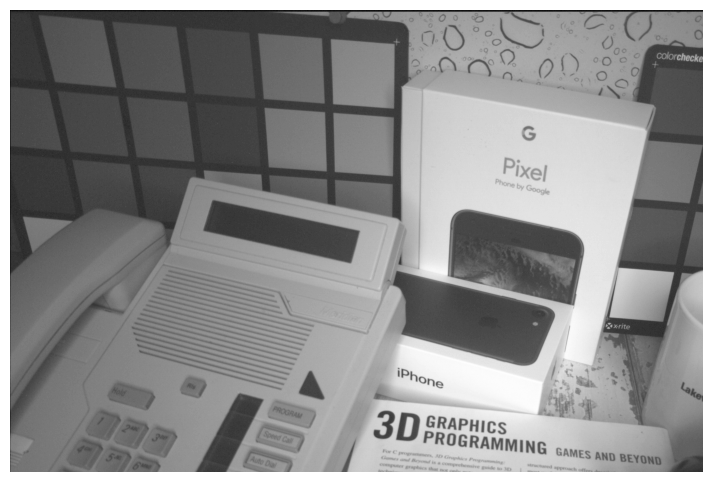

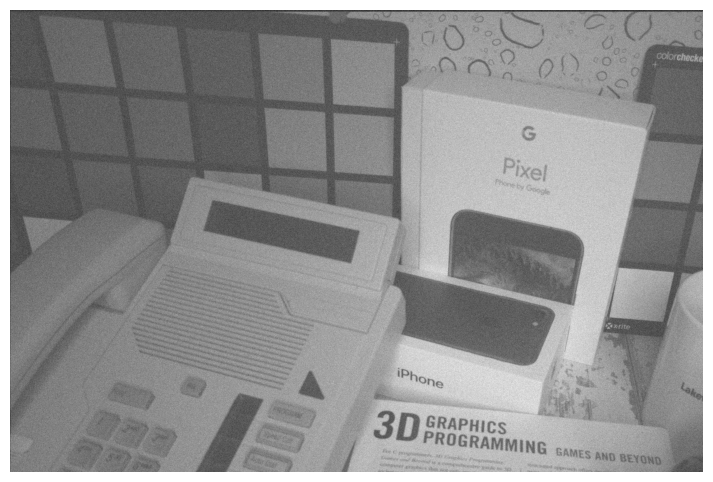

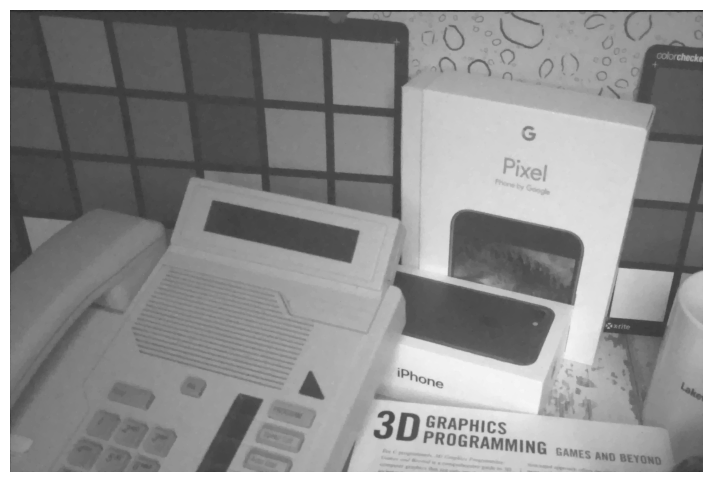

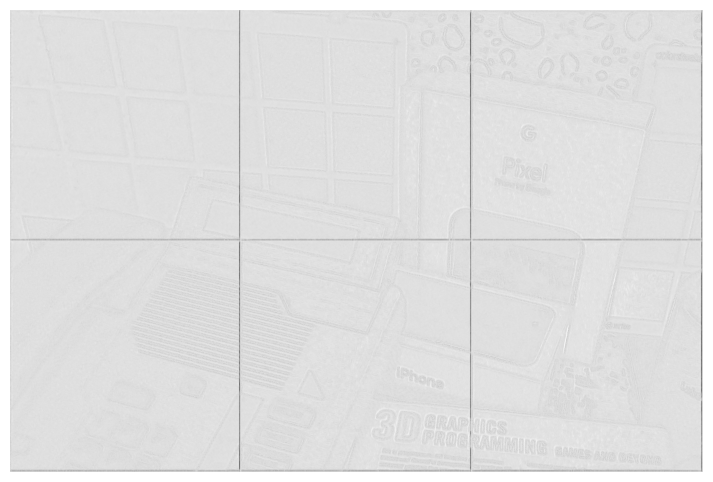

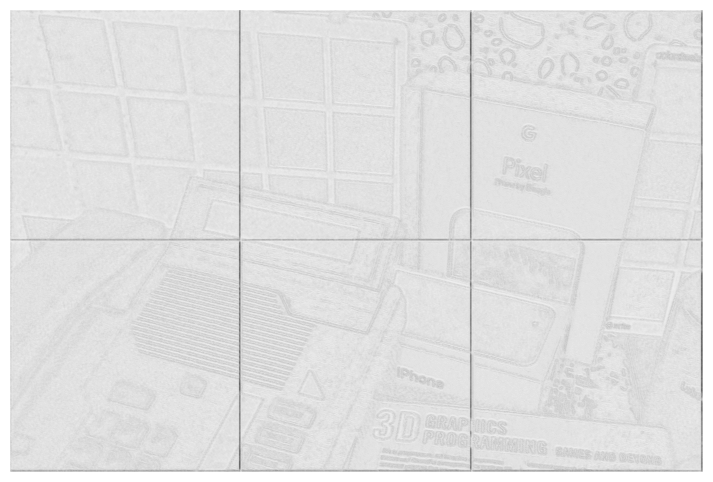

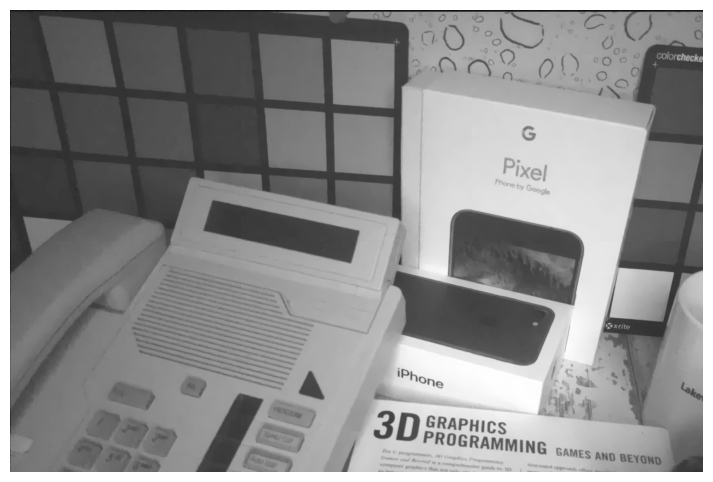

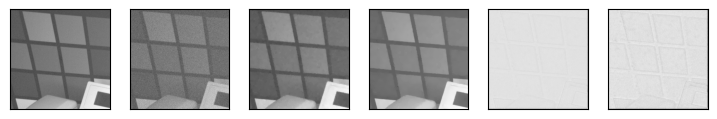

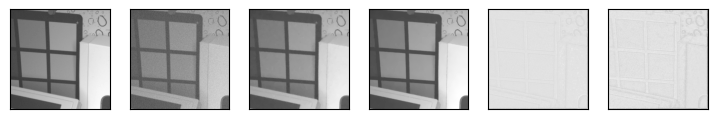

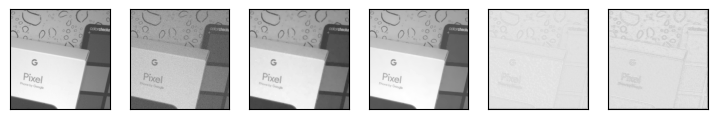

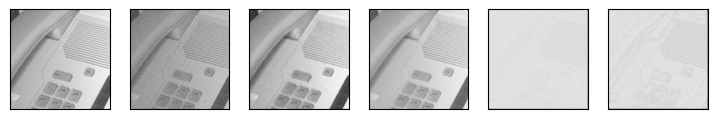

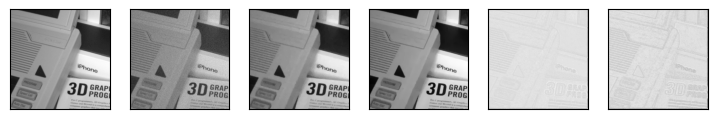

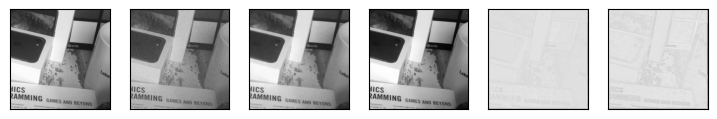

In [ ]:
# CODE TO INFER AND SHOW SOME RESULTS HERE


# Use pdhg for prediction
def test_denoise(model_name, model_folder, trained_on):
    """
    Testing denoising with pre-trained parameters. We can 
    try any image we want. If the image is larger than 192x192, 
    we have to crop it to 192x192 patches and then stitch the
    patches back together.

    TODO: If the size is not divisible by 192, we have to pad
    the image with zeros to make it divisible by 192. Then we
    remove the padding before/after stitching the patches back
    together.
    """
    with torch.no_grad(): # IMPORTANT! Need no_grad to free GPU cache
        torch.cuda.empty_cache()

        # Get a clean image
        img_id = "0065"  # scene 003
        # img_id = "0102"
        # img_id = "0044"  # scene 002
        # img_id = "0055"
        # img_id = "0030"
        # scale = 0.25
        scale = 0.5
        clean_image = load_images([img_id], False)[0]
        clean_image = convert_to_grayscale(clean_image)
        clean_image = resize_image(clean_image, scale)
        clean_image = convert_to_tensor(clean_image)

        # k_w, k_h = 192, 192
        k_w, k_h = 512, 512
        kernel_size = [k_w, k_h, 1]
        stride = [k_w, k_h, 1]
        img_h = clean_image.size(1)
        img_w = clean_image.size(2)
        n_rows = img_h // k_h
        n_cols = img_w // k_w
        # best_lambda = 0.03 # Found by brute force on image 0065 kernel 192x192, sigma 0.3
        best_lambda = 0.05 # Found by brute force on image 0065 kernel 512x512, sigma 0.3
        # best_lambda = 0.2 # Found by brute force on image 0065 kernel 512x512, sigma 1
        sigma = 0.3
        # sigma = 1
        # activation = "ReLU"
        activation = "LeakyReLU"

        folder_name = f"./tmp/images/presentation-img_{img_id}-scale_{str(scale).replace('.', '_')}-sigma_{str(sigma).replace('.', '_')}-best_lambda_{str(best_lambda).replace('.', '_')}-kernel_{k_w}-model_{model_name}-activation_{activation}-trained_on_{trained_on}-time_{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
        

        os.makedirs(folder_name, exist_ok=True)

        with open(f"{folder_name}/logs.txt", "w") as log_file:
            print(f"Image ID: {img_id}", file=log_file)
            print(f"Scale: {scale}", file=log_file)
            print(f"Kernel size: {kernel_size}", file=log_file)
            print(f"Stride: {stride}", file=log_file)
            print(f"Best lambda: {best_lambda}", file=log_file)
            print(f"Sigma: {sigma}", file=log_file)
            print(f"Model name: {model_name}", file=log_file)
            # print(f"Model folder: {model_folder}", file=log_file)
            print(f"(Need to verify) Trained on: {trained_on}", file=log_file)
            # print(f"Folder name: {folder_name}", file=log_file)


            # Crop image to size divisible by kernel size
            clean_image = clean_image[:, :kernel_size[0]*n_rows, :kernel_size[0]*n_cols]
            x_patches_clean = extract_patches_3d(
                clean_image, 
                kernel_size=kernel_size, padding=0, stride=stride, dilation=1)
            save_image_and_patches(
                clean_image, x_patches_clean, "clean", 
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray', 
                # showing=True
                )

            # Add noise to the image
            noisy_image = add_noise(clean_image, sigma=sigma)
            x_patches = extract_patches_3d(
                noisy_image, 
                kernel_size=kernel_size, padding=0, stride=stride, dilation=1)
            save_image_and_patches(
                noisy_image, x_patches, "noisy",
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray', 
                # showing=True
                )


            # Denoise the image using a single lambda
            # best_lambda = 0.1 # Purposefully using the wrong lambda to see the effect
            x_denoised_single_lambda = reconstruct_with_PDHG(noisy_image.unsqueeze(0), best_lambda, T=128)
            x_denoised_single_lambda = x_denoised_single_lambda.squeeze(0)
            x_denoised_single_lambda_patches = extract_patches_3d(
                x_denoised_single_lambda, 
                kernel_size=kernel_size, padding=0, stride=stride, dilation=1)
            save_image_and_patches(
                x_denoised_single_lambda, x_denoised_single_lambda_patches, "denoised_single_lambda", 
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray',
                # showing=True
                )
        
            
            # Denoise the patches using our method
            torch.cuda.empty_cache()
            unet = UNet(dim=3, n_ch_in=1).to(DEVICE)
            total_params = sum(p.numel() for p in unet.parameters())
            print(f"UNet total parameters: {total_params}", file=log_file)
            # pdhg_state_dicts = torch.load(f"{model_folder}/{model_name}.pt")
            # pdhg = DynamicImageStaticPrimalDualNN(
            #     cnn_block=unet, 
            #     # T=128,
            #     T=1000,
            #     phase="training",
            #     up_bound=0.5,
            #     mode="lambda_cnn",
            # ).to(DEVICE)
            # pdhg.load_state_dict(pdhg_state_dicts)
            pdhg = torch.load(f"{model_folder}/{model_name}.pt")

            torch.save(pdhg.state_dict(), f"{model_folder}/{model_name}_state_dict.pt")

            pdhg.eval()
            final_lambda_reg_max = 0
            final_lambda_reg_min = 1
            x_patches_denoised = []
            lambda_reg_x_patches = []
            lambda_reg_y_patches = []
            for i in range(len(x_patches)):
                noisy_patch = x_patches[i]
                noisy_patch = noisy_patch.unsqueeze(0)
                denoised_patch = pdhg(noisy_patch)

                # Analyse lambda map
                lambda_reg_patch = pdhg.cnn(noisy_patch)
                print(f"lambda_reg_patch shape: {lambda_reg_patch.shape}")
                
                lambda_reg_x_patch = lambda_reg_patch[:, 0, :, :]
                lambda_reg_y_patch = lambda_reg_patch[:, 1, :, :]
                
                lambda_reg_x_patches.append(lambda_reg_x_patch)
                lambda_reg_y_patches.append(lambda_reg_y_patch)

                lambda_reg_max = torch.max(lambda_reg_patch)
                lambda_reg_min = torch.min(lambda_reg_patch)
                if lambda_reg_max > final_lambda_reg_max:
                    final_lambda_reg_max = lambda_reg_max
                if lambda_reg_min < final_lambda_reg_min:
                    final_lambda_reg_min = lambda_reg_min

                denoised_patch = denoised_patch.squeeze(0)
                x_patches_denoised.append(denoised_patch)

            print(f"final_lambda_reg_max: {final_lambda_reg_max}", file=log_file)
            print(f"final_lambda_reg_min: {final_lambda_reg_min}", file=log_file)

            x_patches_denoised = torch.stack(x_patches_denoised)

            torch.cuda.empty_cache()

            # Convert list to tensor
            lambda_reg_x_patches = torch.stack(lambda_reg_x_patches)
            lambda_reg_y_patches = torch.stack(lambda_reg_y_patches)

            image_denoised_lambda_map = stitch_patches_back_to_image(
                x_patches_denoised,
                img_h=clean_image.size(1),
                img_w=clean_image.size(2),
                k_h=k_h,
                k_w=k_w)
            
            # Clip to 0 and 1
            image_denoised_lambda_map = torch.clamp(image_denoised_lambda_map, 0, 1)

            lambda_reg_x_all = stitch_patches_back_to_image(
                lambda_reg_x_patches,
                img_h=img_h,
                img_w=img_w,
                k_h=k_h,
                k_w=k_w)
            lambda_reg_y_all = stitch_patches_back_to_image(
                lambda_reg_y_patches,
                img_h=img_h,
                img_w=img_w,
                k_h=k_h,
                k_w=k_w)
            save_image_and_patches(
                lambda_reg_x_all, lambda_reg_x_patches, "lambda_reg_x",
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray',
                # showing=True
                )
            save_image_and_patches(
                lambda_reg_y_all, lambda_reg_y_patches, "lambda_reg_y",
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray',
                # showing=True
            )
            
            save_image_and_patches(
                image_denoised_lambda_map, x_patches_denoised, "denoised_lambda_map", 
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray',
                # showing=True
                )

            save_patches_side_by_side(
                x_patches_clean, x_patches, x_denoised_single_lambda_patches, x_patches_denoised, lambda_reg_x_patches, lambda_reg_y_patches,
                folder_name, log_file=log_file,
                # showing=True
                )

            torch.cuda.empty_cache()

# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/states/2024_05_24_23_04_31.pt"))
# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/states/2024_05_24_23_29_27.pt"))
# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/good states/192 by 192 by 1 - trained on image 65 only/2024_05_24_23_29_27.pt"))
# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/states - trained on all 200 images kernel size 192/2024_05_25_19_36_13.pt"))
# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/states - trained on all 200 images kernel size 192/2024_05_25_19_36_13.pt"))
test_denoise(
    # model_name="img_0065-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_09_38_07_epoch_9774",
    model_name="img_0065-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_09_54_19_epoch_9962",
    # model_name="img_0065-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_07_10_36_epoch_8000",
    # model_name="model_epoch_408",
    # model_name="model_epoch_138",
    # model_name="model_epoch_1562",
    model_folder=f"./tmp/states",
    # model_folder=f"./tmp/model_scene_03-img_0054_to_0074-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_12_55_44",
    # model_folder=f"./tmp/model_img_0065-scale_0_5-kernel_512-sigma_0_3-T_128-ReLU_2024_05_26_15_11_22",
    # model_folder=f"./tmp/model_img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU_2024_05_26_15_55_13",
    trained_on="img_0065")


loading image id 0044, 1/1


 10%|█         | 1/10 [00:01<00:11,  1.33s/it]

single_lambda: 0.01, PSNR: 26.59433364868164


 20%|██        | 2/10 [00:02<00:10,  1.34s/it]

single_lambda: 0.022222222222222223, PSNR: 30.230419158935547


 30%|███       | 3/10 [00:03<00:08,  1.28s/it]

single_lambda: 0.034444444444444444, PSNR: 32.601200103759766


 40%|████      | 4/10 [00:05<00:07,  1.30s/it]

single_lambda: 0.04666666666666667, PSNR: 33.046878814697266


 50%|█████     | 5/10 [00:06<00:06,  1.26s/it]

single_lambda: 0.05888888888888889, PSNR: 32.61941909790039


 60%|██████    | 6/10 [00:07<00:04,  1.23s/it]

single_lambda: 0.07111111111111111, PSNR: 32.057411193847656


 70%|███████   | 7/10 [00:08<00:03,  1.23s/it]

single_lambda: 0.08333333333333333, PSNR: 31.542844772338867


 80%|████████  | 8/10 [00:10<00:02,  1.24s/it]

single_lambda: 0.09555555555555556, PSNR: 31.1002254486084


 90%|█████████ | 9/10 [00:11<00:01,  1.26s/it]

single_lambda: 0.10777777777777778, PSNR: 30.726665496826172


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

single_lambda: 0.12, PSNR: 30.402067184448242
Best PSNR: 33.046878814697266 dB
Best lambda: 0.04666666666666667


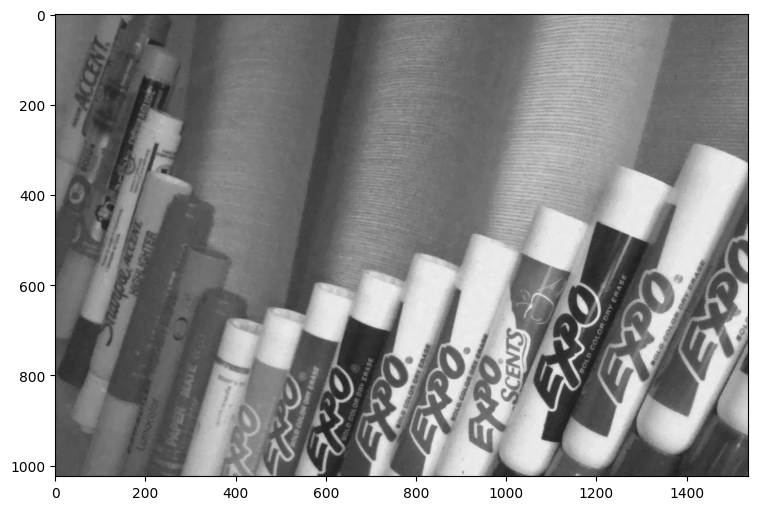

In [ ]:
def brute_force_single_lambda():
    """
    To compare this with our method
    """

    # Try 
    with torch.no_grad(): # IMPORTANT! Need no_grad to free GPU cache
        torch.cuda.empty_cache()

        # Get a clean image
        # img_id = "0065"
        img_id = "0044"
        # img_id = "0102"
        # img_id = "0055"
        # img_id = "0030"
        # scale = 0.25
        scale = 0.5
        clean_image = load_images([img_id], False)[0]
        clean_image = convert_to_grayscale(clean_image)
        clean_image = resize_image(clean_image, scale)
        clean_image = convert_to_tensor(clean_image)

        # k_w, k_h = 192, 192
        k_w, k_h = 512, 512
        kernel_size = [k_w, k_h, 1]
        stride = [k_w, k_h, 1]
        img_h = clean_image.size(1)
        img_w = clean_image.size(2)
        n_rows = img_h // k_h
        n_cols = img_w // k_w
        sigma = 0.3
        # 0065: 0.05
        # 0044: 0.05
        # 0102: 0.02
        # sigma = 1

        # Crop image to size divisible by kernel size
        clean_image = clean_image[:, :kernel_size[0]*n_rows, :kernel_size[0]*n_cols]

        # Add noise to the image
        noisy_image = add_noise(clean_image, sigma=sigma)

        best_psnr = 0
        best_lambda = -100
        min_lambda = 0.01
        max_lambda = 0.12
        for single_lambda in tqdm(np.linspace(min_lambda, max_lambda, 10)):

            x_denoised = reconstruct_with_PDHG(noisy_image.unsqueeze(0), single_lambda, T=128)
            # print(f"x_denoised size: {x_denoised.size()}")

            x_denoised_psnr = PSNR(clean_image, x_denoised)
            print(f"single_lambda: {single_lambda}, PSNR: {x_denoised_psnr}")
            if x_denoised_psnr > best_psnr:
                best_psnr = x_denoised_psnr
                best_lambda = single_lambda

        print(f"Best PSNR: {best_psnr} dB")
        print(f"Best lambda: {best_lambda}")

        x_denoised = reconstruct_with_PDHG(noisy_image.unsqueeze(0), best_lambda, T=128)
        fig, ax = plt.subplots(1, 1, figsize=(9,6))
        plt.imshow(x_denoised.squeeze(0).squeeze(0).to("cpu").detach().numpy(), cmap='gray')
        plt.show();
        torch.cuda.empty_cache()
    
    torch.cuda.empty_cache()

brute_force_single_lambda()


------

### Results

Even though the PSNR increases slightly, there are still a few problems:

- The smaller details like text on a book almost always get lost.
- The model only works on small patches so combining the patches create a very unnatural-looking image.

------

### Conclusion

------

### Todo

I noticed that some GPU memory (about 1 GB) is still occupied after all code was done running. When I restarted the kernel all GPU memory is then freed. Is there somewhere else I should try to force emptying GPU cache?